# Automation Version 2.7

3/10/19 update - CLASSIFICATION SOLIDIFIED AND FINISHED. Essential goal: analyzes the SPLASH spectra using a variety of different "score calculation" methods in order to classify the stars into three groups: carbon stars, weak CN stars, and other/normal stars.

    started 3/22/19 - ATTEMPT AT CREATING WCN TEMPLATE BY Rachel and Antara

In [1]:
#tools needed for data analysis throughout the code
import os 
import numpy as np
import random
import array as arr
import math as m
import statistics as st
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import path
import seaborn as sns #used for plotting kernel density plots
import pandas as pd #used for turning data into dataframes(tables)
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel 
%matplotlib inline 

In [2]:
#path to the folder that necessary program information is stored in
#this should be the only thing that needs to change between computers
#keep the r at the front, and outside of the string, when pasting in a new pathname
pathname = r'/Users/Suhas/Desktop/SIP/' 

In [3]:
#reads the data from the SPLASH fits file
hdu = fits.open(os.path.join(pathname, 'subMasterSPLASH2.fits'))
#for the SPLASH survey, all data is contained in a single hdu entry, so the variable data contains all the data
data = hdu[1].data

#reads the data from the keckPHAT fits file
hdu2 = fits.open(os.path.join(pathname, 'keckphat_catalog_replaced.fits'))
#for the keckPHAT survey, all data is contained in a single hdu entry, so the variable data contains all the data
keckPHATdata = hdu2[1].data

In [4]:
#filters stars based on their ZQUAL scores and keeps only those where ZQUAL = 1, 3, or 4
#produces a list of the SPLASH indices of "valid" stars (those who meet the ZQUAL condition above)
#also produces a list of "invalid" star indices (those who have a ZQUAL that is not 1, 3, or 4)
validZQUAL = [1, 3, 4]
invalidStars = []
validStars = []

for star in range(data.size):
    if data["ZQUAL"][star] in validZQUAL:
        validStars.append(star)
    else:
        invalidStars.append(star)
        
#converts the lists into arrays for easier manipulation later on if needed
allinvalidstars = np.array(invalidStars)
allvalidstars = np.array(validStars)

In [5]:
#creates arrays that contain the indices of stars visually identified to be in the categories listed
#note that these indices only include stars that were found to be "valid" in the previous step
others = np.load(os.path.join(pathname, 'validindices', 'nonCarbonOrCNIndices.npy')) #other stars (normal stars)

allcarbon = np.load(os.path.join(pathname, 'validindices', 'allCarbonIndices.npy')) #all carbon stars (not CN) 
wNm = np.load(os.path.join(pathname, 'validindices', 'weakCNIndices.npy')) #weak and marginal CN stars

extremes = np.load(os.path.join(pathname, 'validindices', 'extremeCarbonIndices.npy')) #different individual subsets of carbon stars (extremes, strongs, and mediums together make up allcarbon above)
strongs = np.load(os.path.join(pathname, 'validindices', 'strongCarbonIndices.npy'))
mediums = np.load(os.path.join(pathname, 'validindices', 'mediumCarbonIndices.npy'))

weaks = np.load(os.path.join(pathname, 'validindices', 'weakCarbonIndices.npy')) #stars suspected to be CN (weaks and marginals together make up wNm above)
marginals = np.load(os.path.join(pathname, 'validindices', 'marginalCarbonIndices.npy'))

#creates an array that accomodates for all of the other star indices in SPLASH that were not visually identified/sorted
outsiders_list = [i for i in range(data.size) if i not in others and i not in wNm and i not in allcarbon and i not in invalidStars]
outsiders = np.array(outsiders_list)

#creates sets of different types of stars that can later be used to more quickly test for membership
allcarbon_set, wNm_set, others_set = set(), set(), set()
allcarbon_set.update(allcarbon); wNm_set.update(wNm); others_set.update(others)

In [6]:
#Raja thinks these stars were flagged on the basis of Raja's more careful inspection of zspec notes 
#Confirm with Alex and Arya
flaggedStars = {"allcarbon":[19905], "weaks":[21466], "marginals":[22159, 23248, 24545], "outsiders":[23368, 23390]}
flaggedStars_list = [19905, 21466, 22159, 23248, 23368, 23390, 24545]

In [7]:
#creates a new sample of other/normal stars that is based only on those that have PHAT data
#also creates a new sample of stars containing all of the "other" stars that have no PHAT data
photoOthers, nonphotoOthers, allPhotoStars = [], [], []
allPhotoStars_set, photoOthers_set = set(), set() #sets created for easier membership testing

filter336, filter475, filter814, filter110, filter160 = data["F336W"].tolist(), data["F475W"].tolist(), data["F814W"].tolist(), data["F110W"].tolist(), data["F160W"].tolist()
for star in allvalidstars:
    #checks for PHAT data: checking for data in the following filters
    identifiedFlag = False #a flag that checks whether the current star is an identified one, used later in creation of nonphotoOthers list
    if (not np.isnan(filter336[star]) and filter336[star] < 99) or (not np.isnan(filter475[star]) and filter475[star] < 99) or (not np.isnan(filter814[star]) and filter814[star] < 99) or (not np.isnan(filter110[star]) and filter110[star] < 99) or (not np.isnan(filter160[star]) and filter160[star] < 99):
        if star in others_set or star in wNm_set or star in allcarbon_set:
            allPhotoStars.append(star)
        if star in others_set:
            photoOthers.append(star)
            identifiedFlag = True
    if star in others_set and not identifiedFlag: #if this star is in "others" but was not just added to the photoOthers list
        nonphotoOthers.append(star)
        
allPhotoStars_set.update(allPhotoStars)
photoOthers_set.update(photoOthers)
print("Total number of weakCN,carbon,and other stars with photometric data:", len(allPhotoStars_set))
print("Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited):", len(wNm_set), len(allcarbon_set), len(photoOthers_set))

Total number of weakCN,carbon,and other stars with photometric data: 8011
Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited): 158 98 7760


In [8]:
#defining a list that consists of bright stars from the photoOthers list
bright = [i for i in photoOthers if data['F814W'][i] < 22 and data['F475W'][i] < 24]
print(len(bright))

2858


In [17]:
#creates (mask,slit,objID):index dictionaries to speed up process of finding keckPHAT data for each star
keckIndex_dict = {}
for i in range(len(keckPHATdata['KOBJNAME'])):
    #first pad KSLITNAME with as many 0s as required
    slitName = keckPHATdata['KSLITNAME'][i]
    slitName = '0'*(3-len(str(slitName))) + str(slitName)
    keckIndex_dict[(keckPHATdata['KMASK'][i], slitName, keckPHATdata['KOBJNAME'][i])] = i

In [18]:
#creates the new photoOthers sample based on data from the keckPHAT catalog
keckPhotoOthers, nonKeckPhotoOthers = [], []
keckPhotoOthers_set, indSet = set(), set()
ctr = 0
for star in photoOthers:
    keckInd = keckIndex_dict[(data['MASK'][star], data['SLITNAME'][star], data['OBJNAME'][star])]
    if keckInd in indSet:
        print(str(keckInd) + ': duplicate')
    indSet.add(keckInd)
    if keckPHATdata['BRIGHTFLAG'][keckInd] == 0 and keckPHATdata['CONTFRAC'][keckInd] < 0.5:
        keckPhotoOthers.append(star)
    else:
        nonKeckPhotoOthers.append(star)
    ctr += 1
    if ctr % 500 == 0:
        print(str(ctr) + " stars completed.") 

keckPhotoOthers_set.update(keckPhotoOthers)
print(str(len(photoOthers)) + ' stars in photoOthers became ' + str(len(keckPhotoOthers)) + ' stars in keckPhotoOthers.')

500 stars completed.
1000 stars completed.
1500 stars completed.
2000 stars completed.
2500 stars completed.
3000 stars completed.
3500 stars completed.
4000 stars completed.
4500 stars completed.
5000 stars completed.
5500 stars completed.
6000 stars completed.
6500 stars completed.
7000 stars completed.
7500 stars completed.
7760 stars in photoOthers became 5586 stars in keckPhotoOthers.


In [19]:
#defines variables that will be used for clipping spectra to the right wavelength window
#goal: isolate the 'W' shaped feature shared by carbon and weak CN stars
lowerThresh = 5840         #represents 7796.0 angstroms in data["LBIN"]
upperThresh = 6550         #represents 8257.5 angstroms in data["LBIN"]
middleThresh = 6184        #represents 8019.6 angstroms in data["LBIN"]; point between the two 'U's

In [22]:
#defines different "lower" and "upper" threshold values to be used for normalization and coaddition 
#with these, the operations will be performed over the entire spectrum instead of just around the 7800-8200 angstrom range
fullSpec_low = 0
fullSpec_high = len(data["LBIN"][0])

In [23]:
#performing a NaN cut on the stars to eliminate any whose spectra are more than 10% NaNs on the 'W' range
NANvalidstars_list = allvalidstars[:].tolist()
for star in allvalidstars:
    NANcount = 0
    for flux in data["SPEC"][star][lowerThresh:upperThresh]:
        if np.isnan(flux):
            NANcount += 1
    if NANcount > 0.1*len(data["SPEC"][star][lowerThresh:upperThresh]):
        NANvalidstars_list.remove(star)
NANvalidstars = np.array(NANvalidstars_list)

#metadata: showing how many stars were cut out of the data due to the NaN limits
print(str(len(allvalidstars)) + ' stars became ' + str(len(NANvalidstars)) + ' after the NaN cut.')

20018 stars became 19959 after the NaN cut.


## Normalizing Spectra
Includes spectrum slicing for the raw data, normalization based on median flux, and graphing functions.

In [24]:
#defines a function that will slice any spectrum to desired wavelengths
def sliceSpec(star, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    lower: the lower boundary of the slice, in terms of wavelength
    upper: the upper boundary of the slice, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    
    Returns newWv, a Numpy array containing every wavelength value between lower and upper for which data exists for a certain star 
    Also returns newFlux, a Numpy array containing the flux values that (for a certain star) correspond to each of the wavelength values in newSpec
    Also returns newIvar, a Numpy array containing the ivar values that (for a certain star) corresopnd to each of the wavelength values in newSpec
    '''
    newWv = data["LBIN"][star][lower:upper]
    newFlux = data["SPEC"][star][lower:upper]
    newIvar = data["IVAR"][star][lower:upper]
    return newWv, newFlux, newIvar

In [25]:
#defines a function that can be used to normalize the spectrum of a star on a certain wavelength range
def normSpec(star = None, spectrum = None, ivars = None, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array containing the data that represents the flux values for a spectrum
    ivars: a Numpy array containing the data that represents the ivar values for the same spectrum as above
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    star, spectrum, and ivars all default to None so that either a star index or raw spectral/ivar data can be fed into the function with the same result. Depending on what your data looks like, use the corresponding star or spectrum/ivar inputs and leave the other(s) as None
    Only employ one or the other of these inputs when calling this function; do not define both star and spectrum/ivars at the same time 
    
    If the spectrum is found to consist only of NaN values on the range defined by lower and upper:
    Returns np.array(wvSlice), a Numpy array containing every wavelength value between lower and upper
    Also returns np.array(fluxSlice_list), a Numpy array containing only NaN values that is the same length as np.array(wvSlice)
    Also returns np.array(ivarSlice_list), a Numpy array containing only 0's that is the same length as np.array(wvSlice)
    Also returns False, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that if this happens, the spectrum will not be normalized and therefore cannot be graphed.
    
    Otherwise:
    Returns wvSlice_np, a Numpy array containing every wavelength value between lower and upper
    Also returns normedFlux_np, a Numpy array containing the normalized flux values for a certain star at every wavelength between lower and upper
    Also returns normedIvar_np, a Numpy array containing the changed ivar values that correspond to each of the normalized flux values for a certain star in normedSpec_np
    Also returns True, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that for normedFlux_np, values within 5 pixels of a nan value that fall outside of 5 standard deviations from the mean flux have been replaced with nan values as well
    '''
    #converting arrays to list for easy iteration and modification
    if star is None and (spectrum is None or ivars is None):
        print("InputError: missing one or more of the necessary arguments.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    if star is not None: #if a star index was inputted, get data directly from SPLASH
        wvSlice, fluxSlice, ivarSlice = sliceSpec(star, lower, upper)
    elif np.all(spectrum is not None) and np.all(ivars is not None): #if a spectrum was inputted, use that as the data
        wvSlice, fluxSlice, ivarSlice = data["LBIN"][0][lower:upper], spectrum, ivars
    wvSlice_list = wvSlice.tolist()
    fluxSlice_list = fluxSlice.tolist()
    ivarSlice_list = ivarSlice.tolist()
    
    #creating a version of the spectrum without any NaNs for performing median/standard deviation calculations
    #if the spectrum is all NaNs on the range specified in the function call, will return an error
    #if the spectrum is all 0s on the range specified in the function call, will replace the 0s with NaNs and returm am error
    newFluxSlice = []
    for wv in range(len(fluxSlice_list)):
        #in the case of NaN ivars, exactly 0 ivars, or exactly 0 flux values, flux values should be converted into NaN and ivar values to 0 so that the data is not graphed
        if fluxSlice_list[wv] == 0 or ivarSlice_list[wv] == 0: 
            fluxSlice_list[wv] = np.nan
            ivarSlice_list[wv] = 0 #seems repetitive due to check in if statement, but necessary for any cases where flux = 0 but ivar does not and needs to be set to 0
        elif np.isnan(ivarSlice_list[wv]) or np.isnan(fluxSlice_list[wv]):
            ivarSlice_list[wv] = 0
        else: #add to "non-zero, non-NaN" data
            newFluxSlice.append(fluxSlice_list[wv])
    if newFluxSlice == []:
        print("NormalizationError: The spectrum for star " + str(star) + " contains only NaN values on the specified range. It cannot be normalized.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    medianFlux = st.median(newFluxSlice)
    spec_mean = st.mean(newFluxSlice)
    spec_stdev = st.stdev(newFluxSlice)
    upperLim = spec_mean + 5*spec_stdev #limits calculated to clip out values around nan
    lowerLim = spec_mean - 5*spec_stdev
    
    #replaces with np.nan values that are within 5 pixels of a nan value and outside of 5 standard deviations from the mean flux 
    #accomodates for nan values being located on the edges of the spectrum (in positions where 5 pixels out in either direction would be out of range)
    nanIndices = []
    for index in range(len(fluxSlice_list)):
        if np.isnan(fluxSlice_list[index]): 
            if 5 < index < len(wvSlice_list) - 5:
                for i in range(index-5,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif 5 > index:
                for i in range(0,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif index > len(wvSlice_list) - 5:
                for i in range(index-5, len(wvSlice)): #this should go upto len(specSlice)-1 due to 0-indexing
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan

    #at each pixel, normalizes the star's spectrum and modifies the corresponding ivar value
    normedFlux = []
    normedIvar = []
    for wv in range(len(wvSlice_list)):
        normedFlux.append(fluxSlice_list[wv]/medianFlux)
        normedIvar.append(ivarSlice_list[wv]*(medianFlux**2))
    
    #converts the final products back to arrays for easy manipulation later in the code
    normedFlux_np = np.array(normedFlux)
    normedIvar_np = np.array(normedIvar)
    wvSlice_np = np.array(wvSlice)
    
    return wvSlice_np, normedFlux_np, normedIvar_np, True

In [26]:
#creates splashSpecs_dict, a dictionary of the normalized spectra for every valid star in SPLASH, and splashIvars_dict, a dictionary of the normalized ivar values for those same stars
#keys are the indices of stars, paired values are arrays representing the flux/ivar values of those stars at every wavelength in the range identified
#note that NormalizationError messages may appear if stars that cannot be normalized; in these cases, star index keys are paired with arrays of NaN values in splashSpecs_dict and arrays of 0s in splashIvars_dict (because ivar = 0 for every NaN)
splashSpecs_dict, splashIvars_dict, splashSuccess_dict = {}, {}, {}

#creates a list of stars with high median ivars to later test against their brightnesses
highIvarStars = []

#create lists of median ivars for every star (without including NaN or 0 medians)
#also sets up dictionaries of star:medianIvar for later use in ivar trimming, etc
#note that if a star's spectrum could not be normalized, it will be excluded from these dictionaries (rather than paired with NaNs as was done earlier)
wNm_ivarMeds, carbon_ivarMeds, kphOthers_ivarMeds = [], [], []
wNm_ivarMeds_dict, carbon_ivarMeds_dict, kphOthers_ivarMeds_dict = {}, {}, {}

IVAR_LIMIT = 1000 #an arbitrary constant that acts as the defining limit for what counts as a high-ivar star
count = 0 #progress tracker

for star in allvalidstars:
    #the following lines are done for all stars, as a part of the base dictionary creation
    spSlice, normSp, normIv, success = normSpec(star = star, lower = lowerThresh, upper = upperThresh)
    splashSpecs_dict[star], splashIvars_dict[star], splashSuccess_dict[star] = normSp, normIv, success
    
    #now, based on star type (wNm, carbon, other, highIvar), normIv is added to its corresponding list to be used in subsequent ivar trimming and graphs
    if success: #if the star could not be normalized, then won't be needed in trimming/statistical analyses
        if star in wNm:
            med = np.nanmedian(normIv)
            if med != 0:
                wNm_ivarMeds.append(med); wNm_ivarMeds_dict[star] = med
        if star in allcarbon:
            med = np.nanmedian(normIv)
            if med != 0:
                carbon_ivarMeds.append(med); carbon_ivarMeds_dict[star] = med
        if star in keckPhotoOthers:
            med = np.nanmedian(normIv)
            if med != 0:
                kphOthers_ivarMeds.append(med); kphOthers_ivarMeds_dict[star] = med
        if np.nanmedian(normIv) > IVAR_LIMIT:
            highIvarStars.append(star)
    
    count += 1
    if count%1000 == 0:
        print(str(count) + " done")

1000 done
2000 done
3000 done
NormalizationError: The spectrum for star 5339 contains only NaN values on the specified range. It cannot be normalized.
4000 done
NormalizationError: The spectrum for star 6057 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6157 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6166 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6168 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6197 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6199 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6216 contains only NaN values on the specified range. It cannot be norm

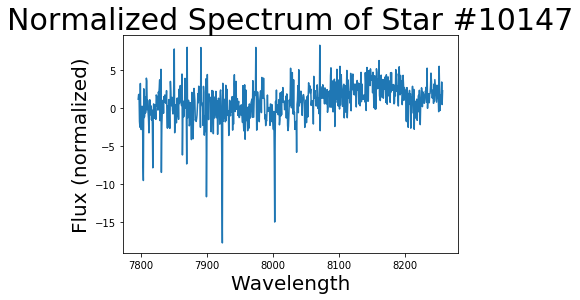

In [27]:
#graphs the normalized spectrum of any star in SPLASH
#inclues the option to graph an already-made template spectrum alongside the normalized spectrum
def graphNormSpec(star = None, spectrum = None, lower = lowerThresh, upper = upperThresh, template = False, templateSpec = None, fileName = None):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array consisting of the data values that represent the flux values of a spectrum to be graphed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    template: a Boolean variable that, if True, will graph the normalized spectrum and the template spectrum on the same graph. If False, only the normalized spectrum will be graphed
    templateSpec: a Numpy array representing the flux values of the spectrum to be used as the template if template is True
    fileName: an optional argument that can be used to save the created graph as a png with the file name designated
    
    Note that in order to use the template, the functions below that are devoted to template creation must be initialized
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    template will default to False, and templateSpec will default to Ctemplate (the carbon coadd)
    star and spectrum will default to None so that either a star index or raw spectral data can be used in the function. Use the inputs that you need based on your data type and leave the other as None
    fileName will default to None, meaning the graph will not be saved as a png
   
    
    Does not return a particular value, but will produce a graph of wavelength versus flux that represents the normalized spectrum of star
    Note that gaps may be present in the spectral graph where NaN values are present in the flux measurements of a certain star
    '''
    #assigning the data to be graphed
    if star is None and np.all(spectrum is None):
        print("InputError: One of 'star' and 'spectrum' must not be None.")
        return None
    if star is not None:
        wvrange, spectrum, ivar = normSpec(star = star, lower = lower, upper = upper)[:3]
    elif np.all(spectrum is not None):
        wvrange, spectrum = data["LBIN"][0][lower:upper], spectrum
    x = wvrange.tolist()
    y = spectrum.tolist()
    
    #this if statement separates out the graphing data that is assigned if template is True
    if template is True:  #Antara - changed the default template to Wtemplate (weak CN coadd)
        y2 = templateSpec
        plt.plot(x, y, color = "b", label = "Normalized Spectrum")
        plt.plot(x, y2, color = "r", label = "Template Spectrum")
        plt.legend(fontsize = 20)
    else:
        plt.plot(x,y)
    
    #formatting the graph so that it is easily readable and executing its creation
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Normalized Spectrum of Star #" + str(star), size = 30) 
    plt.ylabel("Flux (normalized)", size = 20)
    plt.xlabel("Wavelength", size = 20) 
    if fileName is not None:
        plt.savefig(fileName)
    else:
        plt.show()

#test execution of the function
graphNormSpec(star = 10147)

In [28]:
#a histogram-making function that condenses parameters and has constant defaults that are used in most of our histograms
#note: some features of this function are final/set-in-stone, thus only compatible where these features work

#version note: defaultHist has not been implemented/used in v2.4.0, go to 2.5.1 to see usage
def defaultHist(data, binList, colors, labels, graphLabels, xLim = None, yLim = None, dens=False,alphas = None, step = 0, fileName = None):
    '''
    main note on this function: everything should be passed in as a tuple - even if a single value, put [ ] around
   
    data: a tuple containing all the lists of data to plot on the same histogram
    binList: the Numpy array to use as bins (used for ALL data populations)
    colors: a tuple containing all the colors, corresponding to each sample in data
    labels: a tuple containing all the labels, corresponding to each sample in data
    graphLabels: a tuple of length 3 containing data for the graph: (1) title, (2) x-label, (3) y-label
    dens: a boolean that, if True, will make the histogram a density histogram - default is False
    xLim, yLim: if not None, the limits to put on the viewing rectangle of the graph
    alphas: a tuple of alpha values (transparency amounts) - default is None (no transparency)
    step: if greater than 0, implies a step histogram should be used. value is the line width for the histogram
    fileName: if not None, means this plot should be saved as a figure with this file name.
    '''
    
    for index in range(len(data)):
        a = 1
        if not alphas is None:
            a = alphas[index]
        if step > 0:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], histtype='step', linewidth = step, density = dens, alpha = a)
        else:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], density = dens, alpha = a)
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title(graphLabels[0], size = 50) 
    plt.xlabel(graphLabels[1], size = 40)
    plt.ylabel(graphLabels[2], size = 40)
    plt.legend(fontsize = 35)

    if xLim is not None:
        plt.xlim(xLim)
    if yLim is not None:
        plt.ylim(yLim)
    
    if fileName is not None:
        plt.savefig(fileName)

    plt.show()


## Coadding Spectra
Includes sigma clipping for normalized spectral data, coaddition, and graphing functions. Also includes a Gaussian function to smooth spectral graphs. Creates three template spectra to be used in later score calculation methods; these include both a clipped and full-range carbon star template as well as a weak CN star template.

In [29]:
#defines a function that clips out outlier data points in a set of spectra 
#outliers are defined as points that lie outside of a certain number of standard deviations away from the median flux value at each wavelength
def sigmaClip(spectra, ivars, nsigma = 3.5):
    '''
    spectra: a list of the spectra of each star that is being clipped
    ivars: a list of the sets of ivars for each star that is being coadded
    nsigma: an integer or float representing the number of standard deviations away from the median to be used in clipping
    
    nsigma will default to 3.5 unless otherwise specified
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns spectra, a list of the spectra of each star in terms of flux
    Also returns ivars, a list of the set of ivars of each star with values corresponding to the invalid values in spectra (those that lie more than nsigma standard deviations away from the median) replaced by 0s
    '''
    sortedSpecList = []
    for value in range(len(spectra[1])): #note that the use of spectra[1] is arbitrary as all of the lists in spectra have the same length
        listToAdd = []
        for spectrum in range(len(spectra)):
            if not np.isnan(spectra[spectrum][value]):
                listToAdd.append(spectra[spectrum][value])
        sortedSpecList.append(listToAdd)
    medians = []
    for eachlist in range(len(sortedSpecList)):
        if len(sortedSpecList[eachlist]) != 0:
            medians.append(st.median(sortedSpecList[eachlist]))
        else: 
            medians.append(np.nan)
        if eachlist%100 == 0 and eachlist != 0:
            print(str(eachlist) + " medians calculated.")
    for spectrum in range(len(spectra)):
        for flux in range(len(spectra[1])): #see above comment
            if np.isnan(medians[flux]):
                continue
            elif ivars[spectrum][flux] != 0 and not np.isnan(spectra[spectrum][flux]):
                testFlux = ((spectra[spectrum][flux] - medians[flux])**2)*ivars[spectrum][flux] 
                if testFlux > nsigma**2:
                    spectra[spectrum][flux] = np.nan
                    ivars[spectrum][flux] = 0          
    return spectra, ivars

In [30]:
#defines a function that will coadd normalized spectra based on provided lists of spectra and ivar weights
def coadd(spectra, ivars, lower = lowerThresh, upper = upperThresh):
    '''
    spectra: a list of the spectra of each star that is being coadded
    ivars: a list of the sets of ivars for each star that is being coadded
    lower: the lower boundary of the range the spectrum have been normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum have been normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns wvValues_np, a Numpy array containing every wavelength value for which spectral data exists between lower and upper
    Also returns coaddedFlux_np, a Numpy array containing the flux values of the coadded spectrum corresponding to each wavelength in wvValues_np 
    Also returns coaddedIvar_np, a Numpy array containing the ivar values of the coadded spectrum corresponding to each wavelength in  wvValues_np
    '''
    wvValues = data["LBIN"][0][lower:upper].tolist()
    coaddedFlux = []
    coaddedIvar = []
    for wv in range(len(wvValues)):
        fluxSum = 0
        ivarSum = 0
        for star in range(len(spectra)):
            if not np.isnan(spectra[star][wv]): 
                fluxSum += spectra[star][wv] * ivars[star][wv] #multiplying by ivar as a weight, as per formula
                ivarSum += ivars[star][wv]
        if ivarSum == 0:
            coaddedFlux.append(np.nan)
            coaddedIvar.append(0)
        else:
            newFlux = fluxSum/ivarSum #normalizing the weights, as per formula
            coaddedFlux.append(newFlux) #coaddedSpec now contains a coadded spectrum value at each LBIN value
            coaddedIvar.append(ivarSum) #coadded ivar is simply the sum of all ivars for a certain bin, across all stars (based on a mathematical proof)
    for flux in range(len(coaddedFlux)):
        if coaddedFlux[flux] == 0:
            coaddedFlux[flux] = np.nan
    coaddedFlux_np = np.array(coaddedFlux)
    wvValues_np = np.array(wvValues)
    coaddedIvar_np = np.array(coaddedIvar)
    return wvValues_np, coaddedFlux_np, coaddedIvar_np

In [31]:
#defines a function that applys a smoothing function to a spectrum to improve the quality of the spectrum's graph
#used in this program largely for smoothing the graphs of template spectra
def applyGauss(spectrum, gauss = 2):
    '''
    spectrum: a Numpy array containing the flux values of a pre-clipped and normalized (if applicable) star spectrum that will be smoothed
    gauss: an optional numerical argument to be used as the standard deviation of the Gaussian kernel
    
    gauss will default to 2 if no other value is provided (this value was determined based on previous work by A. Kamath)
    
    Returns smoothSpec, a Numpy array containing the modified/smoothed flux values of the original spectrum
    '''
    kernel = Gaussian1DKernel(gauss)
    smoothSpec = convolve(spectrum, kernel)
    return smoothSpec

In [32]:
#defines a function that creates a coadded template spectrum by combining several spectra normalized over a certain range
def getTempSpec(starIndices, lower = lowerThresh, upper = upperThresh, nsigma = 3.5):
    '''
    starIndices: an array or list of the indices of the stars to be coadded (which correspond to spectra in SPLASH)
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    nsigma: a numerical value representing the number of standard deviations away from the flux medians that data for the coaddition will be trimmed to
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    nsigma will default to 3.5 unless another value is provided
    
    Returns coadd_wv, the set of all wavelength values for which data exists in the final coadded spectrum
    Also returns coadd_spec, the set of all flux values that correspond to the wavelength values in coadd_wv for the final coadded spectrum
    Also returns coadd_ivar, the number representing the ivar for every wavelength value on the final coadded spectrum
    Note that the final spectrum has been created from nsigma clipped data
    '''
    #creating lists of normalized spectra and ivars for each star to be coadded
    spectra = []
    ivars = []
    for star in starIndices:
        if lower == lowerThresh and upper == upperThresh:
            spectra.append(splashSpecs_dict[star].tolist())
            ivars.append(splashIvars_dict[star].tolist())
        else:
            starSpec, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
            spectra.append(starSpec.tolist())
            ivars.append(starIvar.tolist())
    print("Step 1 of 3 complete. Normalized spectra and inverse variances loaded.")

    #takes the original data and replaces with NaN values any data points that are greater than nsigma standard deviations from the median
    #the median is defined as the median flux at each wavelength when the flux values for every spectrum at that wavelength are considered
    spectra_new, ivars_new = sigmaClip(spectra, ivars, nsigma)
    print("Step 2 of 3 complete. Spectral and ivar data clipped to " + str(nsigma) + " sigmas.")

    #performs the coaddition with the edited data from the last step
    coadd_wv, coadd_spec, coadd_ivar = coadd(spectra_new, ivars_new, lower, upper)
    print("Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.")
    
    return coadd_wv, coadd_spec, coadd_ivar

In [33]:
Ctemplate_wv, Ctemplate, Ctemplate_ivar = getTempSpec(allcarbon)
Ctemplate_wv_full, Ctemplate_full, Ctemplate_ivar_full = getTempSpec(allcarbon, lower = fullSpec_low, upper = fullSpec_high)
Wtemplate_wv, Wtemplate, Wtemplate_ivar = getTempSpec(wNm)
Wtemplate_wv_full, Wtemplate_full, Wtemplate_ivar_full = getTempSpec(wNm, lower = fullSpec_low, upper = fullSpec_high)

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
NormalizationError: The spectrum for star 22283 contains only NaN values on the specified range. It cannot be normalized.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
800 medians calculated.
900 medians calculated.
1000 medians calculated.
1100 medians calculated.
1200 medians calculated.
1300 medians calculated.
1400 medians calculated.
1500 medians calculated.
1600 medians calculated.
1700 medians calculated

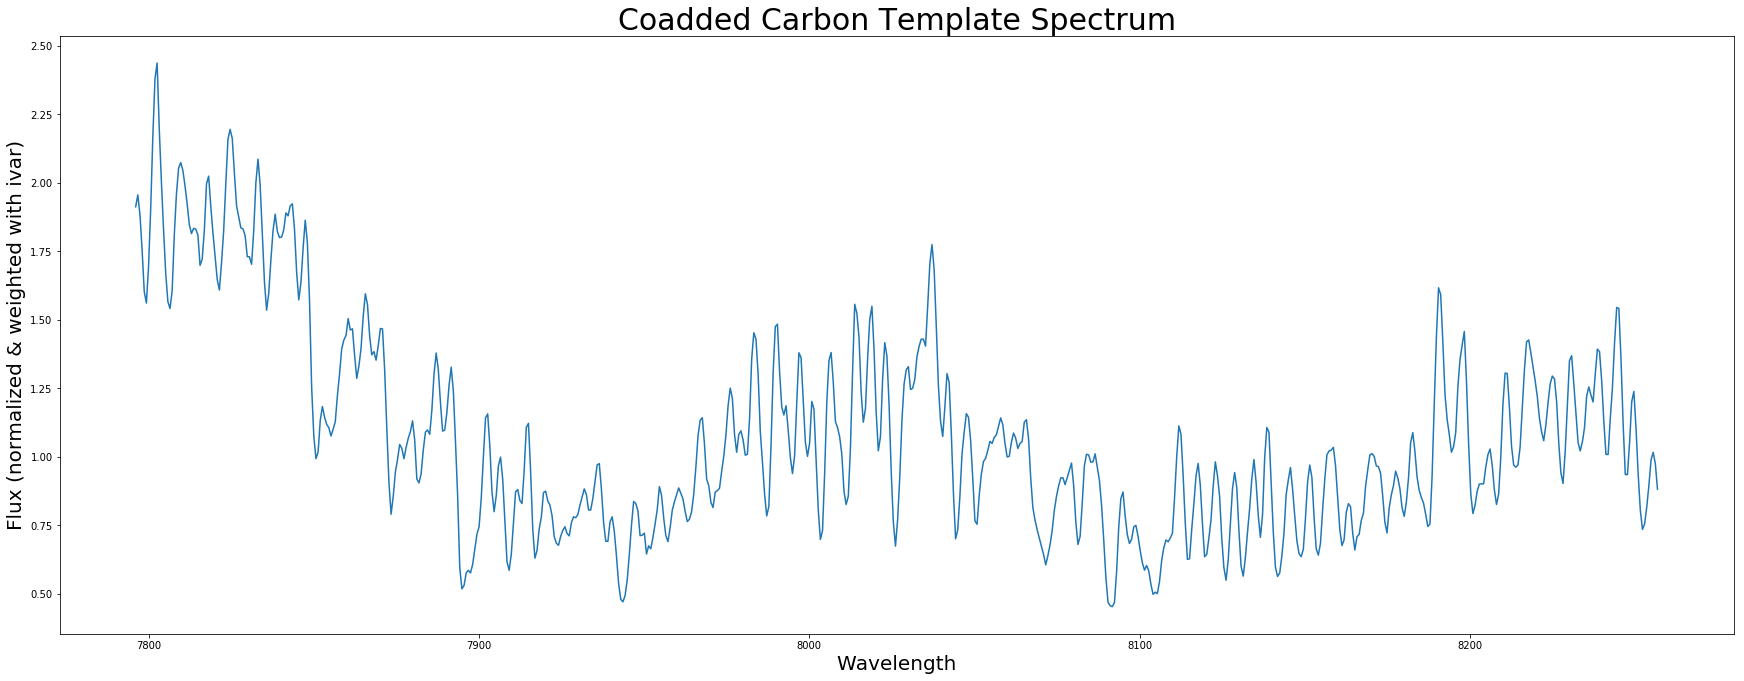

In [34]:
#graphs the limited-range carbon template spectrum created from the above function

x = Ctemplate_wv.tolist()
y = Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Carbon Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

## Ivar Analysis (Plotting & Trimming)
Focuses on analyzing ivars of different stars in order to further process and analyze spectral data. First, creates plots of ivar vs brightness to look for correlation between high ivar and high brightness (as a measure of affirmation that high ivar values are not unfounded). Then, trims the PHAT keckPhotoOthers sample set to match weak CN and carbon in terms of normalized distribution of ivars.
End result is two samples of others stars, others1 and others2, which match the weak CN and carbon ivar distributions, respectively.

### Part 1: Ivar v. Brightness Analysis

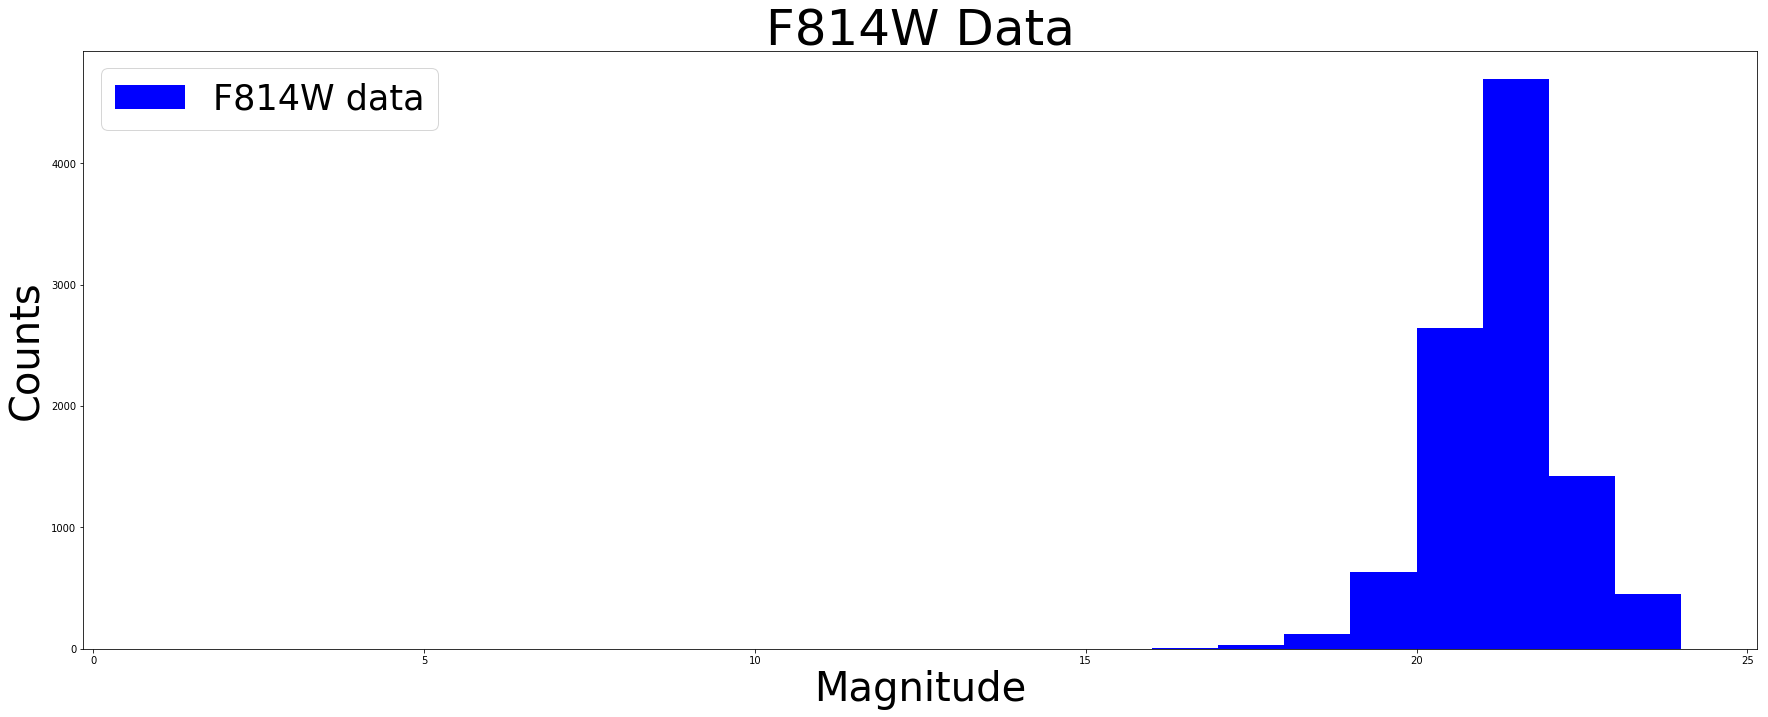

In [35]:
#makes a histogram of the F814W data, to get a general sense of the distribution
defaultHist([data['F814W'][~np.isnan(data["F814W"])]], np.arange(1, 25), ["b"], ["F814W data"], ("F814W Data", "Magnitude", "Counts"))

In [36]:
#creates the data needed to make a scatter plot of IVAR v MAGNITUDE 
#goal: check if extremely high ivar is really correct
#implementation note: can't use the ivarMeds lists because need to know the star itself (to determine the brightness)
x, y, wNm_x, wNm_y, carb_x, carb_y, kphO_x, kphO_y = [], [], [], [], [], [], [], [] #creating lists that will be filled with the coordinates for each star
highIvarNaN = wNmIvarNaN = carbIvarNaN = kphOIvarNaN  = 0 #defining counters that will be used to keep track of how many stars have NaN values in the F814W dataset
SAMPLE_OTHERS = False #this boolean represents a flag of whether to plot the full photo others (False), or only a 10% sample (True)
REMOVE_OVERLAP = True #this boolean represents a flag of whether to remove the high star data from the control data (since that is where they originate from, really)
                      #if REMOVE_OVERLAP is true, then the stars in the wNm, carbon, and kphOthers control groups will NOT have the highIvarStars data in them

print("Flag states:", "SAMPLE_OTHERS =", SAMPLE_OTHERS, 'and', "REMOVE_OVERLAP =", REMOVE_OVERLAP)
#create the x and y data for the high ivar stars: x = median of ivars, y = F814W magnitude
for star in highIvarStars:
    x.append(np.nanmedian(splashIvars_dict[star])) #these stars MUST have non-0, non-NaN ivars, due to their construction as "high ivar stars"
    y.append(data["F814W"][star])
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of highIvar
        highIvarNaN += 1
        
print('The following stars overlap in wNm and highIvarStars.') 
wNmOverlap = 0
for star in wNm: #control group 1: weak CN stars
    if star not in wNm_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = wNm_ivarMeds_dict[star]
        wNm_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as wNm_ivarMeds; otherwise, it is no-highIvarStar clipped version
        wNm_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", med)
        wNmOverlap += 1
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of wNm
        wNmIvarNaN += 1
if wNmOverlap == 0:
    print("NONE")
        

print('The following stars overlap in carbon and highIvarStars.')
cOverlap = 0
for star in allcarbon: #control group 2: carbon stars
    if star not in carbon_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = carbon_ivarMeds_dict[star]
        carb_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as carbon_ivarMeds; otherwise, it is no-highIvarStar clipped version
        carb_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        cOverlap += 1
        print(star, "median ivar =", med)
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of carbon
        carbIvarNaN += 1
if cOverlap == 0:
    print("NONE")

print('The following stars overlap in the control group of PHAT-others and highIvarStars.')
oOverlap = 0
if SAMPLE_OTHERS:
    picker = 0
    print('SAMPLE_OTHERS = TRUE, so this is not ALL of the stars in highIvarStars from keckPhotoOthers; since this is a 10% sample, it is likely 10% the actual, larger number.')
for star in keckPhotoOthers: #control group 3: keckPhotoOthers (with possibility of randomized 10% subset)
    if SAMPLE_OTHERS:
        picker += 1
        if not picker % 10 == randrange(0, 9, 1): #generates a random number to use, will pick ~1/10 the subset
            continue
    if star not in kphOthers_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    currentMed = kphOthers_ivarMeds_dict[star]
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        kphO_x.append(currentMed)
        kphO_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", currentMed)
        oOverlap += 1
    if np.isnan(data["F814W"][star]):
        kphOIvarNaN += 1 #this will likely be 0 (although not certain, due to "OR" condition in keckPhotoOthers construction)
if oOverlap == 0:
    print("NONE")
    
#printing out metadata for debugging/testing uses        
print("Brightness NaN counts (highIvar, wNm, carbon, kphO):", highIvarNaN, wNmIvarNaN, carbIvarNaN, kphOIvarNaN) #check to see how many of each type don't have data in F814W 
print("Total Stars (highIvar, wNm, carbon, kphO):", len(x), len(wNm_y), len(carb_y), len(kphO_y))
print("Overlaps (wNm, carbon, kphO):", wNmOverlap, cOverlap, oOverlap)
print("Maximum Ivar Found:", np.max(x))

Flag states: SAMPLE_OTHERS = False and REMOVE_OVERLAP = True
The following stars overlap in wNm and highIvarStars.
20903 median ivar = 262.89997553928066
21555 median ivar = 110.2616634990361
24483 median ivar = 93.30942519182388
24926 median ivar = 138.34087599596683
20291 median ivar = 604.6909361239703
20320 median ivar = 486.30066856688643
21069 median ivar = 19.51136386467212
21305 median ivar = 185.83203399376632
21308 median ivar = 185.83203399376632
21323 median ivar = 185.83203399376632
21474 median ivar = 135.62499996532108
21588 median ivar = 250.98972966615247
21729 median ivar = 69.82537781146353
21821 median ivar = 69.82537781146353
21858 median ivar = 69.82537781146353
22009 median ivar = 178.11910531903385
22569 median ivar = 150.37443675864526
22602 median ivar = 167.72658420556075
23596 median ivar = 98.45840943921644
23693 median ivar = 336.6515339933757
24045 median ivar = 126.41405848443782
24233 median ivar = 336.5530303142299
The following stars overlap in carbon

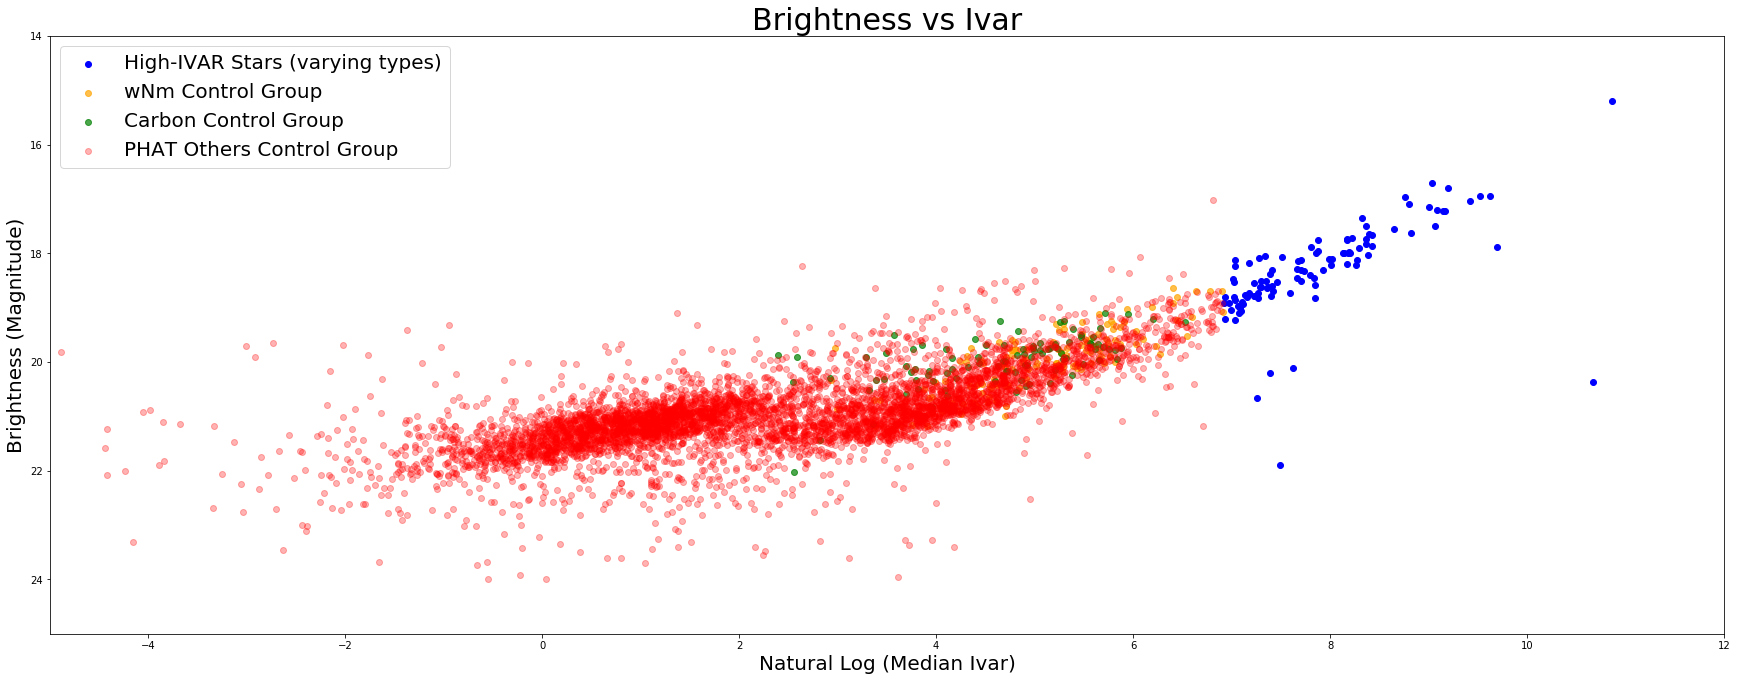

In [37]:
#creates the scatter plots of the star ivars vs brightness
#note that the dataset is split into the highIvarStars, and wNm and carbon as controls
plt.scatter(np.log(x), y, color = 'b', label = "High-IVAR Stars (varying types)")
plt.scatter(np.log(wNm_x), wNm_y, color = 'orange', alpha = 0.7, label = "wNm Control Group")
plt.scatter(np.log(carb_x), carb_y, color = 'g', alpha = 0.7, label = "Carbon Control Group")
plt.scatter(np.log(kphO_x), kphO_y, color = 'r', alpha = 0.3, label = "PHAT Others Control Group")

#formatting the graph to make it easier to read
plt.xlim(-5, 12) #after 17000, just a few outliers (some ~20000, 2 ~ 50000, 1 ~ 180000, 1 ~ 225000), with magnitudes ~16, 15, 13
#only 2 kPH stars with ivars < natlog -7
plt.ylim(25, 14)
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Brightness vs Ivar", size = 30) 
plt.ylabel("Brightness (Magnitude)", size = 20)
plt.xlabel("Natural Log (Median Ivar)", size = 20)
plt.legend(fontsize = 20)
#plt.savefig('brightVivar.png')
plt.show()

### Part 2: Ivar Histograms (observing distributions)

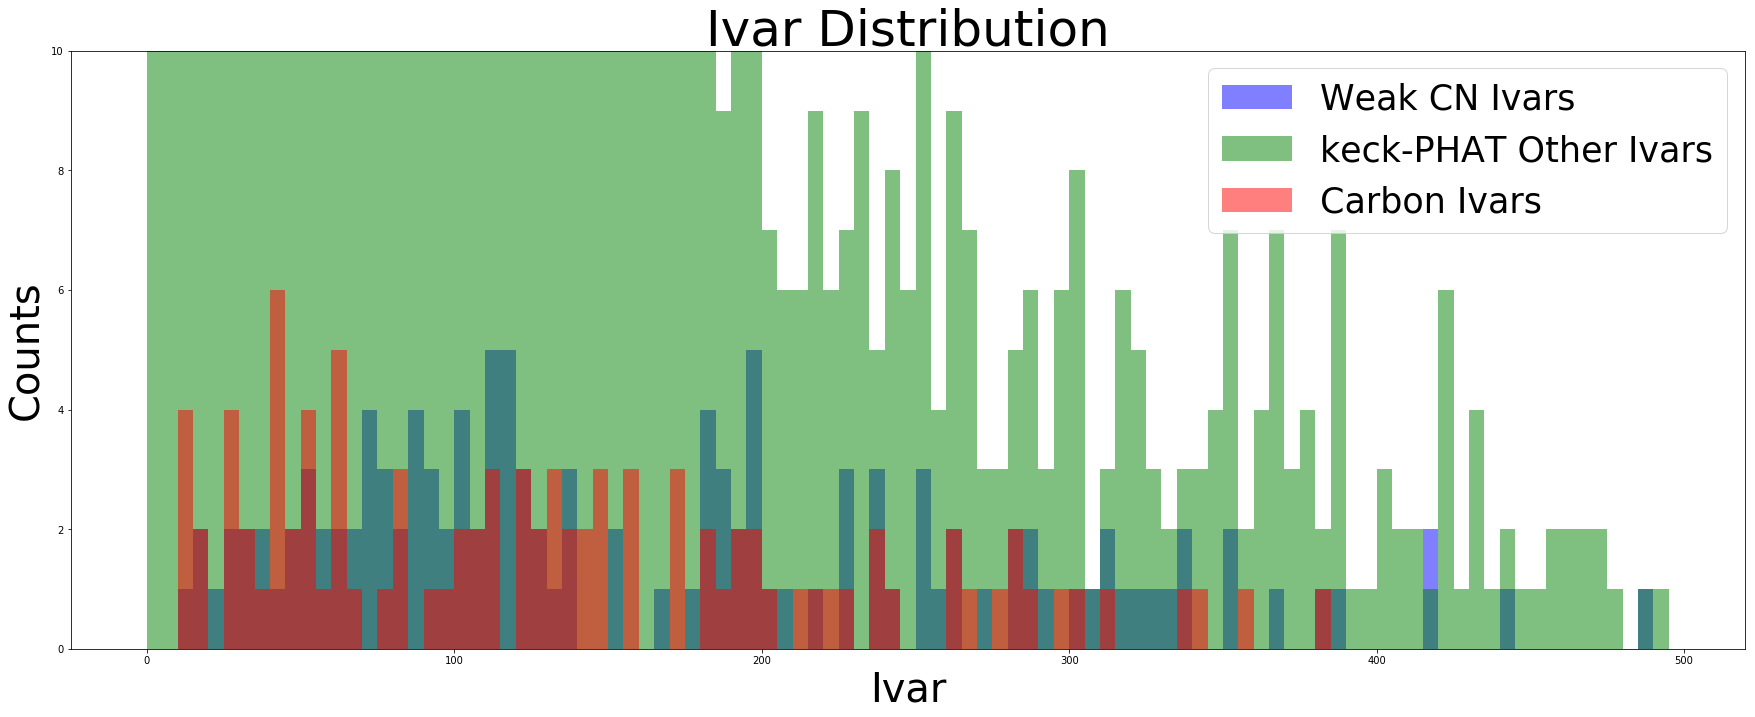

In [38]:
#create a histogram of ivars for different types of stars to provide insight into distribution of uncertainty for wNm, carbon, and other stars
binList = np.arange(0, 500, 5)
defaultHist([wNm_ivarMeds, kphOthers_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keck-PHAT Other Ivars", "Carbon Ivars"), ("Ivar Distribution", "Ivar", "Counts"),
            yLim = (0,10), alphas = (0.5,0.5,0.5))

#note: yLim is optional, remove for full version

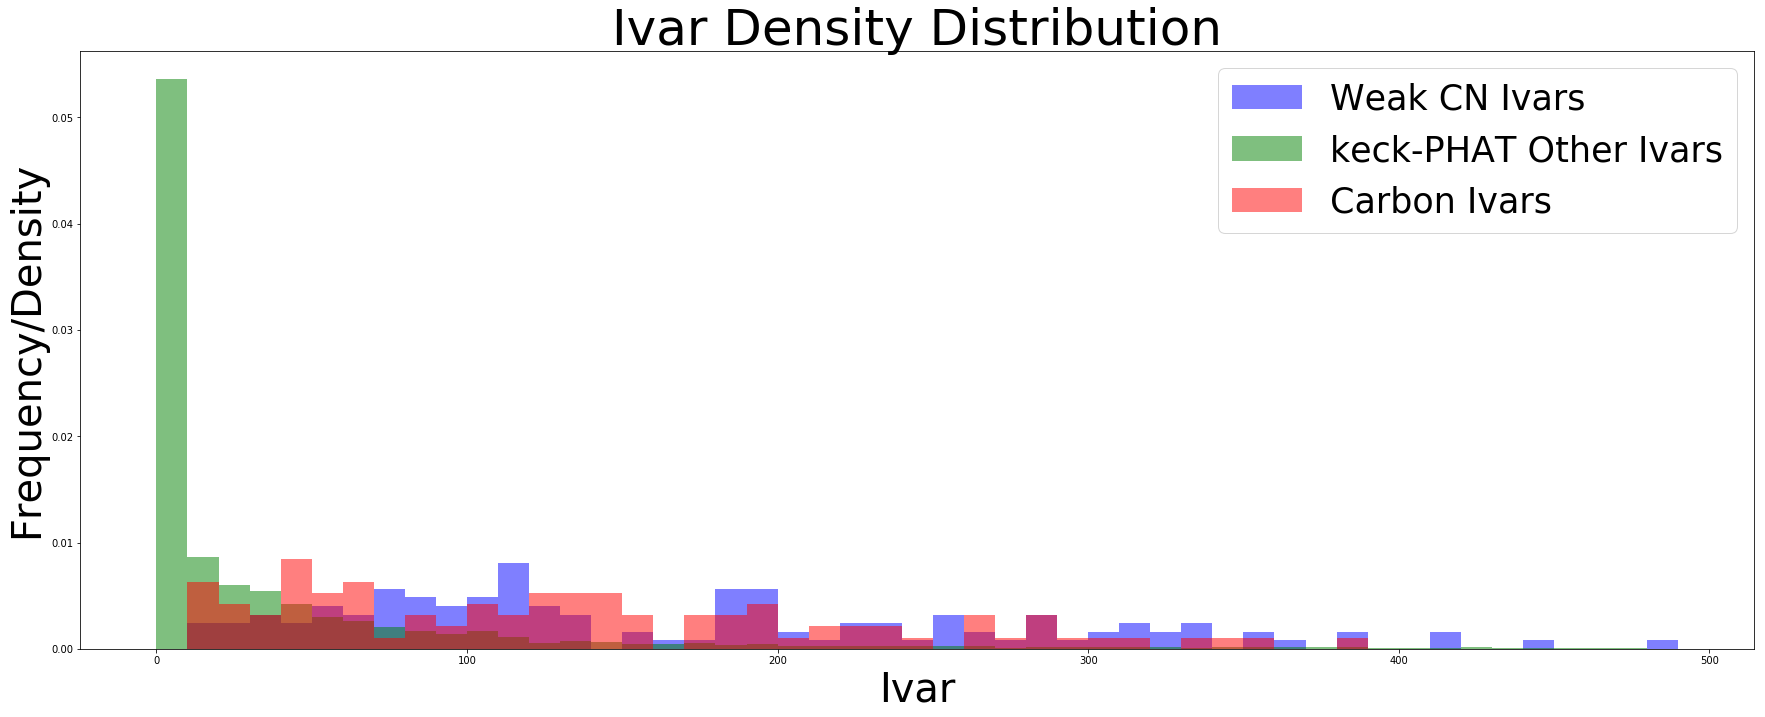

In [39]:
#creates a density histogram of the ivars for different types of stars
binList = np.arange(0, 500, 10)
defaultHist([wNm_ivarMeds, kphOthers_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keck-PHAT Other Ivars", "Carbon Ivars"), ("Ivar Density Distribution", "Ivar", "Frequency/Density"),
            dens=True, alphas = (0.5,0.5,0.5))
plt.show()

### Part 3: Trimming Based on Ivars

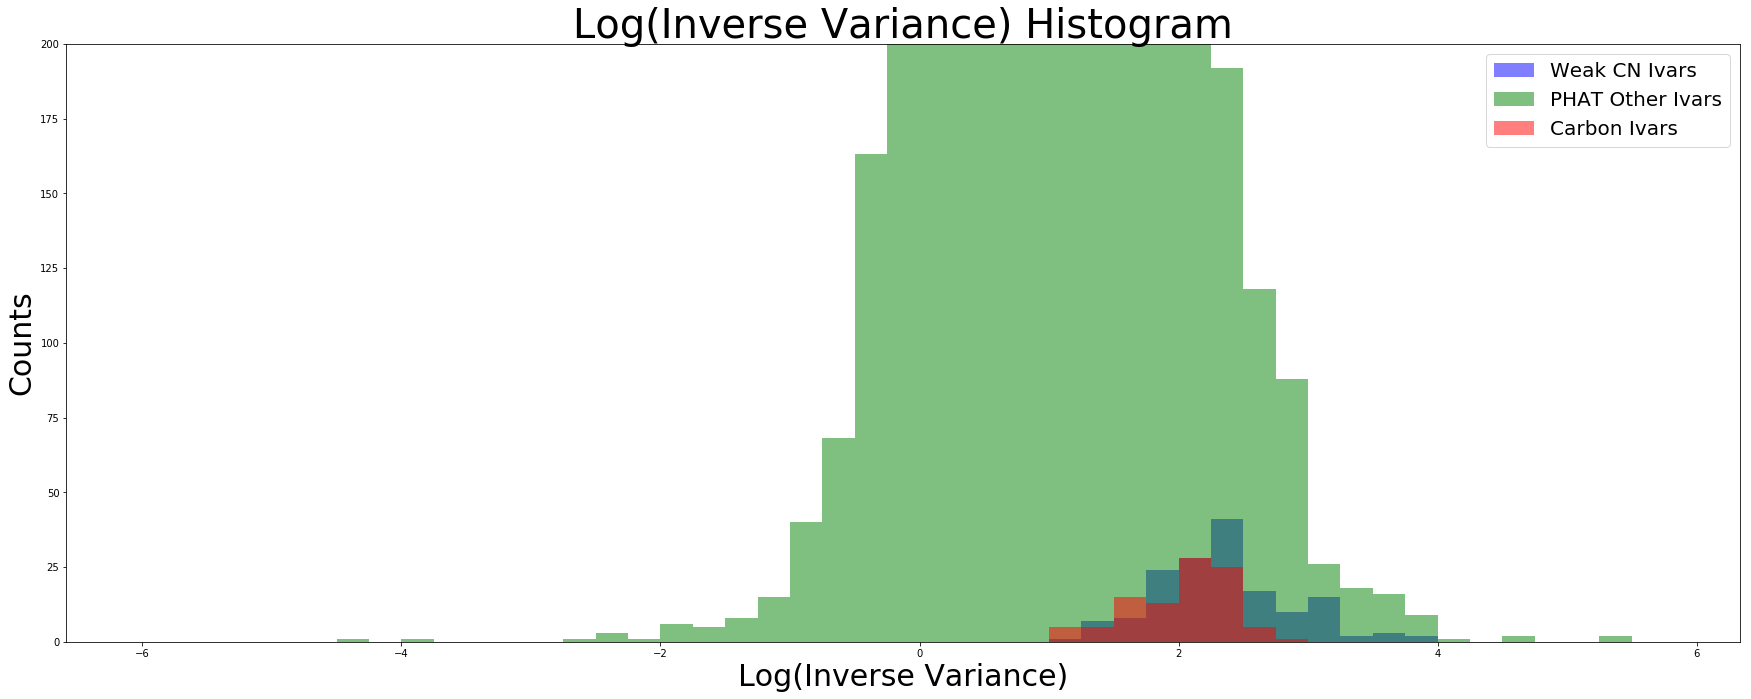

In [40]:
#method of ivar trimming: take a ratio based on high-ivar ratio
#step 1: create histogram based on log (ivar), step sizes of 1.5
binList = np.arange(-6, 6, 0.25) #largest value ~160000

wNm_logHighData = plt.hist(np.log(wNm_ivarMeds)/np.log(10), bins = binList, color = "b", alpha = 0.5, label = "Weak CN Ivars")
kphO_logHighData = plt.hist(np.log(kphOthers_ivarMeds)/np.log(10), bins = binList, color = "g", alpha = 0.5, label = "PHAT Other Ivars")
carb_logHighData = plt.hist(np.log(carbon_ivarMeds)/np.log(10), bins = binList, color = "r", alpha = 0.5, label = "Carbon Ivars")
plt.legend(fontsize = 20)
plt.title("Log(Inverse Variance) Histogram", fontsize = 40)
plt.xlabel("Log(Inverse Variance)", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.ylim(0, 200)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['figure.figsize'] = 30, 11
#plt.savefig('logivar_histbase.png')
plt.show()

In [41]:
#step 2: find ratios of other stars to wNm and carbon stars at high ivars, which will be applied to lower ivars to clip the sample
#finding ratio for others1 (high kphOthers:high wNm)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 1000 = 3) is index 36
highKphOSum = highwNmSum = 0
for i in range(36, len(kphO_logHighData[0])):
    highKphOSum += kphO_logHighData[0][i]
    highwNmSum += wNm_logHighData[0][i]
others1R = highKphOSum/highwNmSum

#finding ratio for others2 (kphOthers:carbon) after 10^2.5 (~316)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 10^2.5 = 2.5) is index 34
highKphOSum = highCarbSum = 0
for i in range(34, len(kphO_logHighData[0])):
    if not carb_logHighData[0][i] == 0: #stops the ratio from going beyond 700-ish, as the carbon stars are limited by that value but the other stars are not
        highKphOSum += kphO_logHighData[0][i]
        highCarbSum += carb_logHighData[0][i]
others2R = highKphOSum/highCarbSum

print('others1:', others1R, '|', 'others2:', others2R)

others1: 3.3636363636363638 | others2: 34.333333333333336


In [42]:
#helper function for trimStars
#defines a function which will give a fraction (probability) to run through trimStars, based on bin-based-ratio
def ratioLim(sampleData, medIvar, ratio, modelData):   
    '''
    algorithm
    a. find bin which this ivar falls under
    b. multiply the count of weakCN/carbon (model population) by the constant ratio previously created for that bin
    c. divide the result of (b) by the total number of stars in the current bin from the kphOthers population (the one to trim)
    
    sampleData: the dataset that you wish to clip/modify based on ivar
    medIvar: the ivar to operate with
    ratio: a numerical value representing the ratio of other stars population to model carbon/weak CN population previously found 
    modelData: the dataset that you are trying to match the sampleData to through ivar clipping
    buckets: the buckets with which to operate - if the log-ivar histogram bins are changed, then this must be changed as well
    
    Note that buckets will default to an array from 0 to 6 with a step size of 0.25 unless otherwise assigned
    
    Returns a numerical value representing a probability that will be used to choose a certain number of stars from the sample population
    '''
    buckets = sampleData[1]
    logIv = np.log(medIvar)/np.log(10)
    step = buckets[1] - buckets[0]
    index = int((logIv - buckets[0])/step)
    goalCount = ratio*modelData[0][index]
    return goalCount/sampleData[0][index]

In [43]:
#defines a function that takes in a sample of stars and trims that sample according to the ivars of those stars
def trimStars(starSample, medIvDict, modelData, ratio, sampleData):
    '''
    starSample: the sample of stars that you wish to trim based on ivar
    medIvDict: a dictionary of the median ivars for the stars in starSample; keys are the indices of the stars and values are the median ivars
    modelData: the model histogram data for bin-based ratio calculation (wNm_logHighData or carb_logHighData)
    ratio: the ratio of other:model to use for trimming the starSample dataset
    sampleData: the sample histogram data for bin-based ratio calculation (kphO_logHighData); a 2D array representing the histogram frequencies/bins that were used to find the ratio
    
    Returns pickStar, an array of Boolean values corresponding to the stars in starSample. True indicates that the star should be selected and False indicates that it should not be selected
    Also returns trimmed_ivarMeds, an array containing the median ivar values for each of the stars in the new trimmed sample. In other words, these median ivars correspond to the "True"s in the pickStar array
    '''
    pickStar = np.zeros(len(starSample), dtype = bool)
    trimmed_ivarMeds = []
    index = 0
    for star in starSample: #set to choose from is keckPhotoOthers (not the entire others set)
        if star not in medIvDict:
            index += 1 #must actually skip this index in pickStar, on top of just moving to next star
            continue
        starMedIvar = medIvDict[star]
        
        #find the fraction to pick, and thus probability of picking, based on the function: limFunc(starMedIvar)
        pickFraction = ratioLim(sampleData, starMedIvar, ratio, modelData)
        if random.random() < pickFraction: #random.random() generates a floating point number from [0.0, 1.0)
            pickStar[index] = True #this star will be picked for the new sample
            trimmed_ivarMeds.append(starMedIvar) #add this star's median ivar to a list, to plot in the new normalized histogram
        index += 1
    return pickStar, trimmed_ivarMeds

In [44]:
#creating trimmed others1 and others2 samples based on the ivar-trimming functions above
chosenStars1, kphTrimmedOthers1_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, wNm_logHighData, others1R, kphO_logHighData)
kphTrimmedOthers1 = np.array(keckPhotoOthers)[chosenStars1]
chosenStars2, kphTrimmedOthers2_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, carb_logHighData, others2R, kphO_logHighData)
kphTrimmedOthers2 = np.array(keckPhotoOthers)[chosenStars2]

### Part 4: New Ivar Histograms & Analysis of Trimmed Data

Post-Clipping Size in wNm-Based Trimming: 525
Original Size: 5586


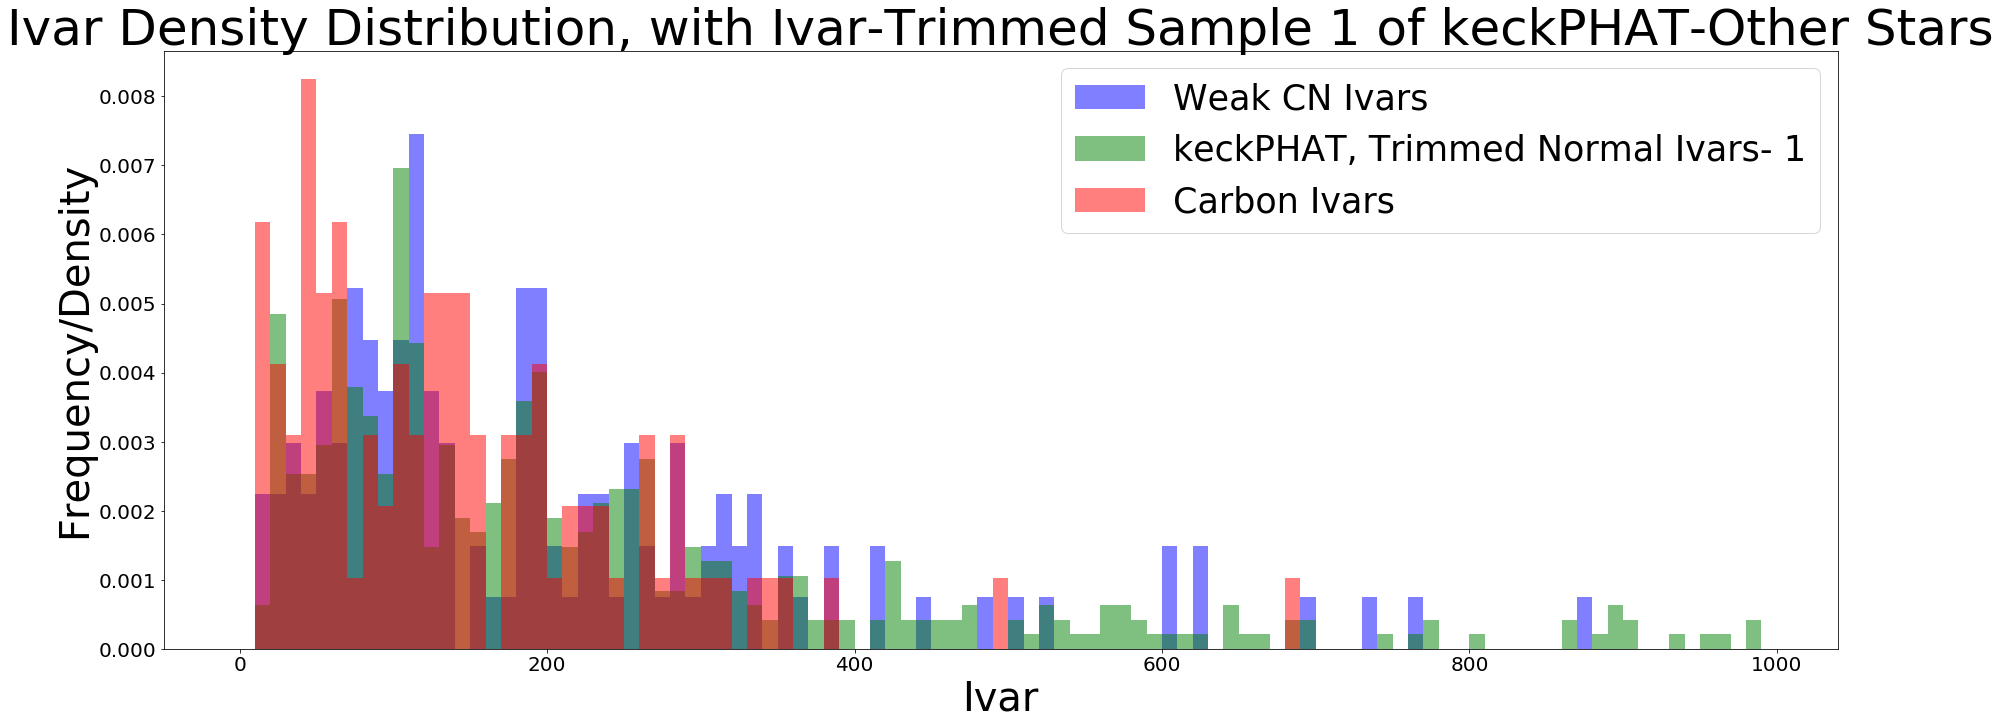

In [45]:
#wNm-based trimming - histogram/data analysis
#goal: make the two ivar distributions (others1 and weak CN) as similar as possible
print("Post-Clipping Size in wNm-Based Trimming:", len(kphTrimmedOthers1))
print("Original Size:", len(keckPhotoOthers))

#creating + formatting the histogram
binList = np.arange(0, 1000, 10)
defaultHist([wNm_ivarMeds, kphTrimmedOthers1_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keckPHAT, Trimmed Normal Ivars- 1", "Carbon Ivars"), 
            ("Ivar Density Distribution, with Ivar-Trimmed Sample 1 of keckPHAT-Other Stars", "Ivar", "Frequency/Density"),
             dens=True,alphas = (0.5,0.5,0.5), fileName="ivarDensity_hist_others1")

Post-Clipping Size in Carbon-Based Trimming: 1001
Original Size: 5586


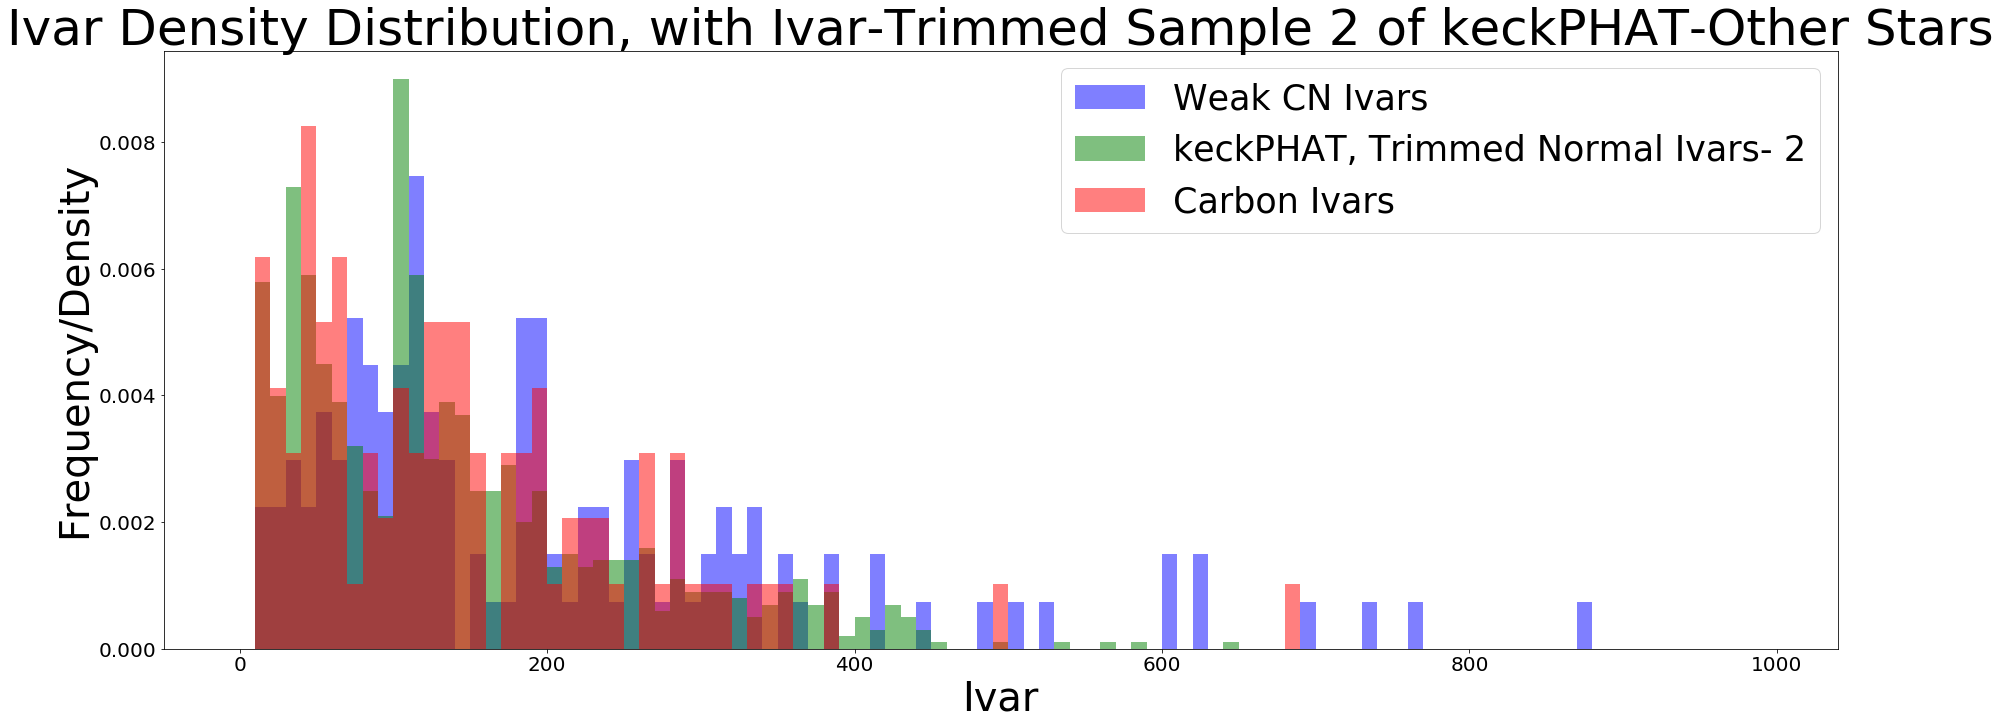

In [63]:
#carbon-based trimming - histogram/data analysis
#goal: make the two ivar distributions (others2 and carbon) as similar as possible
print("Post-Clipping Size in Carbon-Based Trimming:", len(kphTrimmedOthers2))
print("Original Size:", len(keckPhotoOthers))

#creating and formatting the histogram
binList = np.arange(0, 1000, 10)
defaultHist([wNm_ivarMeds, kphTrimmedOthers2_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keckPHAT, Trimmed Normal Ivars- 2", "Carbon Ivars"), 
            ("Ivar Density Distribution, with Ivar-Trimmed Sample 2 of keckPHAT-Other Stars", "Ivar", "Frequency/Density"),
             dens=True,alphas = (0.5,0.5,0.5), fileName="ivarDensity_hist_others2")

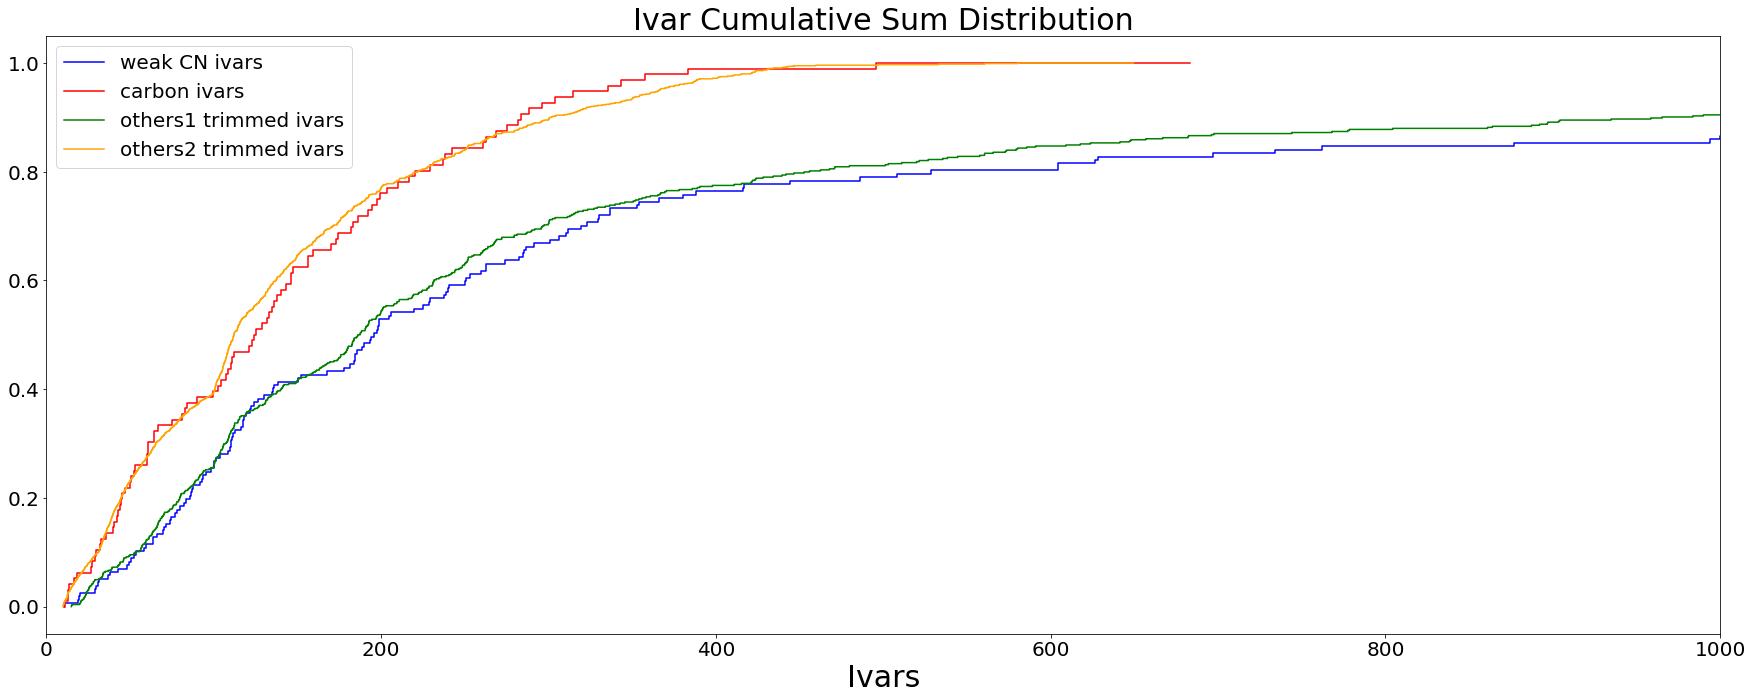

In [64]:
#making unbinned cumulative distribution plots, based on a step of 1/N for each data point
#step 1: sorting the data
wNm_sortedMeds = np.sort(wNm_ivarMeds)
carb_sortedMeds = np.sort(carbon_ivarMeds)
kphO1_sortedMeds = np.sort(kphTrimmedOthers1_ivarMeds)
kphO2_sortedMeds = np.sort(kphTrimmedOthers2_ivarMeds)

#step 2: make the cumulative sum as a step function with a step size of 1 / N (where N is set size), so all samples' y's end at 1
plt.step(wNm_sortedMeds, np.linspace(0, 1, len(wNm_sortedMeds)), color = 'blue', label = "weak CN ivars")
plt.step(carb_sortedMeds, np.linspace(0, 1, len(carb_sortedMeds)),  color = 'red', label = "carbon ivars")
plt.step(kphO1_sortedMeds, np.linspace(0, 1, len(kphO1_sortedMeds)), color = 'green', label = "others1 trimmed ivars")
plt.step(kphO2_sortedMeds, np.linspace(0, 1, len(kphO2_sortedMeds)), color = 'orange', label = "others2 trimmed ivars")

#formatting the chart so that it is easy to read
plt.title("Ivar Cumulative Sum Distribution", size = 30) 
plt.xlabel("Ivars", size = 30)
plt.legend(fontsize = 20)
plt.xlim(0, 1000)
#plt.savefig('ivarDistr_cumulativeSum_others1+2_raw.png')
plt.show()

### Part 5: Further Cleaning of Others2 Data
Goal: to make the others2 sample better match the carbon star sample in terms of ivar distribution. Current methods: don't keep any stars with ivar > 700, from 0 - 100 keep only 30% of stars (evenly distributed in range after sorting; i.e. 1, 5, 9 in every interval of 10), and from 450 - 700 keep only 10% of stars (after sorting, only star 4 in every interval of 10).

In [65]:
#performs the clean-up of the others2 sample based on the methods described above
keep = []
keepIvars = []
UPPER_LIM = 700 #no carbon stars have median ivars beyond 700

kphTrimmed2_dict = {}
for star in kphTrimmedOthers2:
    kphTrimmed2_dict[star] = kphOthers_ivarMeds_dict[star] #all stars in kphTrimmedOthers2 are in ivarMeds dictionary, but not vice versa

ctr = 1
for star in sorted(kphTrimmed2_dict, key = kphTrimmed2_dict.get):
    ctr = ctr % 10
    keepStar = True
    if star not in kphOthers_ivarMeds_dict:
        continue
    med = kphOthers_ivarMeds_dict[star]
    if med > UPPER_LIM: 
        keepStar = False
    if 0 < med < 100: 
        if ctr % 2 == 0 or ctr == 3 or ctr == 7: #a way of picking 1, 5, 9 values
            keepStar = False
    if 450 <= med < 700:
        if not ctr == 4:
            keepStar = False
    ctr += 1
    if keepStar:
        keep.append(star)
        keepIvars.append(kphTrimmed2_dict[star])

#creates the final trimmed-by-ivar others2 sample, with separate but corresponding median ivars
kphTrimmedOthers2, kphTrimmedOthers2_ivarMeds = keep, keepIvars

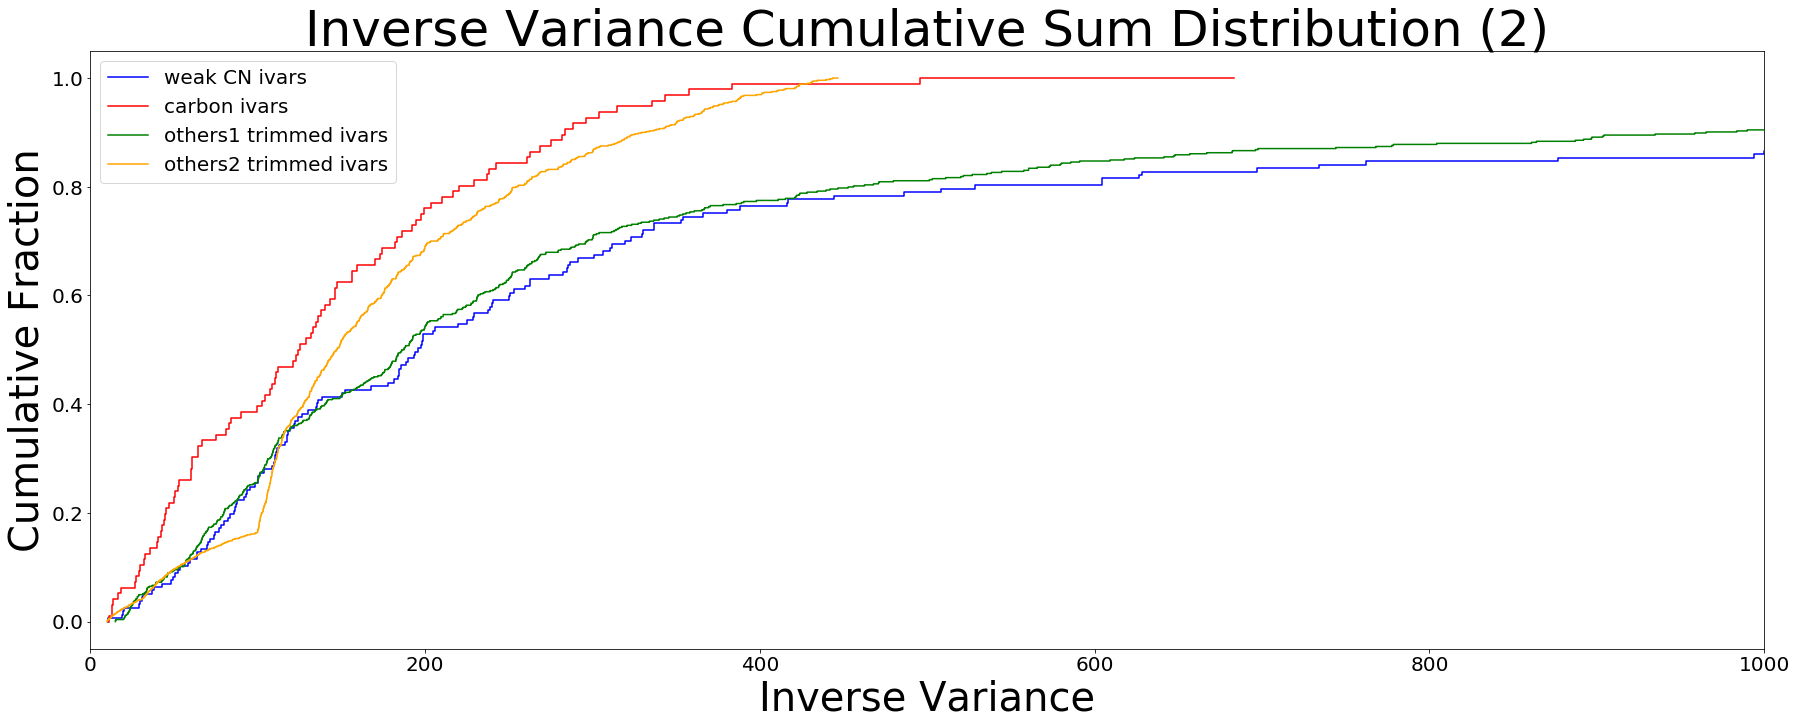

In [66]:
#making unbinned cumulative distribution plots, based on a step of 1/N for each data point
#step 1: sorting the data
wNm_sortedMeds = np.sort(wNm_ivarMeds)
carb_sortedMeds = np.sort(carbon_ivarMeds)
kphO1_sortedMeds = np.sort(kphTrimmedOthers1_ivarMeds)
kphO2select_sortedMeds = np.sort(np.array(kphTrimmedOthers2_ivarMeds))


#step 2: make the cumulative sum as a step function with a step size of 1 / N (where N is set size), so all samples' y's end at 1
plt.step(wNm_sortedMeds, np.linspace(0, 1, len(wNm_sortedMeds)), color = 'blue', label = "weak CN ivars")
plt.step(carb_sortedMeds, np.linspace(0, 1, len(carb_sortedMeds)),  color = 'red', label = "carbon ivars")
plt.step(kphO1_sortedMeds,np.linspace(0, 1, len(kphO1_sortedMeds)), color = 'green', label = "others1 trimmed ivars")
plt.step(kphO2select_sortedMeds,np.linspace(0, 1, len(kphO2select_sortedMeds)), color = 'orange', label = "others2 trimmed ivars")

#formatting the chart so that it is easy to read
plt.title("Inverse Variance Cumulative Sum Distribution (2)", size = 50) 
plt.xlabel("Inverse Variance", size = 40)
plt.ylabel("Cumulative Fraction", size = 40)
plt.legend(fontsize = 20)
plt.xlim(0, 1000)
plt.rcParams['figure.figsize'] = 30, 11
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.savefig('ivarDistr_cumulativeSum_others1+2_shaped_final.png')
plt.show()

# --------------------------------------------------------------------

# Rachel and Antara's Analysis

# Method 1 - Unmodified Template
Calculates the "score" of a star's normalized spectrum by comparing that to a normalized template spectrum and applying a formula that adds up and weights the differences between the two spectra. Note that in method 1, the template spectrum is unmodified.

Note: This code was adapted from 2.5.3 and 2.6.1 and edited to calculated scores for a Weak CN template instead of Carbon.

In [67]:
#creates a function that calculates the score (a measure of the difference between two spectra) for a certain star's spectrum compared to a certain template spectrum
#note that the input spectra and ivars must be already sliced and normalized
def getScore(templateSpec, scienceSpec, ivars):
    '''
    templateSpec: a Numpy array containing the flux values of the coadded template spectrum
    scienceSpec: a Numpy array containing the flux values at each wavelength of the normalized spectrum for a specific star
    ivars: a Numpy array containing the normalized ivar values at each wavelength of the spectrum for a specific star
    
    Returns finalScore, a float representing the similarity between the two spectra. A lower score indicates greater similarity and a higher score indicates lower similarity
    Note that spectra that cannot be normalized will not have a score associated with them. The function returns a NaN as the score for these spectra
    '''
    templateSpec_list = templateSpec.tolist()
    scienceSpec_list = scienceSpec[~np.isnan(scienceSpec)].tolist()
    if scienceSpec_list == []:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan
    else:
        summedScore = 0
        for wv in range(len(templateSpec_list)):
            score = ((scienceSpec[wv] - templateSpec[wv])**2) * ivars[wv]
            if not np.isnan(score):
                summedScore += score
        summedIvars = 0
        for ivar in ivars:
            if not np.isnan(ivar):
                summedIvars += ivar
        finalScore = (summedScore/summedIvars)**0.5
        return finalScore

#test execution of function
specStar, ivarStar = splashSpecs_dict[19534],splashIvars_dict[19534]
print("Score: " + str(getScore(Wtemplate, specStar, ivarStar)))

Score: 0.38825183880413244


## Part 1: Data Analysis Based on the Full-Range 'W'

Uses a template spectrum based on the wNm (all weak CN) data set. Compares stars to this template with the aim of being able to sort stars into three distinct populations: weak CN, carbon, and normal/other. Main method of analysis is histograms.

Includes Carbon and weak CN template. 

Scores are divided for weak CN stars based on their scores to both templates. The stars were then divided into two templates: strong-weak CN template and weak-weak template. 

Strong-weak CN template - scores < median score to template

Weak-weak CN template - scores > median score to template

## 1.1 Carbon template

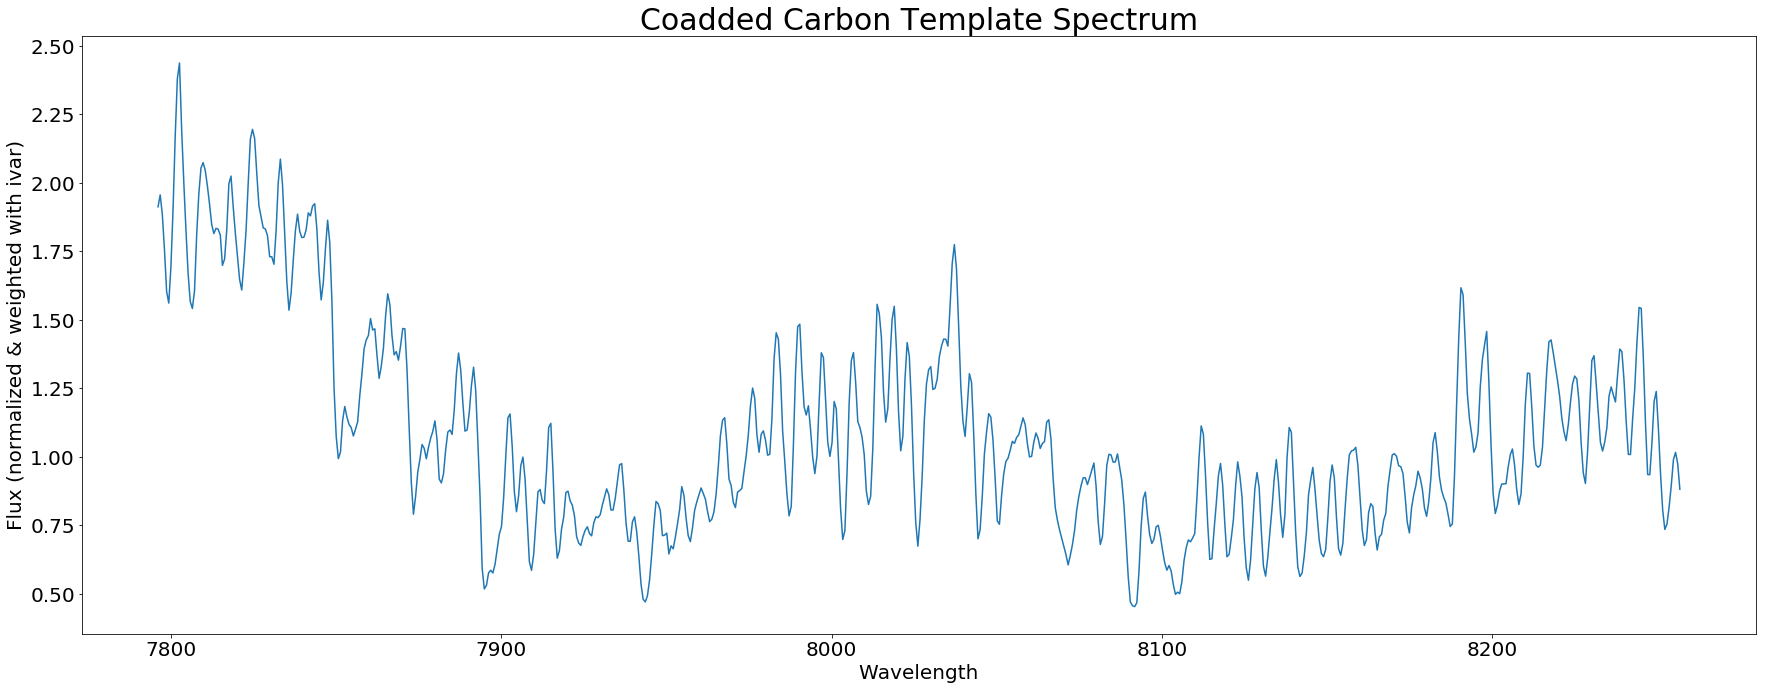

In [68]:
#graphs the limited-range carbon template spectrum 

x = Ctemplate_wv.tolist()
y = Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Carbon Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

### Creating Dictionaries- Unmodified C Template

In [69]:
#creates dictionaries consisting of every star for which a normalized spectrum can be obtained and a score can be calculated
#in these dictionaries, the keys are star indices and the values are the scores associated with those particular stars

#Antara - I think this was deleted, I've rewritten it for now, ignoring kphOthers and weak/marginal
#kphOthers_Cscore_dict, kphTrO1_Cscore_dict, kphTrO2_Cscore_dict  = {}, {}, {},
others_Cscore_dict = {}
flaggedStars_Cscore_dict, wNm_Cscore_dict, carbon_Cscore_dict = {}, {}, {} 
#weak_Cscore_dict, marginal_Cscore_dict = {}, {}

#generating the dictionaries and lists simultaneously
for star in wNm:
    if splashSuccess_dict[star]:
        score1 = getScore(Ctemplate, splashSpecs_dict[star], splashIvars_dict[star])
        wNm_Cscore_dict[star] = score1
        if star in flaggedStars_list:
            flaggedStars_Cscore_dict[star] = score1
        #if star in weaks:
            #weak_Cscore_dict[star] = score1
        #else: #the star is a marginal CN star
            #marginal_Cscore_dict[star] = score1
for star in others: 
    if splashSuccess_dict[star]:
        score2 = getScore(Ctemplate, splashSpecs_dict[star], splashIvars_dict[star])
        others_Cscore_dict[star] = score2
        if star in flaggedStars_list:
            flaggedStars_Cscore_dict[star] = score2
        #if star in keckPhotoOthers_set:    
         #   kphOthers_Cscore_dict[star] = score2
          #  if star in kphTrimmedOthers1: #based on others1
           #     kphTrO1_Cscore_dict[star] = score2
            #if star in kphTrimmedOthers2: #based on others1
             #   kphTrO2_Cscore_dict[star] = score2
for star in allcarbon:
    if splashSuccess_dict[star]:
        score3 = getScore(Ctemplate, splashSpecs_dict[star], splashIvars_dict[star])
        carbon_Cscore_dict[star] = score3
        if star in flaggedStars_list:
            flaggedStars_Cscore_dict[star] = score3

In [70]:
#print (st.mean(carbon_Cscore_dict.values()))


In [80]:
#metadata: stats used to see how the data fits 
#Rach-changed to Cscore_
print(st.mean(carbon_Cscore_dict.values()), st.mean(wNm_Cscore_dict.values()))
print(st.median(carbon_Cscore_dict.values()), st.median(wNm_Cscore_dict.values()))

0.2087194079953538 0.3332734166481244
0.1679587405780741 0.32875850932757067


### Dividing score - Carbon template

In [81]:
#Create a function that divides the weak CN stars into two templates based on score to C template
# Strong weak CN stars are stars with low scores (score < median)(closest to the science template)
# Weak weak CN stars are stars with high scores (score >= median)(furthest to the science template)

strong_wCN_Cscore_dict= {} #Antara - name changed to _Cscore_dict to avoid confusion with the weak CN score dictionary
weak_wCN_Cscore_dict= {}
wCN_Cscore_dict = {}

for star,score1 in wNm_Cscore_dict.items():
    
    if score1 >= st.median(wNm_Cscore_dict.values()):
        weak_wCN_Cscore_dict[star] = score1
            
    else:
        strong_wCN_Cscore_dict[star] = score1
        
    if score1:
        wCN_Cscore_dict[star] = score1

In [82]:
#double checking the data

print ('length of strong_wCN_Cscore_dict = ' + str( len(strong_wCN_Cscore_dict)))
print ('length of weak_wCN_Cscore_dict = ' + str( len(weak_wCN_Cscore_dict)))

print('min of strong_wCN_Cscore_dict = ' + str( min(strong_wCN_Cscore_dict.values())))
print('max of strong_wCN_Cscore_dict = '+ str( max(strong_wCN_Cscore_dict.values())))

print('min of weak_wCN_Cscore_dict = ' + str(min(weak_wCN_Cscore_dict.values())))
print('min of weak_wCN_Cscore_dict = ' + str( max(weak_wCN_Cscore_dict.values())))

length of strong_wCN_Cscore_dict = 79
length of weak_wCN_Cscore_dict = 79
min of strong_wCN_Cscore_dict = 0.2692198607884651
max of strong_wCN_Cscore_dict = 0.328683701756834
min of weak_wCN_Cscore_dict = 0.3288333168983073
min of weak_wCN_Cscore_dict = 0.48719902759439154


In [83]:
#create the strong wCN and weak wCN templates using getTempSpec

#Rach -changed everything to _Ctemplate
strong_wCN_Ctemplate_wv, strong_wCN_Ctemplate, strong_wCN_Ctemplate_ivar = getTempSpec(strong_wCN_Cscore_dict)
weak_wCN_Ctemplate_wv, weak_wCN_Ctemplate, weak_wCN_Ctemplate_ivar = getTempSpec(weak_wCN_Cscore_dict)

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.


### Weak WCN Ctemplate (stars > median score)

Graphs the weak-weak CN template that was created based on the scores of stars compared to the carbon template. 
Where scores > median score.

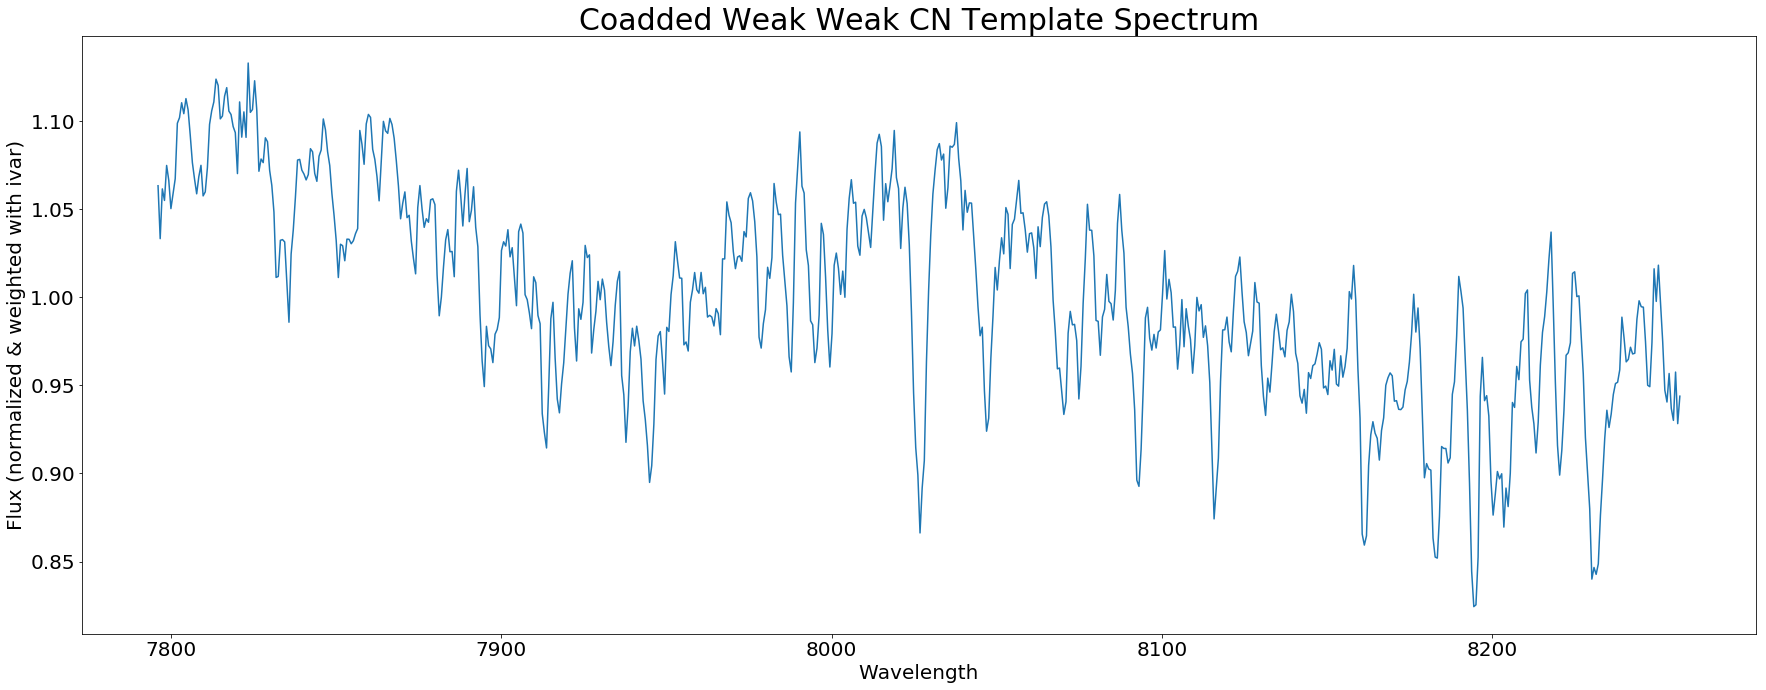

In [84]:
#graphs the limited-range weak weak CN template calculated from scores to C template

x = weak_wCN_Ctemplate_wv.tolist()
y = weak_wCN_Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Weak Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

### Strong WCN Ctemplate (stars <median score)

Graphs the strong-weak CN template that was created based on the scores of stars compared to the carbon template.
Where scores > median score.

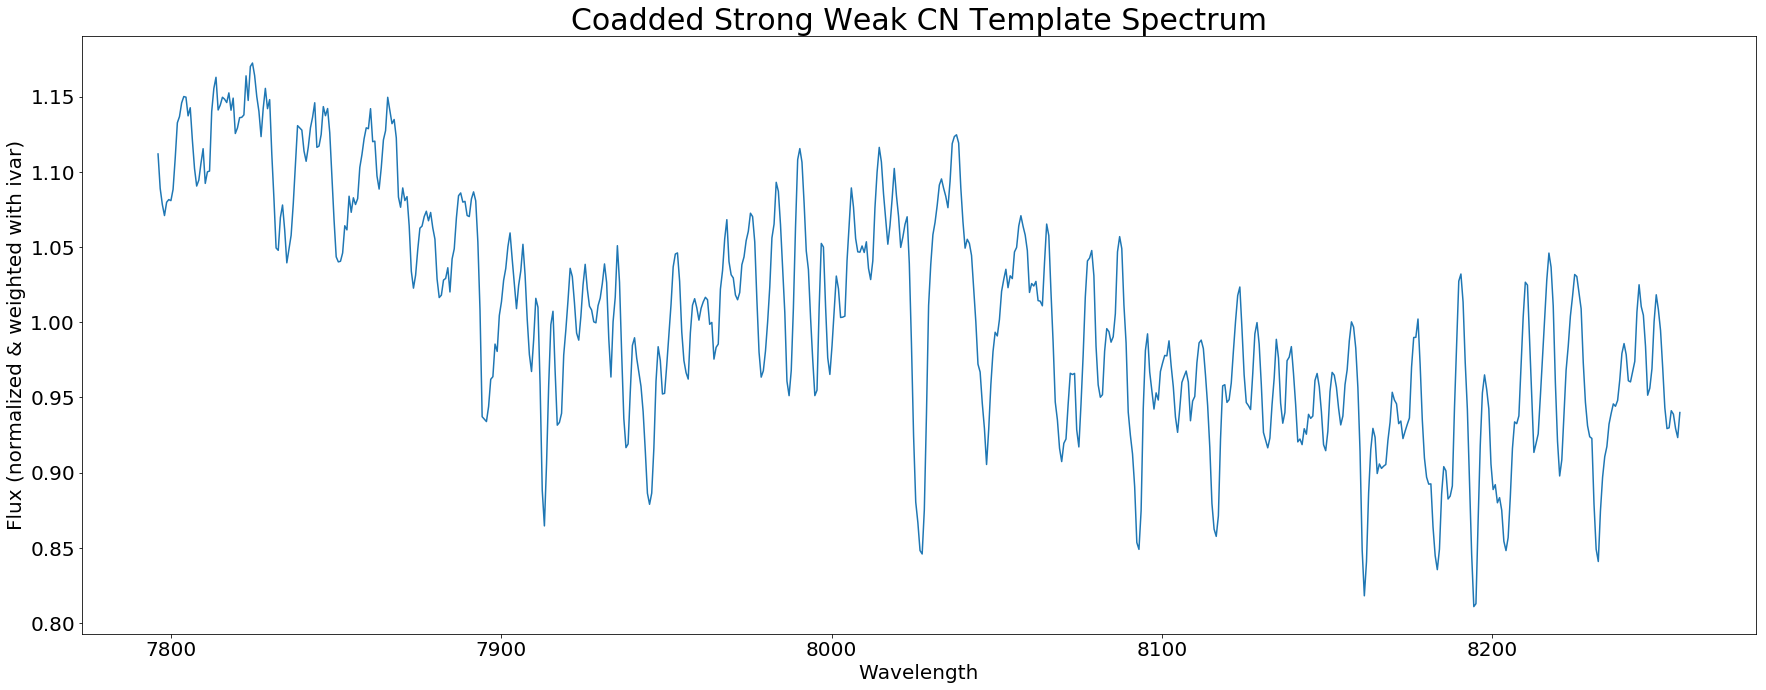

In [85]:
#graphs the limited-range weak weak CN template calculated from scores to C template

x = strong_wCN_Ctemplate_wv.tolist()
y = strong_wCN_Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Strong Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

In [86]:
#double checking the data

print ('length of strong_wCN_Cscore_dict = ' + str( len(strong_wCN_Cscore_dict)))
print ('length of weak_wCN_Cscore_dict = ' + str( len(weak_wCN_Cscore_dict)))

print('min of strong_wCN_Cscore_dict = ' + str( min(strong_wCN_Cscore_dict.values())))
print('max of strong_wCN_Cscore_dict = '+ str( max(strong_wCN_Cscore_dict.values())))

print('min of weak_wCN_Cscore_dict = ' + str(min(weak_wCN_Cscore_dict.values())))
print('min of weak_wCN_Cscore_dict = ' + str( max(weak_wCN_Cscore_dict.values())))

length of strong_wCN_Cscore_dict = 79
length of weak_wCN_Cscore_dict = 79
min of strong_wCN_Cscore_dict = 0.2692198607884651
max of strong_wCN_Cscore_dict = 0.328683701756834
min of weak_wCN_Cscore_dict = 0.3288333168983073
min of weak_wCN_Cscore_dict = 0.48719902759439154


## 1.2 Weak CN template 

### Creating Dictionaries - Unmodified W Template

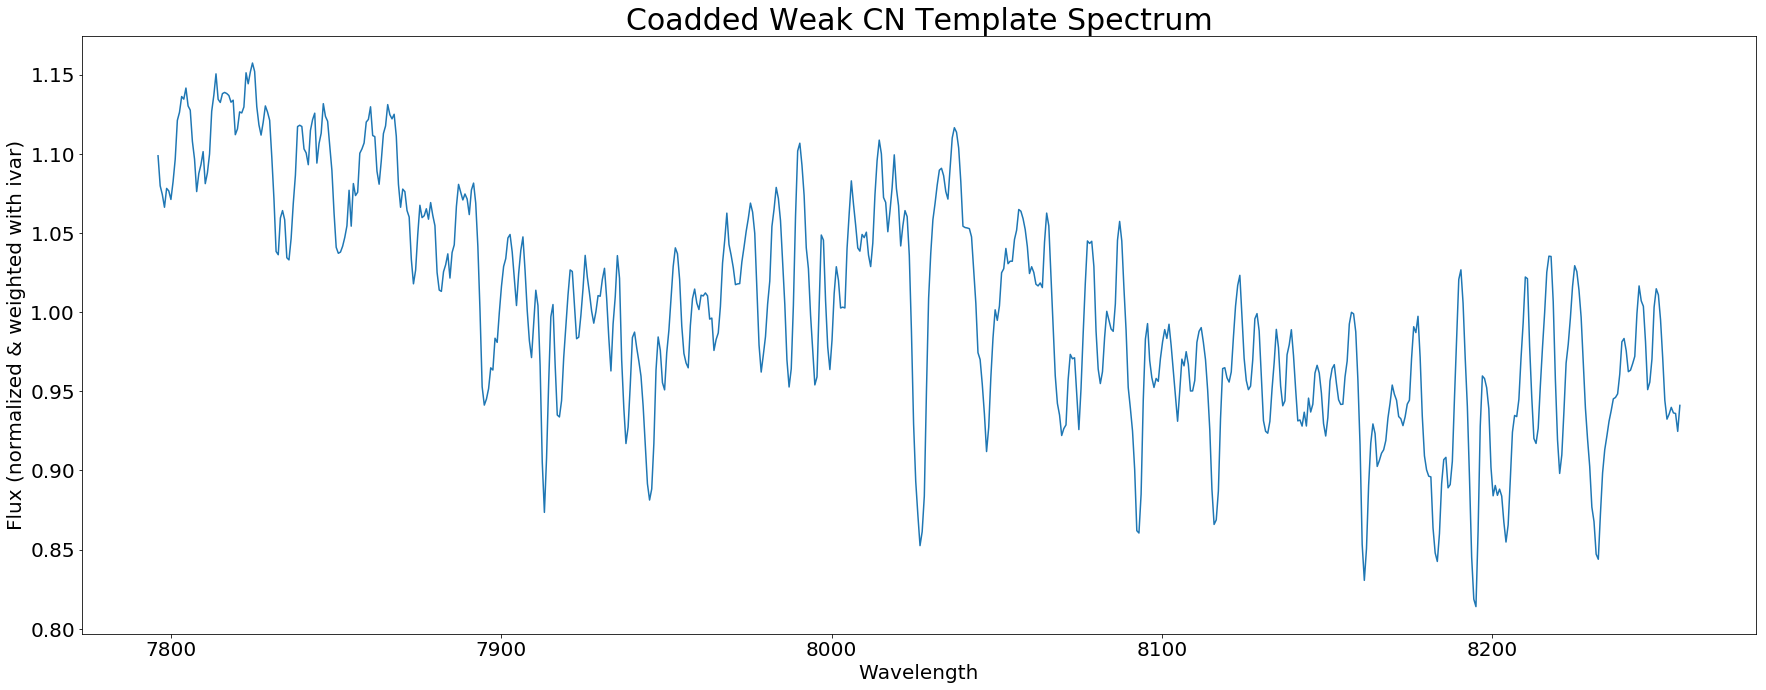

In [87]:
#graphs the limited-range weak CN template spectrum 

x = Wtemplate_wv.tolist()
y = Wtemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

In [88]:
#creates dictionaries consisting of every star for which a normalized spectrum can be obtained and a score can be calculated
#in these dictionaries, the keys are star indices and the values are the scores associated with those particular stars
kphOthers_score_dict, kphTrO1_score_dict, kphTrO2_score_dict, others_score_dict = {}, {}, {}, {}
flaggedStars_score_dict, wNm_score_dict, carbon_score_dict = {}, {}, {} 
weak_score_dict, marginal_score_dict = {}, {}

#generating the dictionaries and lists simultaneously
for star in wNm:
    if splashSuccess_dict[star]:
        score1 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        wNm_score_dict[star] = score1
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score1
        if star in weaks:
            weak_score_dict[star] = score1
        else: #the star is a marginal CN star
            marginal_score_dict[star] = score1
for star in others: 
    if splashSuccess_dict[star]:
        score2 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        others_score_dict[star] = score2
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score2
        if star in keckPhotoOthers_set:    
            kphOthers_score_dict[star] = score2
            if star in kphTrimmedOthers1: #based on others1
                kphTrO1_score_dict[star] = score2
            if star in kphTrimmedOthers2: #based on others1
                kphTrO2_score_dict[star] = score2
for star in allcarbon:
    if splashSuccess_dict[star]:
        score3 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        carbon_score_dict[star] = score3
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score3

In [89]:
#metadata: stats used to see how the data fits the weak CN hypothesis
print(st.mean(carbon_score_dict.values()), st.mean(wNm_score_dict.values()), st.mean(kphOthers_score_dict.values()))
print(st.median(carbon_score_dict.values()), st.median(wNm_score_dict.values()), st.median(kphOthers_score_dict.values()))

0.3429099765967884 0.09356613507108294 0.36824256218809975
0.33912972343621417 0.0804199913913379 0.2626052191793642


### Dividing Score - weak CN template

In [90]:
#Create a function that divides the weak CN stars into two templates based on score to Weak CN template
# Strong weak CN stars are stars with low scores (score < median)(closest to the science template)
# Weak weak CN stars are stars with high scores (score >= median)(furthest to the science template)

#wCN -> weak CN
strong_wCN_score_dict= {} #Antara - changed name to _score_dict to match with others
weak_wCN_score_dict= {}
wCN_score_dict = {}

for star,score1 in wNm_score_dict.items():
    
    if score1 >= st.median(wNm_score_dict.values()):
        weak_wCN_score_dict[star] = score1
            
    else:
        strong_wCN_score_dict[star] = score1
    
    if score1:
        wCN_score_dict[star]=score1
    



In [91]:
#double checking the data

#length of the two dictionaries
print ('length of strong_wCN_score_dict = ' + str( len(strong_wCN_score_dict)))
print ('length of weak_wCN_score_dict = ' + str( len(weak_wCN_score_dict)))

print('min of strong_wCN_score_dict = ' + str( min(strong_wCN_score_dict.values())))
print('max of strong_wCN_score_dict = '+ str( max(strong_wCN_score_dict.values())))

print('min of weak_wCN_score_dict = ' + str(min(weak_wCN_score_dict.values())))
print('min of weak_wCN_score_dict = ' + str( max(weak_wCN_score_dict.values())))

length of strong_wCN_score_dict = 79
length of weak_wCN_score_dict = 79
min of strong_wCN_score_dict = 0.024398065226028835
max of strong_wCN_score_dict = 0.08041040229949067
min of weak_wCN_score_dict = 0.08042958048318513
min of weak_wCN_score_dict = 0.3931751988419218


In [92]:
#create the strong wcn and weak wcn templates using getTempSpec
strong_wCN_template_wv, strong_wCN_template, strong_wCN_template_ivar = getTempSpec(strong_wCN_score_dict)
weak_wCN_template_wv, weak_wCN_template, weak_wCN_template_ivar = getTempSpec(weak_wCN_score_dict)


Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.


### Weak WCN template (stars > median score)

Graphs the weak-weak CN template that was created based on the scores of stars compared to the weak CN template. Where scores > median score.

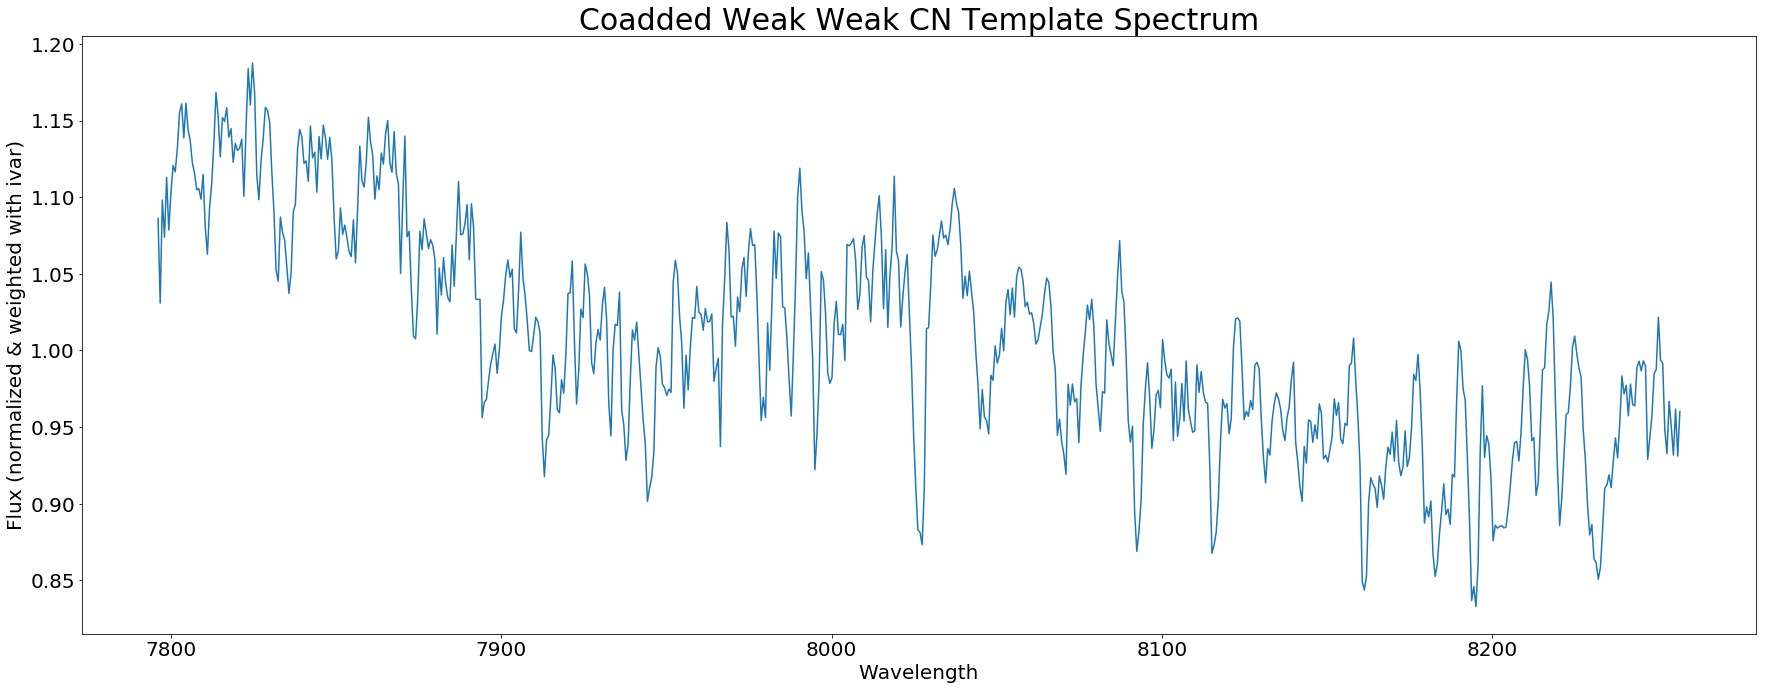

In [93]:
#graphs the Weak-Weak CN template 
#High score Weak CN stars when compared to Weak CN template

x = weak_wCN_template_wv.tolist()
y = weak_wCN_template.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Weak Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

### Strong WCN template (stars <median score)

Graphs the strong-weak CN template that was created based on the scores of stars compared to the weak CN template. Where scores < median score.

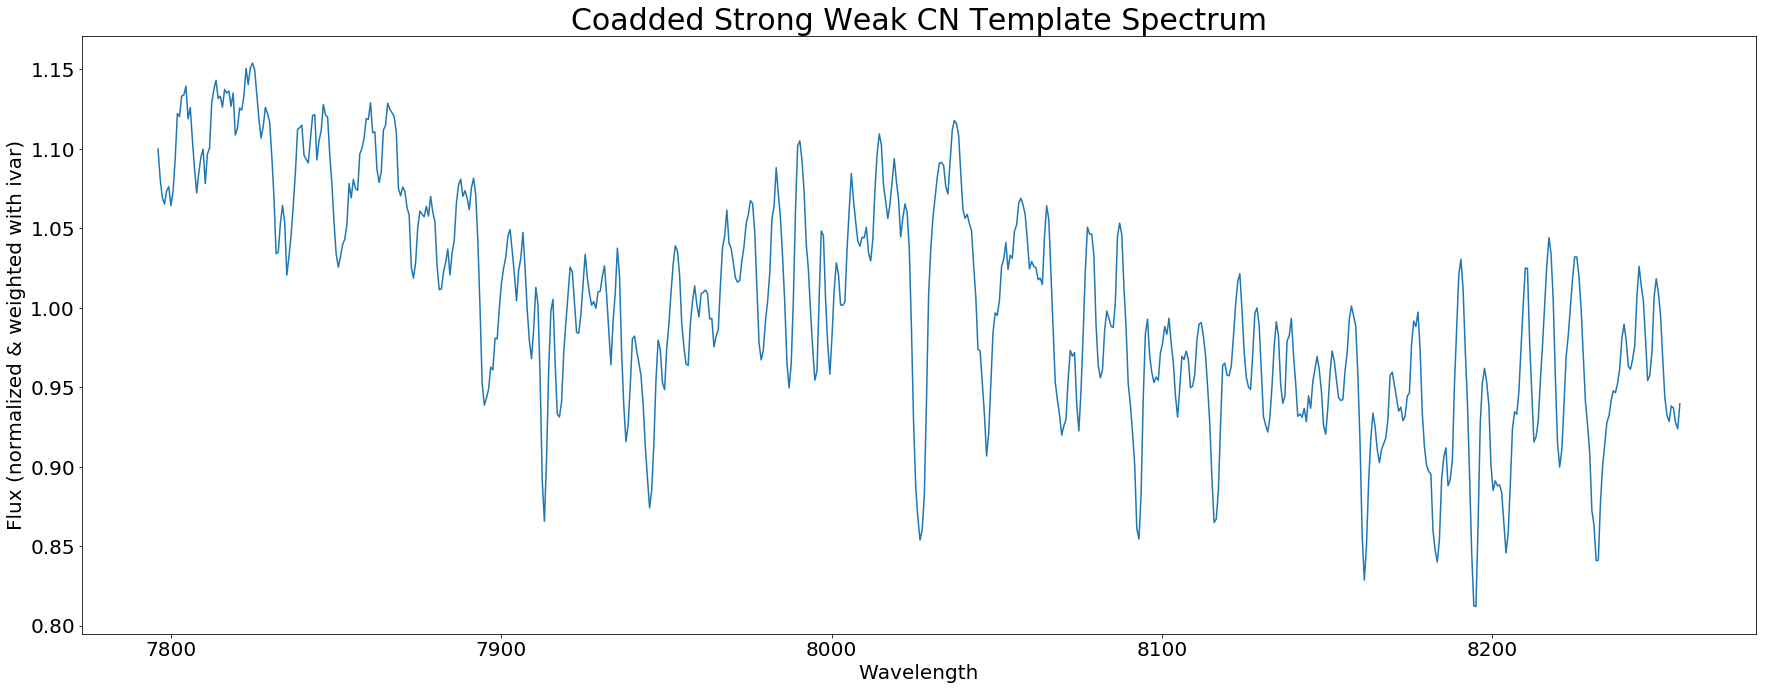

In [94]:
#graphs the Strong-Weak CN template 
#low score Weak CN stars when compared to Weak CN template

x = strong_wCN_template_wv.tolist()
y = strong_wCN_template.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Strong Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

## 1.3 Score Histograms 

### 1.3.1 Score histograms to weak CN Template

Graphs the scores of all stars when compared to the Weak CN template.

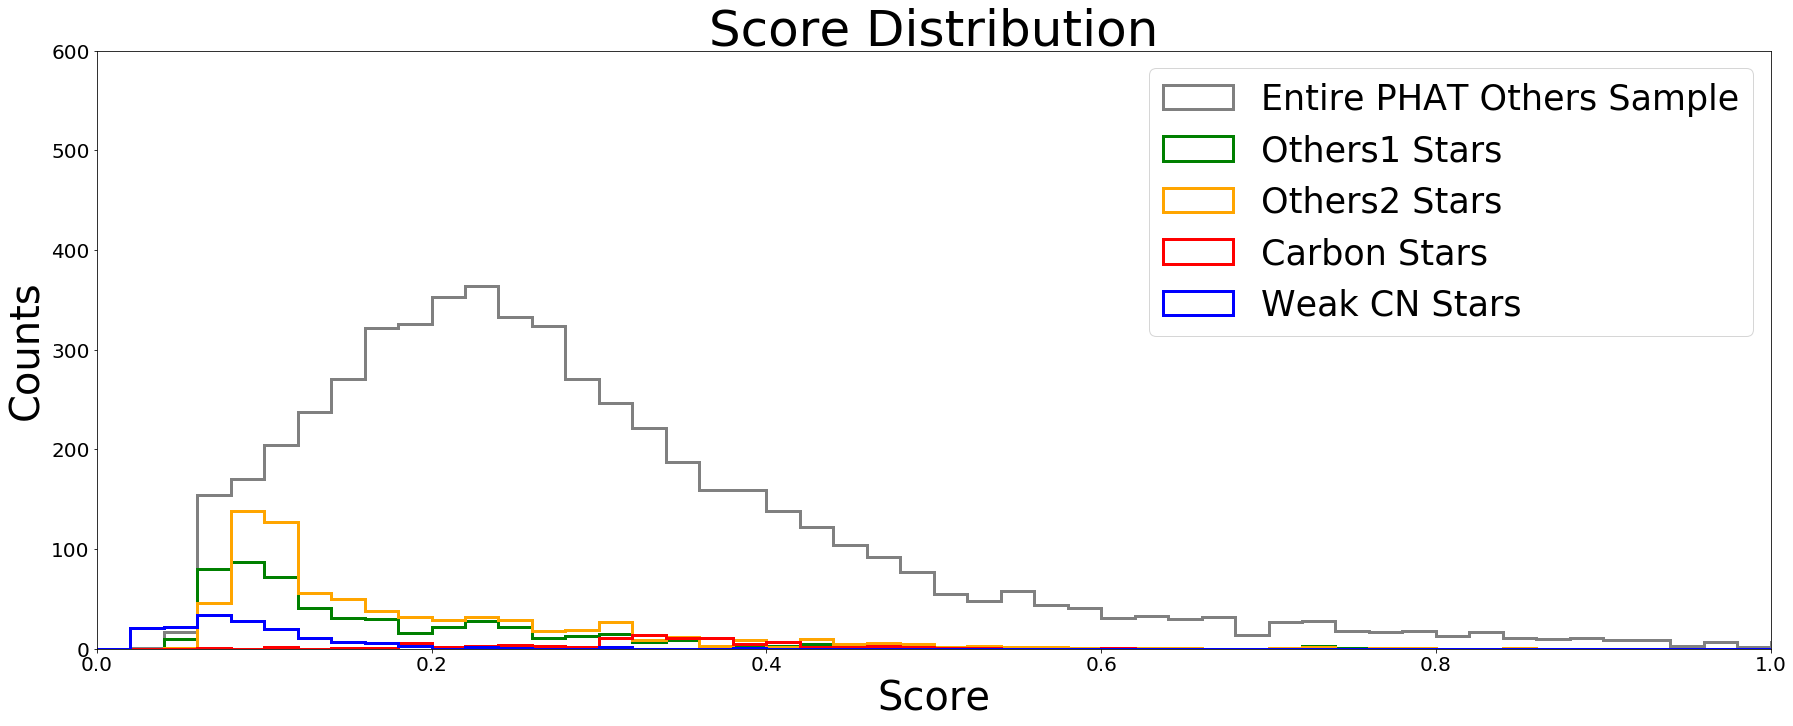

In [95]:
#Plots scores of all stars to the Weak CN template

#creates a histogram of the score distributions of valid, able-to-be-normalized stars in SPLASH
binList = np.arange(0, 10, 0.02)

defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values()],
           binList, ['gray','g','orange','r','b'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars"],
           ["Score Distribution", "Score", "Counts"], xLim=(0,1),yLim=(0,600), step=3)
#entire PHAT others sample is "ghost" sample to show differences


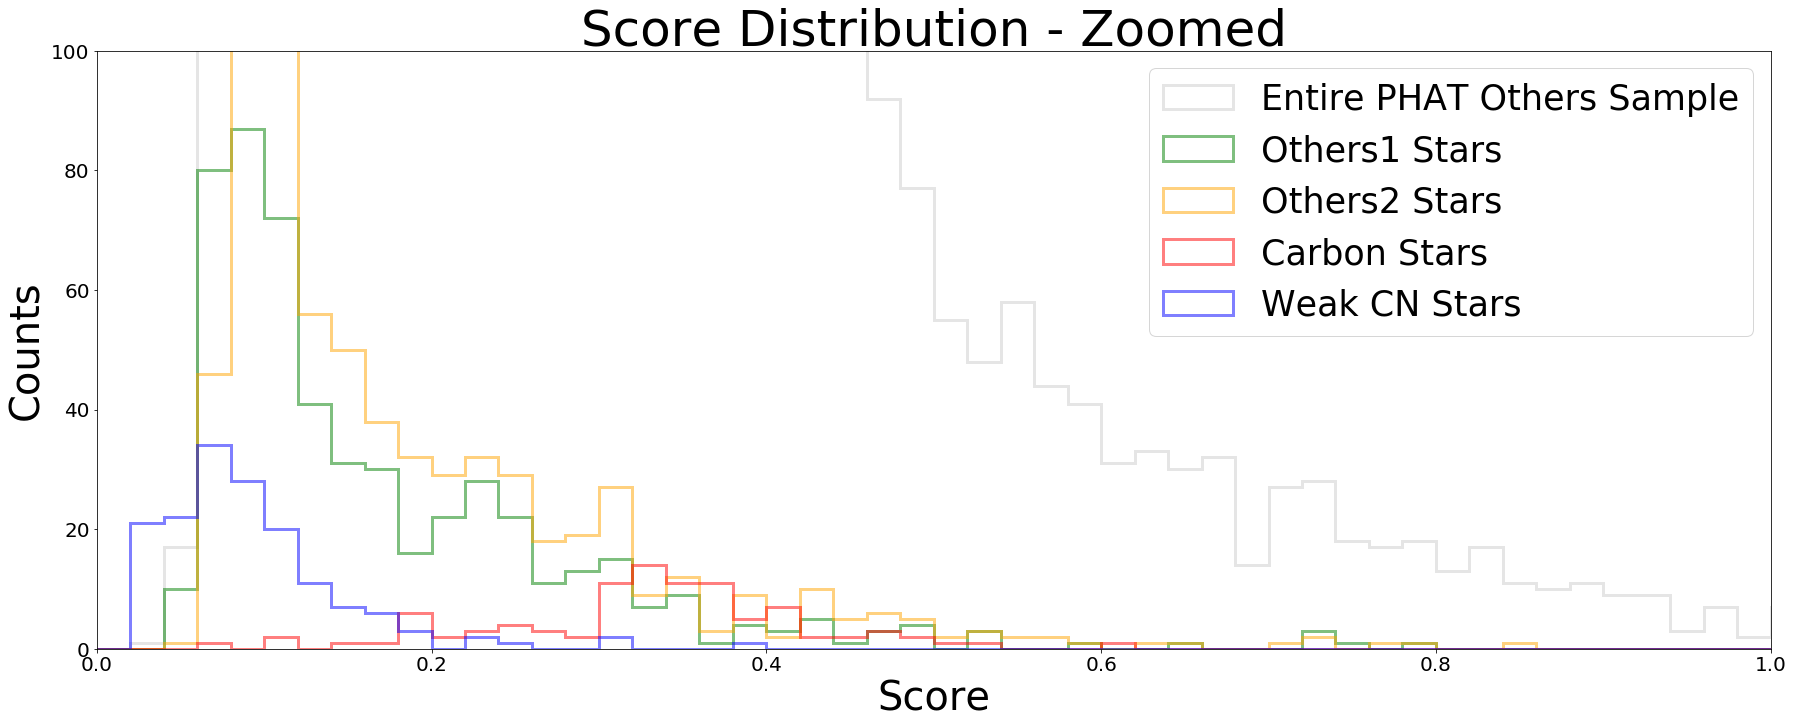

In [96]:
#Plots scores of all stars to the Weak CN template

#same histogram as above, just zoomed in on the bottom corner so trends in the weak CN and carbon stars can be observed
#creates a histogram of the score distributions of valid, able-to-be-normalized stars in SPLASH
binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values()],
           binList, ['gray','g','orange','r','b'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5), step = 3)


### Score histogram for strong-weak CN

Graphs the scores of all stars when compared to the Weak CN template. Emphasizes the strong-weak CN scores.

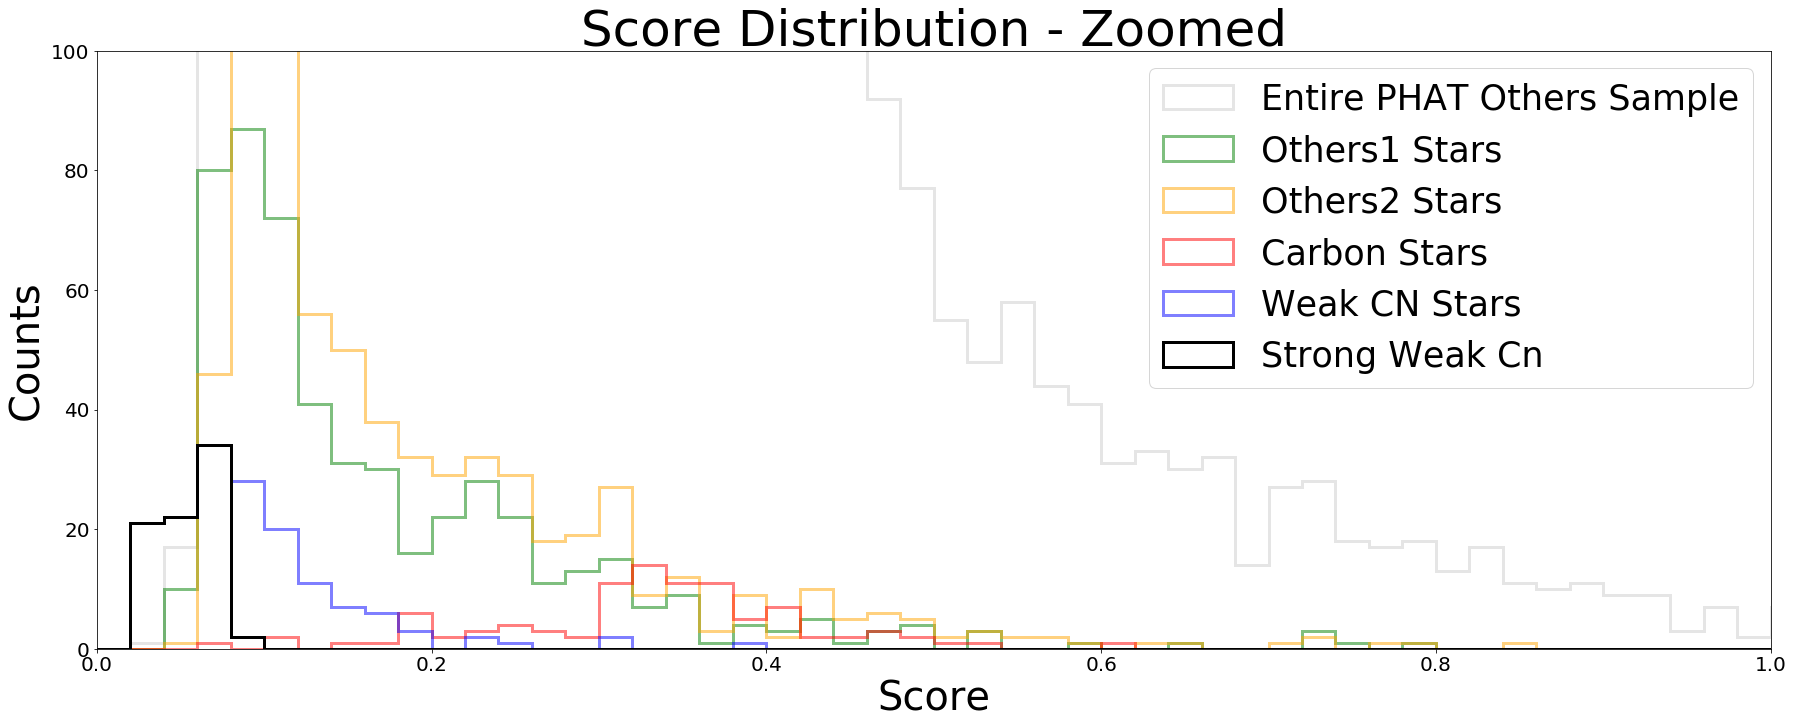

In [97]:
#Plots scores of all stars to the Weak CN template
#emphasizes the scores of strong weak CN stars from Weak CN template

binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values(),strong_wCN_score_dict.values()],
           binList, ['gray','g','orange','r','b','black'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars","Strong Weak Cn"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5,1.0), step = 3)


### Score histogram of weak-weak CN 

Graphs the scores of all stars when compared to the Weak CN template. Emphasizes the weak-weak CN scores.

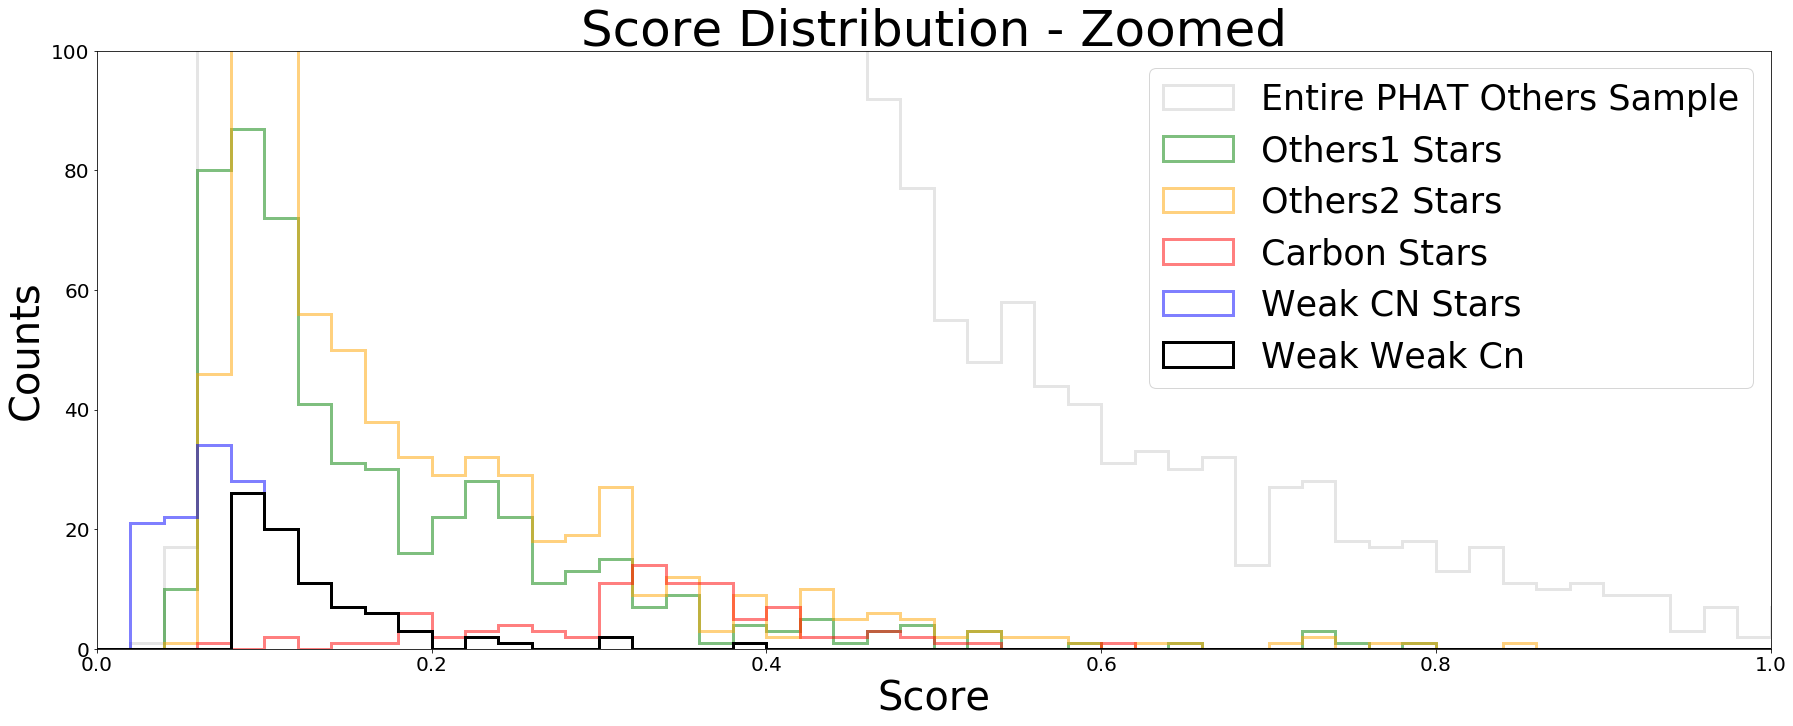

In [98]:
#Plots scores of all stars to the Weak CN template
#emphasizes the scores of weak weak CN stars from Weak CN template

binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values(),weak_wCN_score_dict.values()],
           binList, ['gray','g','orange','r','b','black'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars","Weak Weak Cn"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5,1.0), step = 3)


### 1.3.2 Score histograms to carbon template

Graphs the scores of all stars when compared to the carbon template.

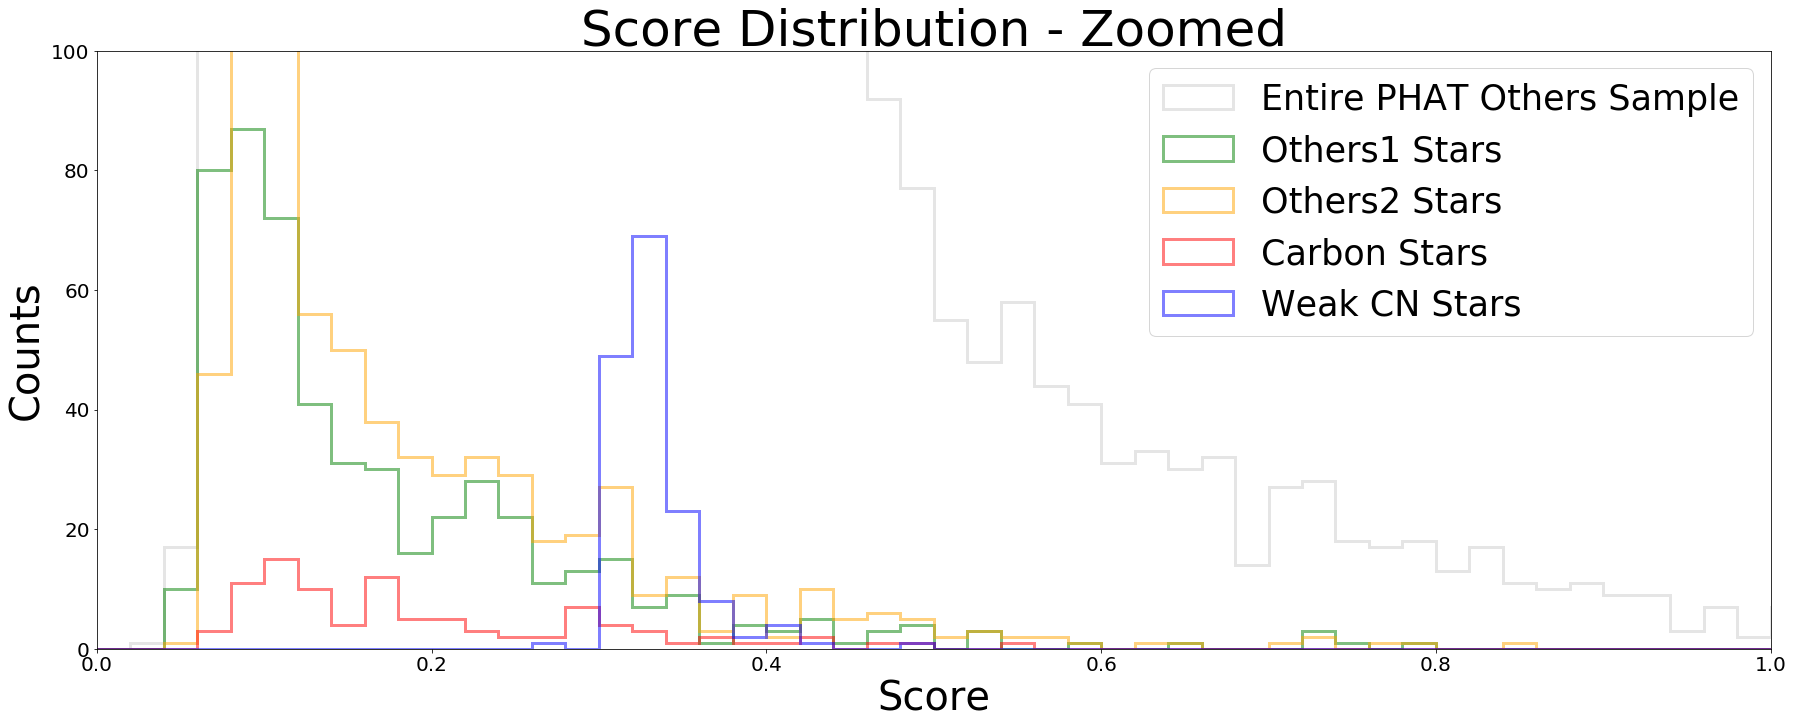

In [113]:
#Plots scores of all stars to the Carbon template

binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_Cscore_dict.values(),wNm_Cscore_dict.values()],
           binList, ['gray','g','orange','r','b'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5), step = 3)


### Score histogram for strong-weak CN

Graphs the scores of all stars when compared to the carbon template. Emphasizes the strong-weak CN scores.

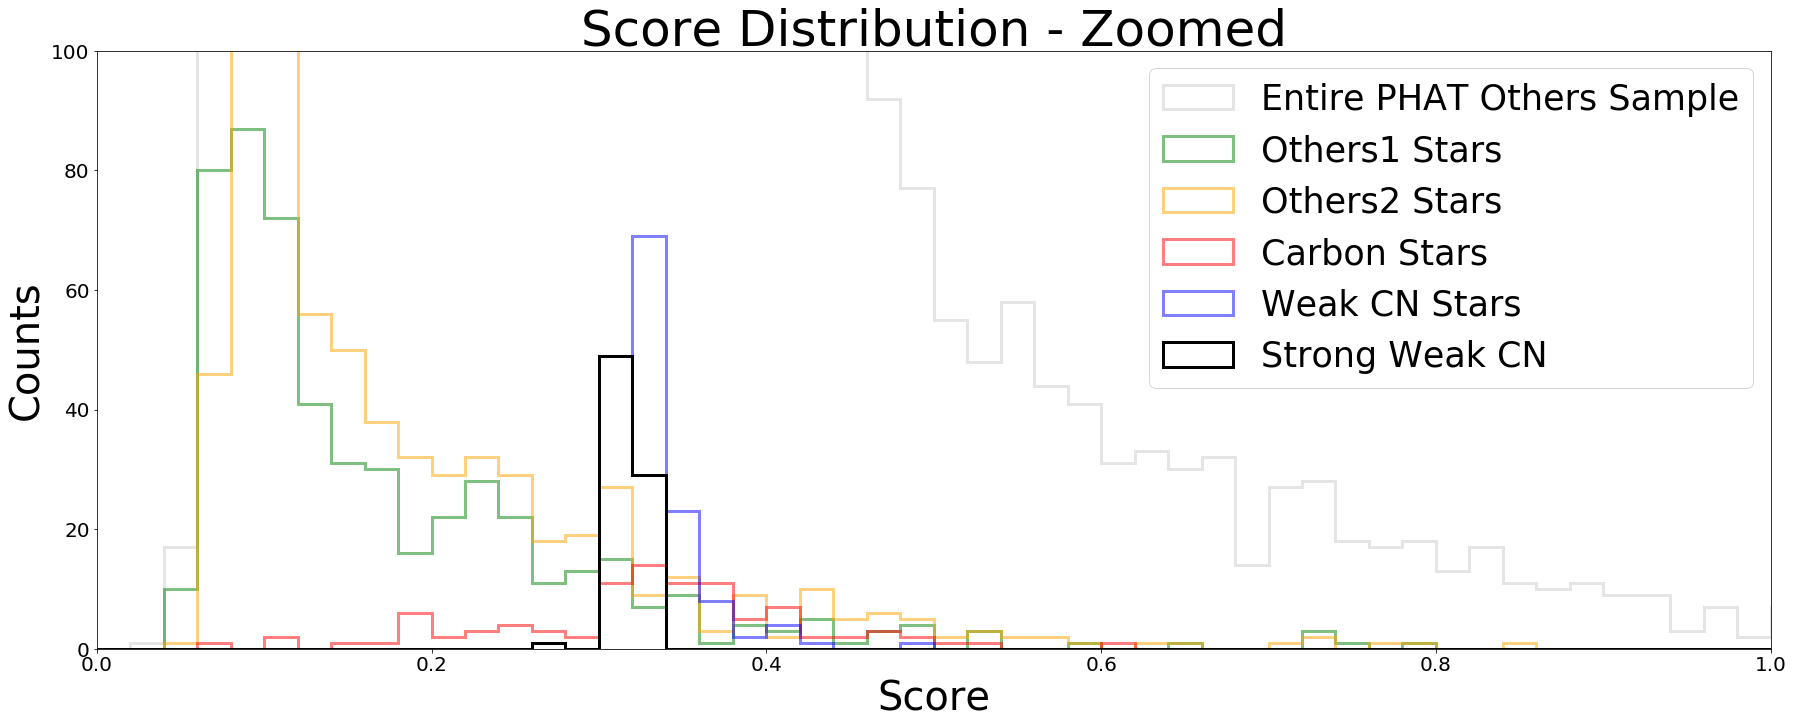

In [114]:
#Plots scores of all stars to the Carbon template
#emphasizes the scores of strong weak CN stars calculated from carbon template

binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_Cscore_dict.values(),strong_wCN_Cscore_dict.values()],
           binList, ['gray','g','orange','r','b','black'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars","Strong Weak CN"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5,1.0), step = 3)


### Score histogram of weak-weak CN

Graphs the scores of all stars when compared to the carbon template. Emphasizes the weak-weak CN scores.

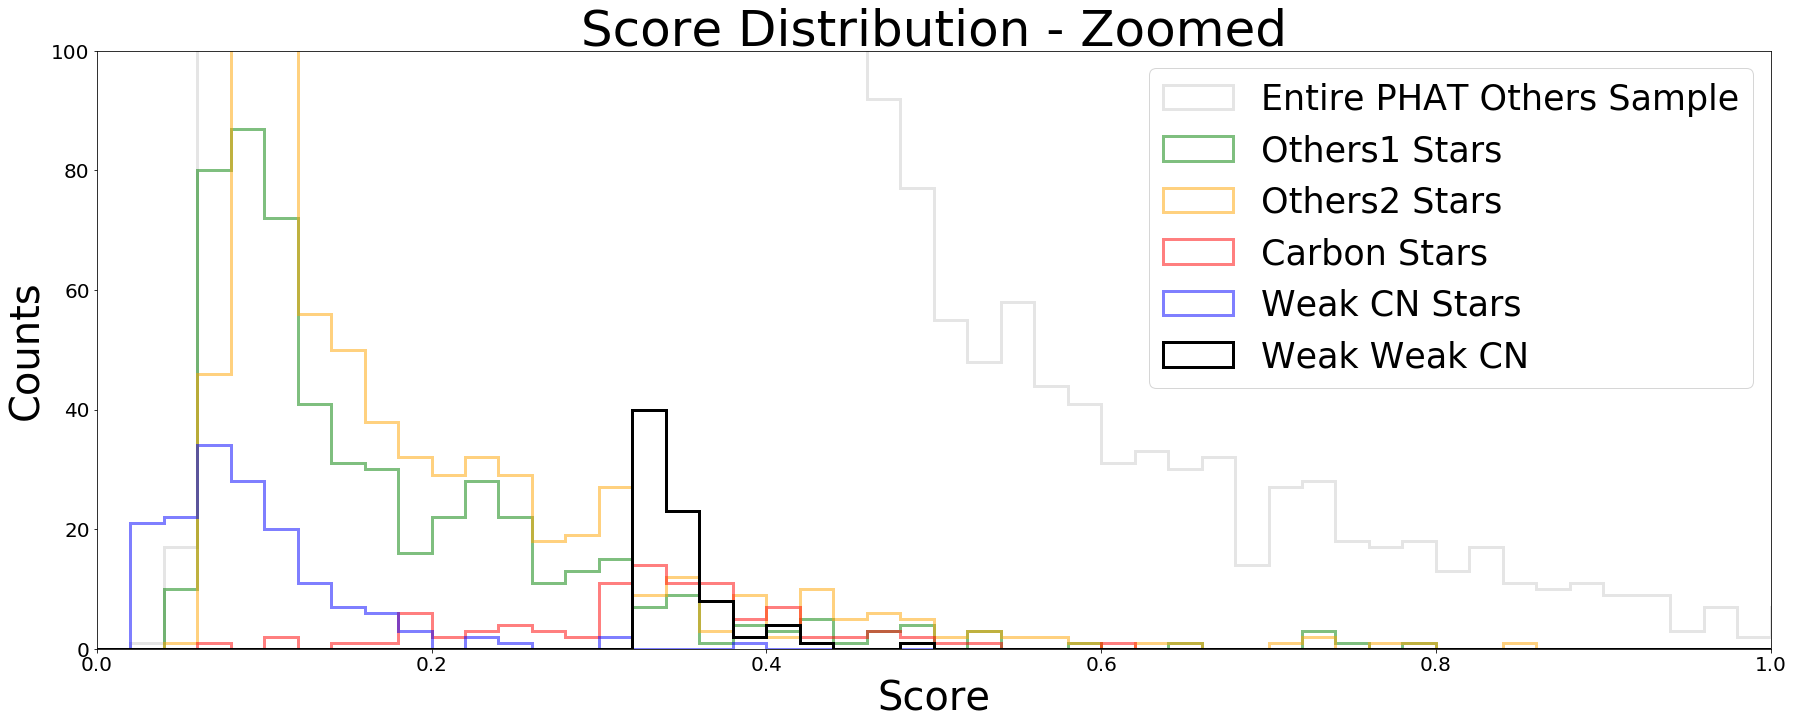

In [115]:
#Plots scores of all stars to the Carbon template
#emphasizes the scores of weak weak CN stars calculated from carbon template

binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values(),weak_wCN_Cscore_dict.values()],
           binList, ['gray','g','orange','r','b','black'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars","Weak Weak CN"],
           ["Score Distribution - Zoomed", "Score", "Counts"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5,1.0), step = 3)


## 1.4 Comparing Strong and Weak WCN

### Comparing Weak wCN  from C and W templates

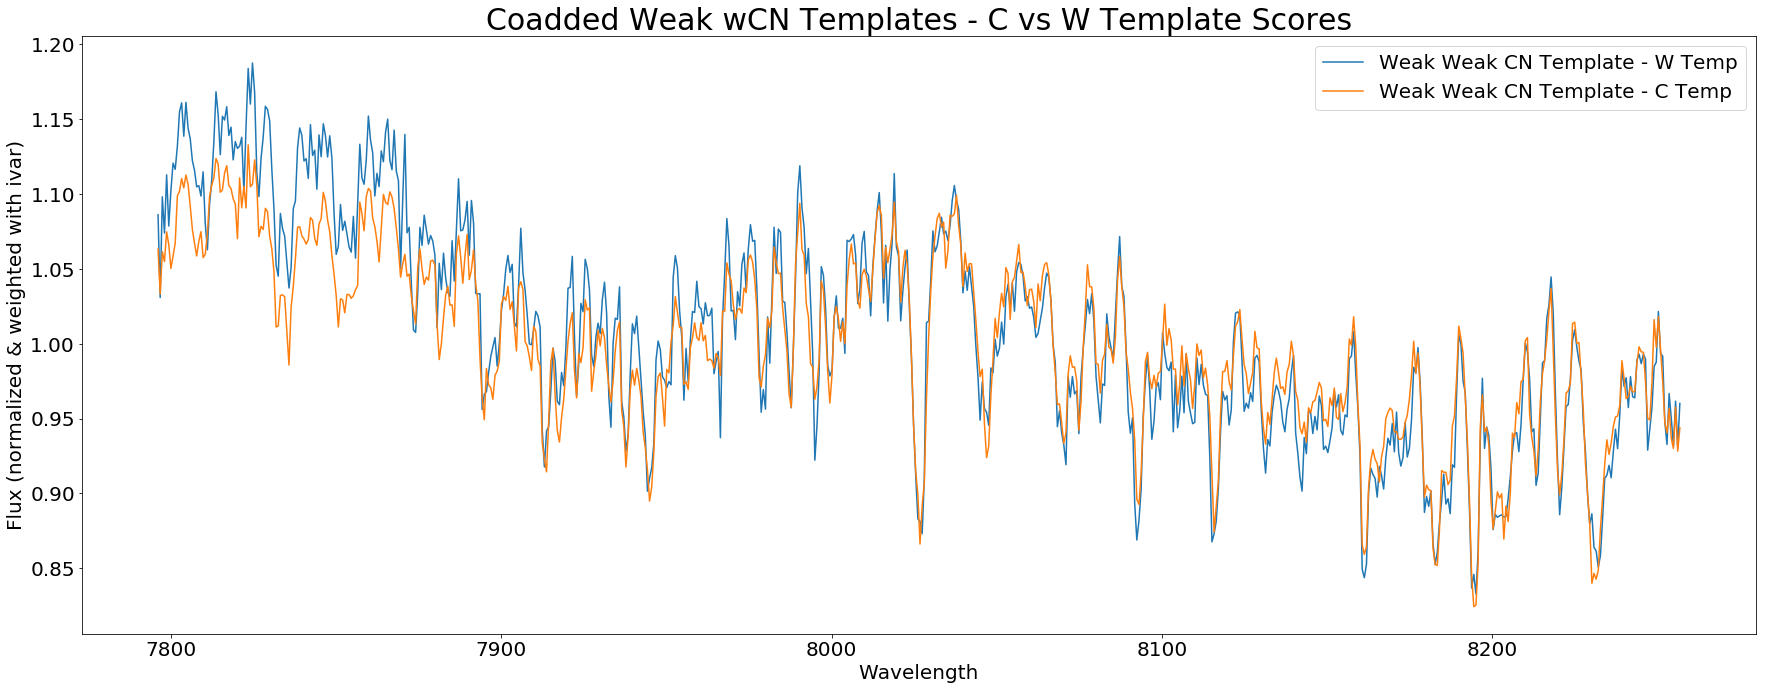

In [116]:
#plotted the Weak Weak CN templates that were calculated from the scores to the Carbon vs Weak CN template

x1 = weak_wCN_template_wv.tolist()
y1 = weak_wCN_template.tolist()
x2 = weak_wCN_Ctemplate_wv.tolist()
y2 = weak_wCN_Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x1, y1,label='Weak Weak CN Template - W Temp')
plt.plot(x2,y2,label='Weak Weak CN Template - C Temp')
plt.title("Coadded Weak wCN Templates - C vs W Template Scores", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.legend(fontsize=20)
plt.show()

### Comparing Strong wCN  from C and W templates

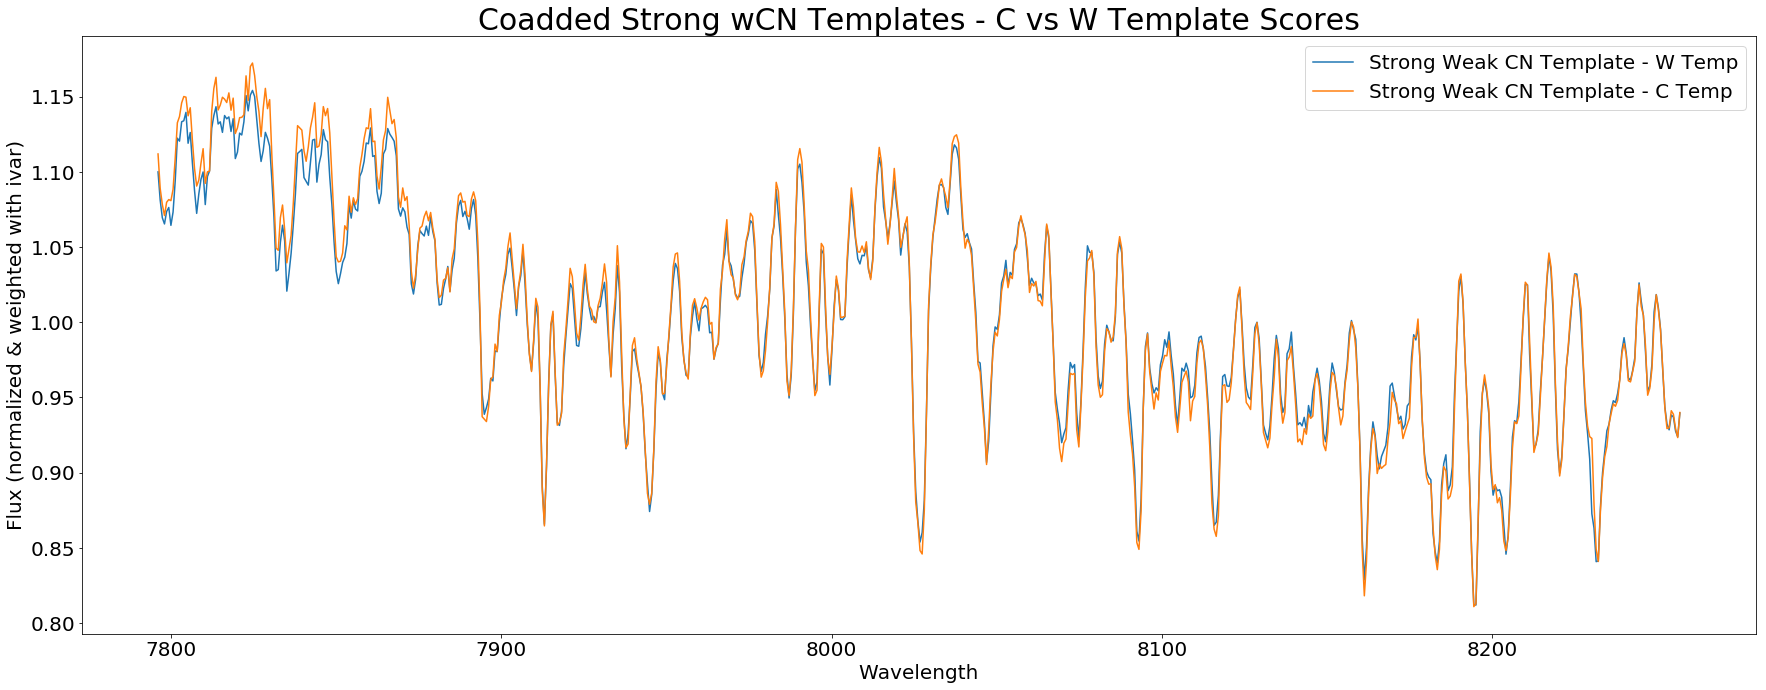

In [117]:
#plotted the Strong Weak CN templates that were calculated from the scores to the Carbon vs Weak CN template

x1 = strong_wCN_template_wv.tolist()
y1 = strong_wCN_template.tolist()
x2 = strong_wCN_Ctemplate_wv.tolist()
y2 = strong_wCN_Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x1, y1,label = 'Strong Weak CN Template - W Temp')
plt.plot(x2,y2,label= 'Strong Weak CN Template - C Temp')
plt.title("Coadded Strong wCN Templates - C vs W Template Scores", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.legend(fontsize=20)
plt.show()

### Comparing Strong vs Weak from W template

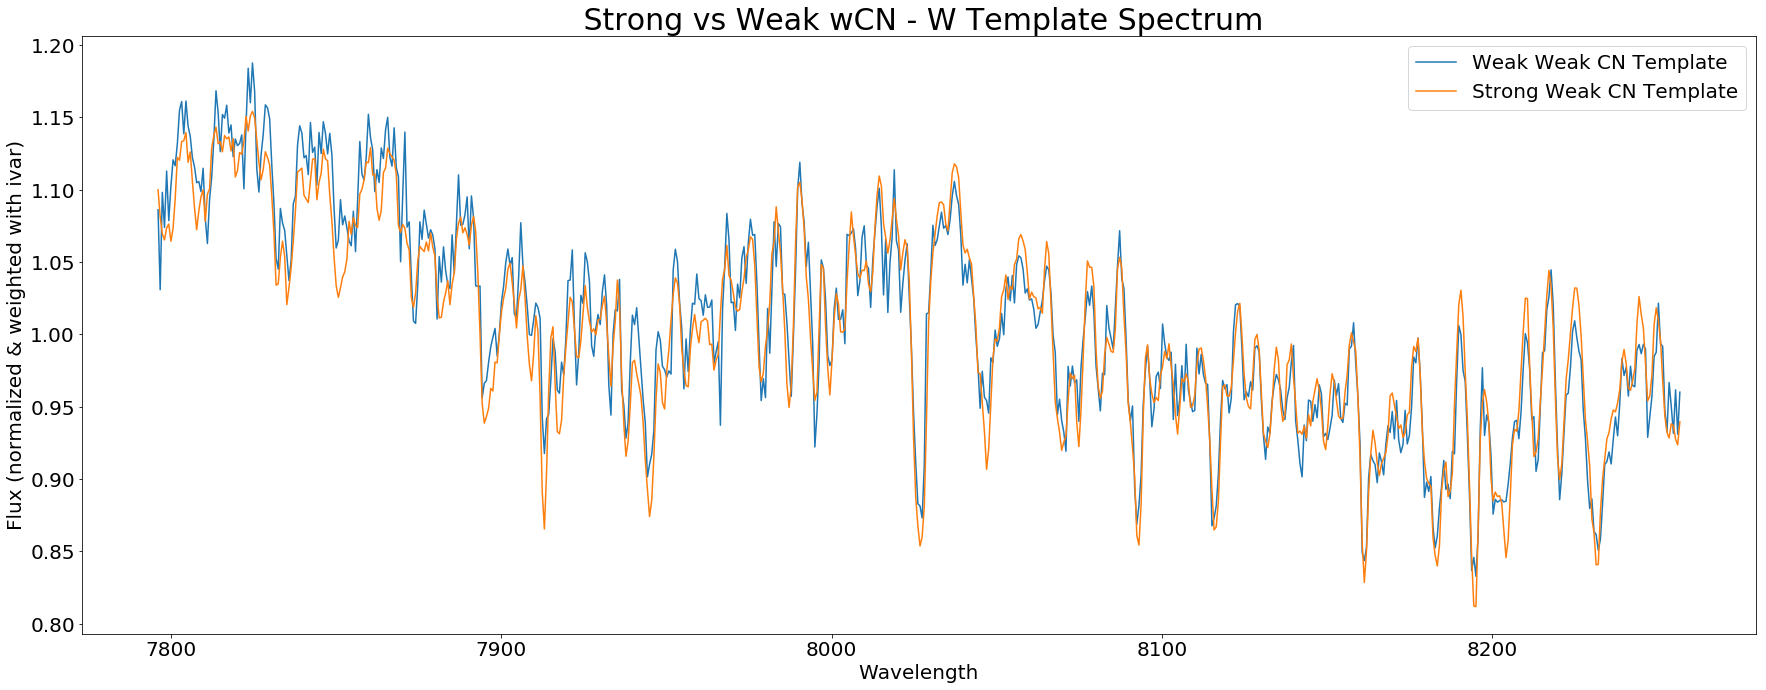

In [118]:
#Comparing the Strong weak CN template vs the Weak Weak CN template
#Both calculated from scores to the Weak CN template

x1 = weak_wCN_template_wv.tolist()
y1 = weak_wCN_template.tolist()
x2 = strong_wCN_template_wv.tolist()
y2 = strong_wCN_template.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x1, y1,label= 'Weak Weak CN Template')
plt.plot(x2,y2,label='Strong Weak CN Template')
plt.title(" Strong vs Weak wCN - W Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.legend(fontsize=20)
plt.show()

### Comparing Strong vs Weak from C template

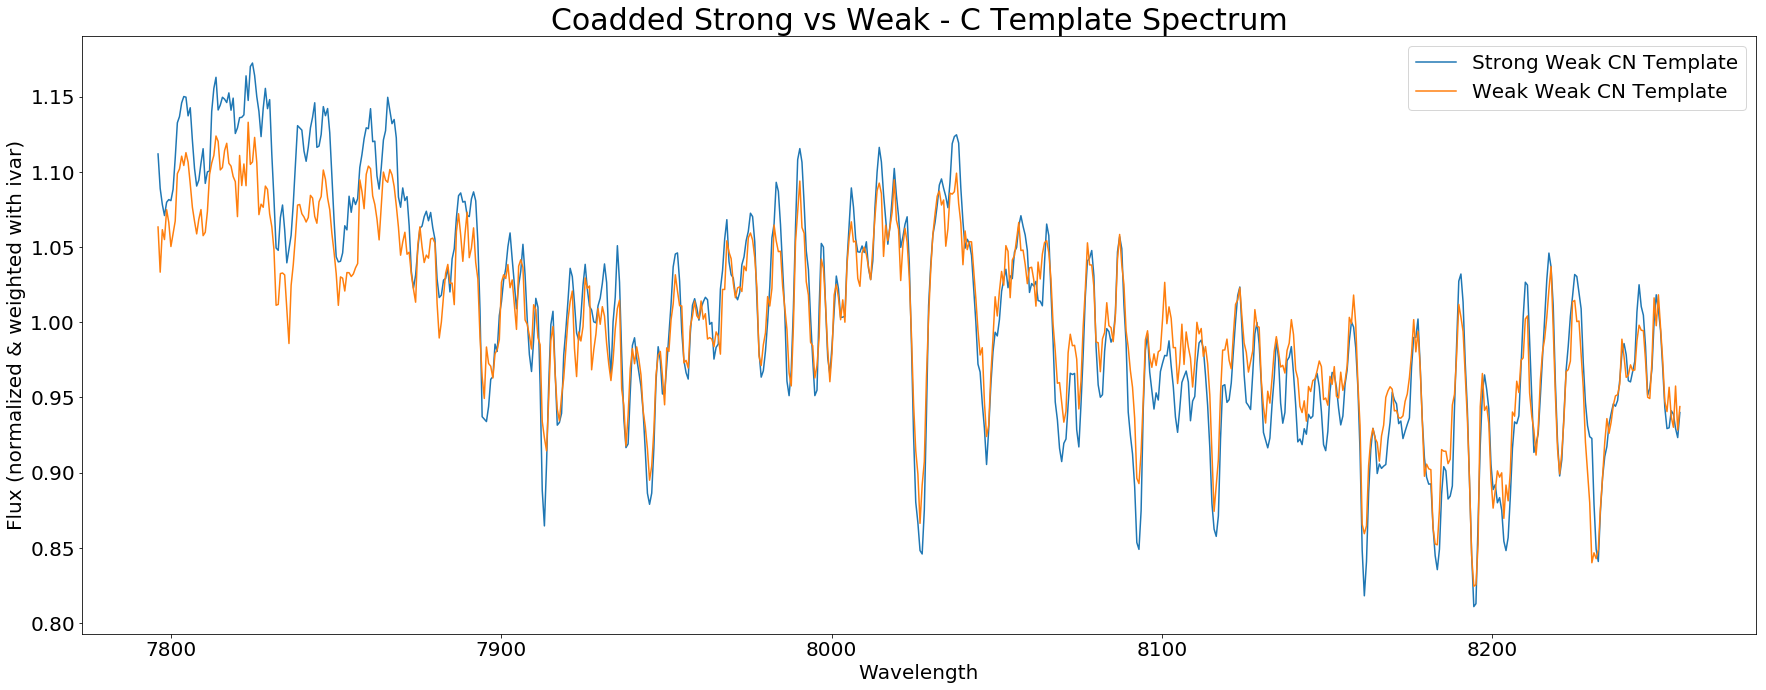

In [119]:
#Comparing the Strong weak CN template vs the Weak Weak CN template
#Both calculated from scores to the Carbon template

x1 = strong_wCN_Ctemplate_wv.tolist()
y1 = strong_wCN_Ctemplate.tolist()
x2 = weak_wCN_Ctemplate_wv.tolist()
y2 = weak_wCN_Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x1, y1,label = 'Strong Weak CN Template')
plt.plot(x2,y2,label = 'Weak Weak CN Template')
plt.title("Coadded Strong vs Weak - C Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
#plt.xlim([7800,7900])
plt.legend(fontsize=20)
plt.show()

# Method 2 - Modified Diluted Template
Calculates the "score" of a star's normalized spectrum by comparing that to a normalized template spectrum and applying a formula that adds up and weights the differences between the two spectra. Note that in method 2, the template is tilted and diluted to match the science spectrum. This makes slope and dilution factor (scale) important factors in addition to score.

Note: The code was adapted from 2.5.3 and 2.6.1 and edited for analysis.

Much of 2.5.3 and 2.6.1 is taken directly or adapted from Anika Kamath's "Automation Version 1.4.1.ipynb" and "myAstroMods.py."

## 2.1 Modified Diluted C Template

In [263]:
#defines an important variable that will be used for finding the slopes of spectra
#the slope will not be calculated based on random points, but on the median point in a small "window" at either end of the spectrum
slopeWindow = 25

In [264]:
#defines a function that calculates the slope of a spectrum's wavelength vs flux graph on a certain interval
def getSlope(spectrum, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a list containing the sliced, normalized flux values of the spectrum to be analyzed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    
    lower and upper will default to the previously defined lowerThresh and upperThresh values, respectively
    
    Returns slope, a numerical value representing the slope of the spectrum on the wavelength range lower to upper
    '''
    lowerInt, upperInt, = spectrum[:slopeWindow], spectrum[-slopeWindow:]
    lowerMedian = np.nanmedian(lowerInt)
    upperMedian = np.nanmedian(upperInt)
    diff = (data['LBIN'][0][upper] - data['LBIN'][0][lower])
    slope = (upperMedian - lowerMedian)/diff
    return slope

In [265]:
#defines a function that modifies the slope of a spectrum by distorting the graph
def getTiltedSpec(spectrum, slope, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be modified
    slope: a numerical value (most often a float) containing the slope to be applied to the spectrum
    lower: the index of the lower boundary of spectrum in data["LBIN"]
    upper: the index of the upper boundary of spectrum in data["LBIN"]
    
    Note that lower and upper will default to the predefined lowerThresh and upperThresh, respectively
    
    Returns titled, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    deltaLam = data['LBIN'][0][lower:upper] - data['LBIN'][0][lower] #note that the used of data["LBIN"][0] is arbitrary because all spectra have the same LBIN data values
    tilted = slope*deltaLam + spectrum #creating a copy of the spectrum with the new slope
    tilted = tilted/np.nanmedian(tilted) #normalizes the spectrum again
    return tilted

#defines a function that scales a spectrum by either enhancing or reducing spectral features
def getScaledSpec(spectrum, c):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be scaled
    c: a numerical value representing the scale factor by which the spectrum will be modified
    
    Returns scaledFlux, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    if c == -1: #accounts for potential divide by zero errors in scaling function
        raise ZeroDivisionError("c cannot be -1 due to the structure of the scaling formula.")
    scaledFlux = (spectrum + c)/(1+c)
    return scaledFlux


In [266]:
#defines a helper function for findOptimalC that produces a list of all the c-values to be tested
def getRanger(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    '''
    start: a numerical value representing the lowest value of c you want to test
    stop: a numerical value representing the highest value of c you want to test
    step: a numerical value representing the increment at which you want to create new values of c between start and stop
    zoomStart: a numerical value representing the lowest value of c you want to test with a finer step size
    zoomStop: a numerical value representing the highest value of c you want to test with a finer step size
    zoomStep: a numerical value representing the finer step size to be applied between zoomStop and zoomStart
    
    Note that zoomStart, zoomStop, and zoomStep will all default to None.
    
    Returns rangeList, a list of the scale-factor (c) values to be iterated over for a star that is undergoing the template-matching process
    '''
    rangeList = []
    i = start
    if zoomStart == None:
        zoomStart = start 
        zoomStop = stop
        zoomStep = step
    while i < stop:
        rangeList.append(i)
        if i >= zoomStart and i <= zoomStop: #'zooms in' on a part of the c-range to get smaller c increments just on that range
            i += zoomStep 
        else:
            i += step
    return rangeList

In [270]:
#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findOptimalC(star, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    for c in getRanger(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec(clipTemplate, c)
        s = slope - getSlope(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

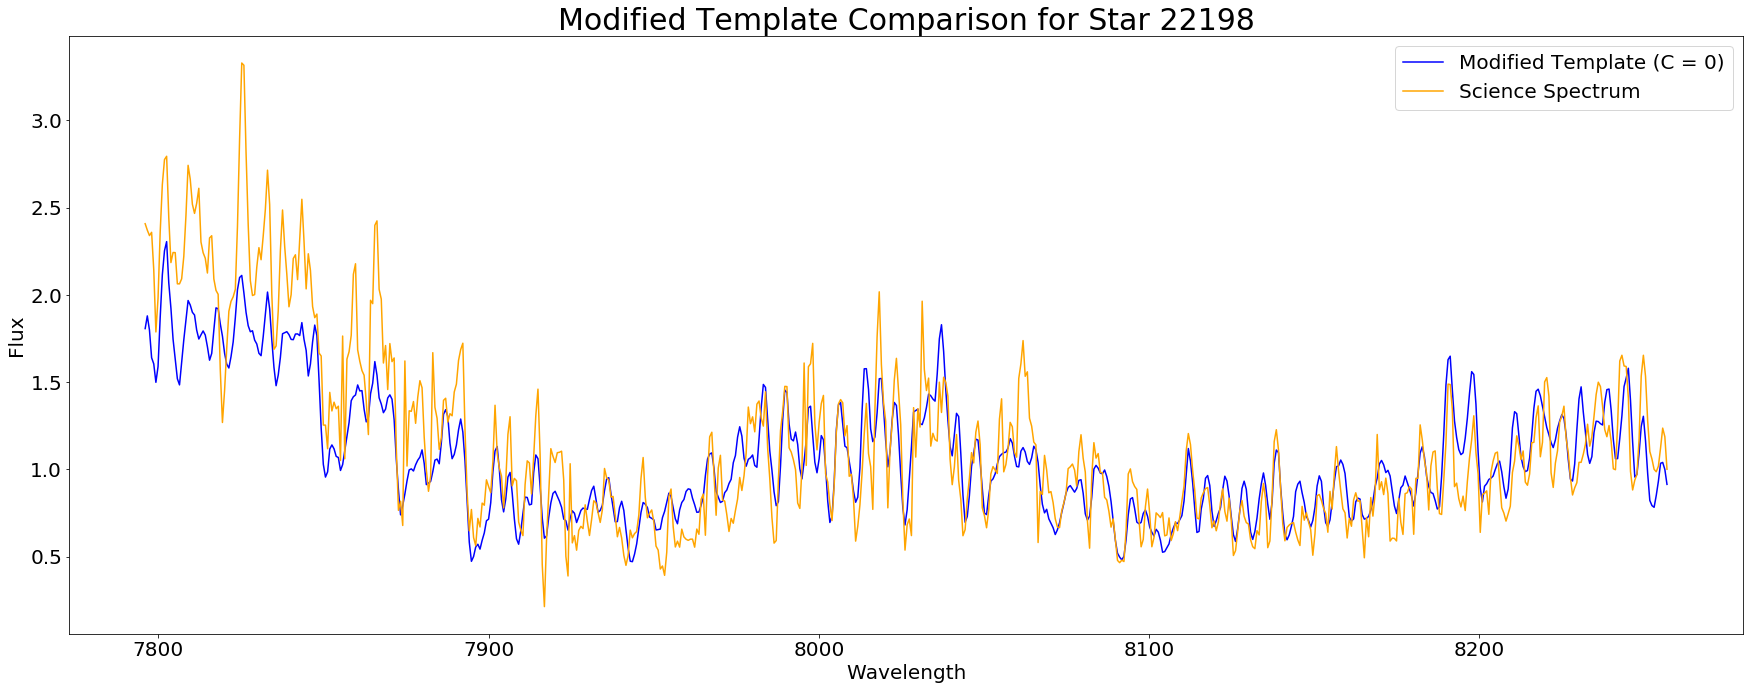

In [271]:
#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModTemplate(star, c , template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
   # if gauss:
    #    clipTemplate = applyGauss(clipTemplate, nsigma)
      #  starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    scaledFlux = getScaledSpec(clipTemplate, c)
    s = slope - getSlope(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

seeModTemplate(22198, 0) #22198 allcarbon star
#seeModTemplate (20352,0) #20252 wNm star
#print(s)

### Creating Dictionaries - Modified Diluted C Template

In [272]:
#creates dictionaries of c, s, and score for each star population based on Method 2:modified diluted template
wNm_c_dict, wNm_s_dict, wNm_score2_dict = {}, {}, {}
#weak_c_dict, weak_s_dict, weak_score2_dict = {}, {}, {}
#marginal_c_dict, marginal_s_dict, marginal_score2_dict = {}, {}, {}
carbon_c_dict, carbon_s_dict, carbon_score2_dict = {}, {}, {}
#kphTrO1_c_dict, kphTrO1_s_dict, kphTrO1_score2_dict = {}, {}, {}
#kphTrO2_c_dict, kphTrO2_s_dict, kphTrO2_score2_dict = {}, {}, {}
#kphOthers_c_dict, kphOthers_s_dict, kphOthers_score2_dict = {}, {}, {}
others_c_dict, others_s_dict, others_score2_dict = {}, {}, {}
#flaggedStars_c_dict, flaggedStars_s_dict, flaggedStars_score2_dict = {}, {}, {}

#generates the sample of stars to be used in the dictionaries (excludes outsiders)
useStars = []
useStars.extend(wNm); useStars.extend(allcarbon); useStars.extend(others)
#useStars.extend(kphTrimmedOthers1); useStars.extend(kphTrimmedOthers2)


#generates the dictionaries and keeps track of progress with a counter
ctr = 0
for star in useStars:
    if not splashSuccess_dict[star]:
        ctr += 1
        if ctr % 100 == 0:
            print(ctr)
        continue
    c, s, sc = findOptimalC(star)
    ctr += 1
    #if star in flaggedStars_list:
    #    flaggedStars_c_dict[star], flaggedStars_s_dict[star], flaggedStars_score2_dict[star] = c, s, sc
    if star in wNm:
        wNm_c_dict[star], wNm_s_dict[star], wNm_score2_dict[star] = c, s, sc
        #if star in weaks:
        #    weak_c_dict[star], weak_s_dict[star], weak_score2_dict[star] = c, s, sc
        #if star in marginals:
         #   marginal_c_dict[star], marginal_s_dict[star], marginal_score2_dict[star] = c, s, sc
    if star in allcarbon:
        carbon_c_dict[star], carbon_s_dict[star], carbon_score2_dict[star] = c, s, sc
    if star in others:
        others_c_dict[star], others_s_dict[star], others_score2_dict[star] = c, s, sc
        
    ''' #commented this section out for now-Rachel
       if star in keckPhotoOthers:
            kphOthers_c_dict[star], kphOthers_s_dict[star], kphOthers_score2_dict[star] = c, s, sc
            if star in kphTrimmedOthers1:
                kphTrO1_c_dict[star], kphTrO1_s_dict[star], kphTrO1_score2_dict[star] = c, s, sc
            if star in kphTrimmedOthers2: #cannot use 'else' because kphTrimmedOthers1 and kphTrimmedOthers2 overlap
                kphTrO2_c_dict[star], kphTrO2_s_dict[star], kphTrO2_score2_dict[star] = c, s, sc
                '''
    if ctr % 100 == 0:
        print(ctr)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

## 2.2 Modified Diluted W Template

In [313]:
#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findWOptimalC(star, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    for c in getRanger(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec(clipTemplate, c)
        s = slope - getSlope(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

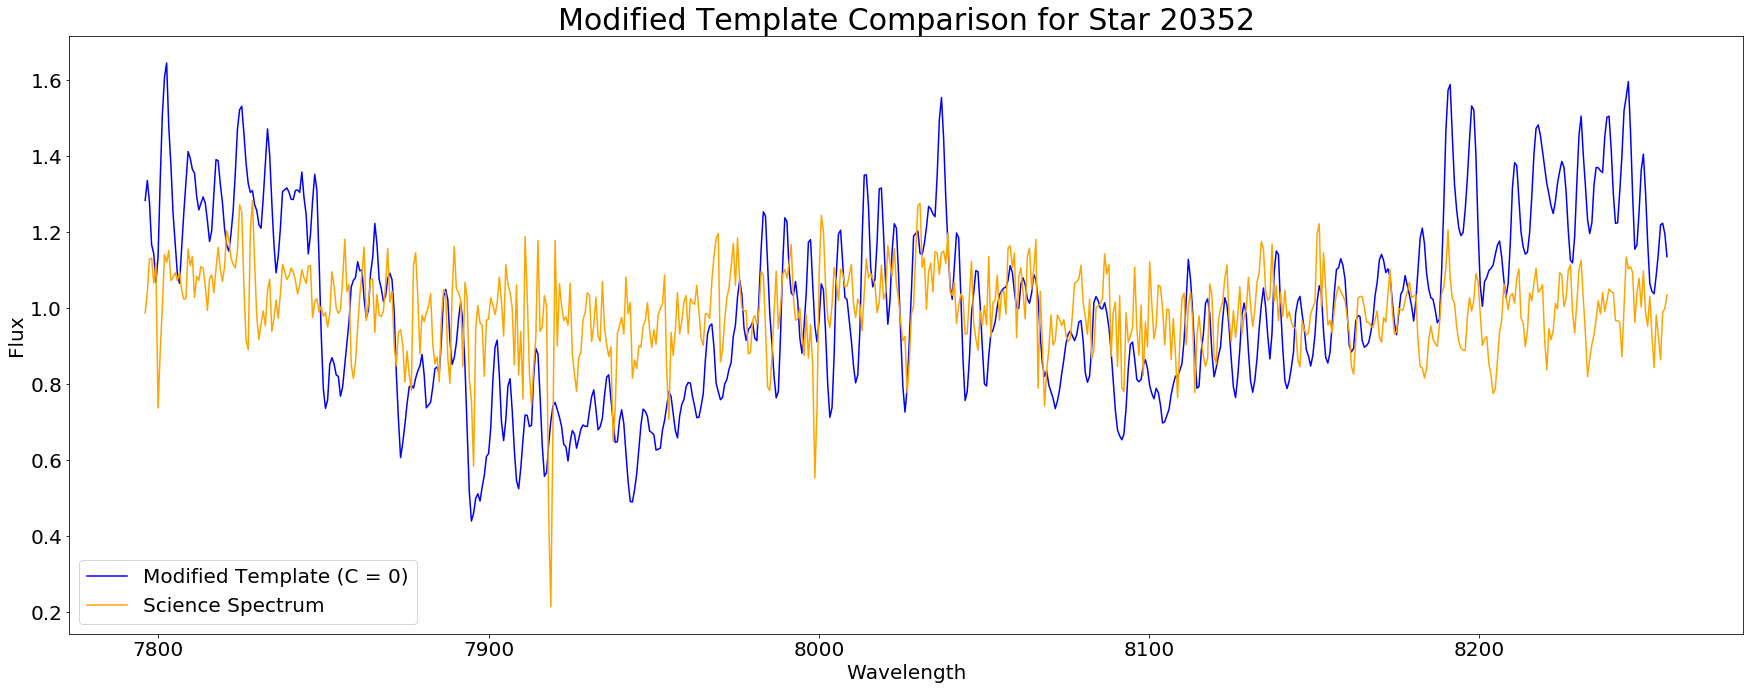

In [314]:
#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModWTemplate(star, c , template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
   # if gauss:
    #    clipTemplate = applyGauss(clipTemplate, nsigma)
      #  starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    scaledFlux = getScaledSpec(clipTemplate, c)
    s = slope - getSlope(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

seeModTemplate(20352, 0) #22198 allcarbon star
#seeModTemplate (20352,0) #20252 wNm star
#print(s)

### Creating dictionaries - Modified Diluted W Template

In [ ]:
#creates dictionaries of c, s, and score for each star population based on Method 2:modified diluted template
wNm_c_wdict, wNm_s_wdict, wNm_score2_wdict = {}, {}, {}
#weak_c_wdict, weak_s_wdict, weak_score2_wdict = {}, {}, {}
#marginal_c_wdict, marginal_s_wdict, marginal_score2_wdict = {}, {}, {}
carbon_c_wdict, carbon_s_wdict, carbon_score2_wdict = {}, {}, {}
#kphTrO1_c_wdict, kphTrO1_s_wdict, kphTrO1_score2_wdict = {}, {}, {}
#kphTrO2_c_wdict, kphTrO2_s_wdict, kphTrO2_score2_wdict = {}, {}, {}
#kphOthers_c_wdict, kphOthers_s_wdict, kphOthers_score2_wdict = {}, {}, {}
others_c_wdict, others_s_wdict, others_score2_wdict = {}, {}, {}
#flaggedStars_c_wdict, flaggedStars_s_wdict, flaggedStars_score2_wdict = {}, {}, {}

#generates the sample of stars to be used in the dictionaries (excludes outsiders)
useStars_w = []
useStars_w.extend(wNm); useStars_w.extend(allcarbon); useStars_w.extend(others)
#useStars.extend(kphTrimmedOthers1); useStars.extend(kphTrimmedOthers2)


#generates the dictionaries and keeps track of progress with a counter
ctr = 0
for star in useStars_w:
    if not splashSuccess_dict[star]:
        ctr += 1
        if ctr % 100 == 0:
            print(ctr)
        continue
    c, s, sc = findWOptimalC(star)
    ctr += 1
    #if star in flaggedStars_list:
    #    flaggedStars_c_wdict[star], flaggedStars_s_wdict[star], flaggedStars_score2_wdict[star] = c, s, sc
    if star in wNm:
        wNm_c_wdict[star], wNm_s_wdict[star], wNm_score2_wdict[star] = c, s, sc
        #if star in weaks:
        #    weak_c_wdict[star], weak_s_wdict[star], weak_score2_wdict[star] = c, s, sc
        #if star in marginals:
         #   marginal_c_wdict[star], marginal_s_wdict[star], marginal_score2_wdict[star] = c, s, sc
    if star in allcarbon:
        carbon_c_wdict[star], carbon_s_wdict[star], carbon_score2_wdict[star] = c, s, sc
    if star in others:
        others_c_wdict[star], others_s_wdict[star], others_score2_wdict[star] = c, s, sc
        
    ''' #commented this section out for now-Rachel
       if star in keckPhotoOthers:
            kphOthers_c_wdict[star], kphOthers_s_wdict[star], kphOthers_score2_wdict[star] = c, s, sc
            if star in kphTrimmedOthers1:
                kphTrO1_c_wdict[star], kphTrO1_s_wdict[star], kphTrO1_score2_wdict[star] = c, s, sc
            if star in kphTrimmedOthers2: #cannot use 'else' because kphTrimmedOthers1 and kphTrimmedOthers2 overlap
                kphTrO2_c_wdict[star], kphTrO2_s_wdict[star], kphTrO2_score2_wdict[star] = c, s, sc
                '''
    if ctr % 100 == 0:
        print(ctr)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


## Part 1: Analysis Based on the Full-Range 'W' - Diluted C Template


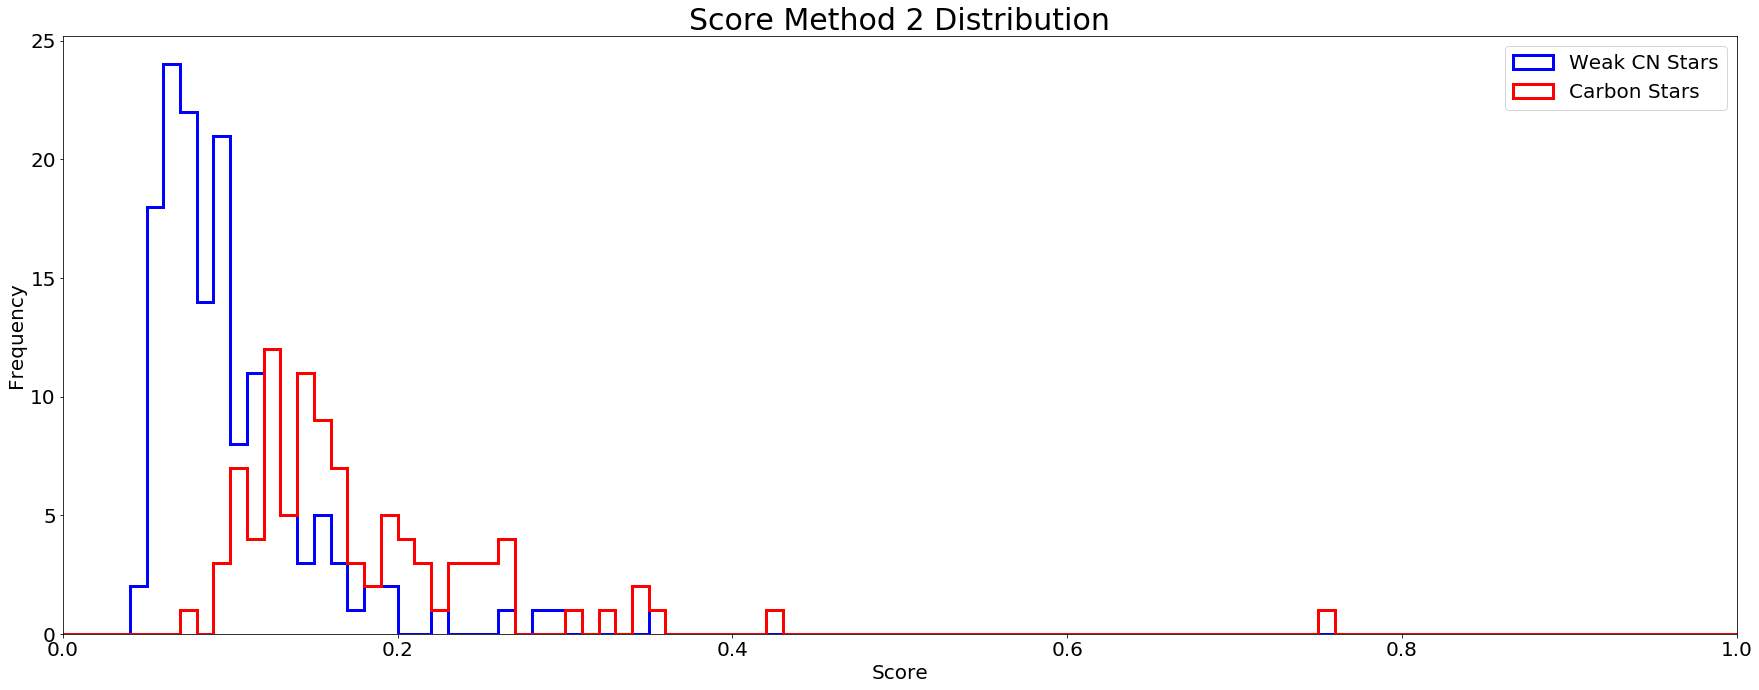

In [276]:
#creating a histogram that displays the score2's for weak CN, carbon, and identified, ivar-trimmed other stars

binList = np.arange(0, 5, 0.01)
plt.hist(wNm_score2_dict.values(), bins = binList, color = "b", histtype = 'step', linewidth = 3, label = "Weak CN Stars")
plt.hist(carbon_score2_dict.values(), bins = binList, color = "r", histtype = 'step',linewidth = 3, label = "Carbon Stars")
# plt.hist(kphTrO1_score2_dict.values(), bins = binList, color = "g", histtype = 'step',linewidth = 3, label = "Others1 Stars")
# plt.hist(kphTrO2_score2_dict.values(), bins = binList, color = "orange", histtype = 'step',linewidth = 3, label = "Others2 Stars")

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Score Method 2 Distribution", size = 30) 
plt.ylabel("Frequency", size = 20)
plt.xlabel("Score", size = 20)
plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.legend(fontsize = 20)
plt.show()

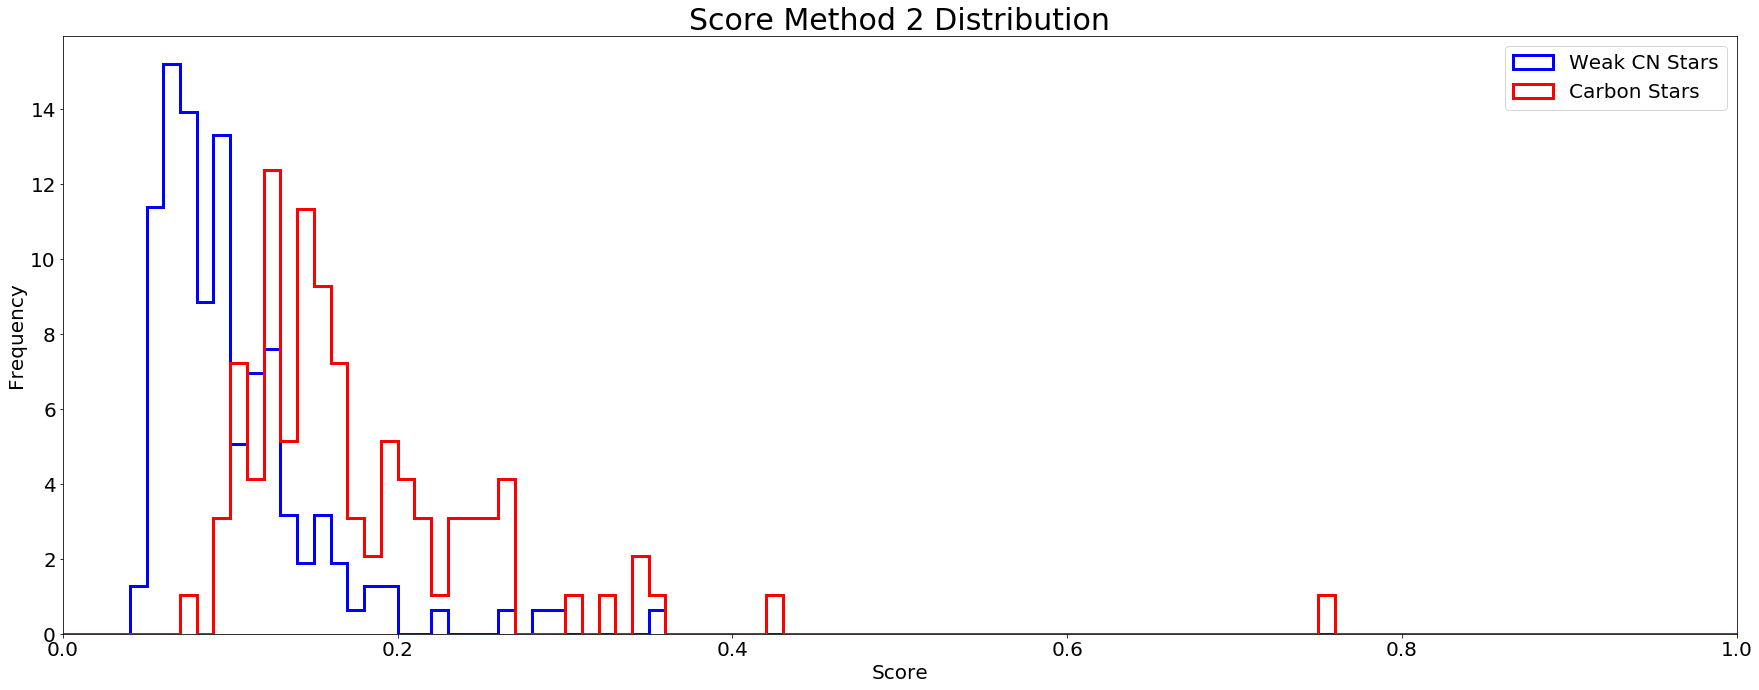

In [277]:
#creating a DENSITY histogram that displays the score2's for weak CN, carbon, and identified, ivar-trimmed other stars
binList = np.arange(0, 5, 0.01)
plt.hist(wNm_score2_dict.values(), bins = binList, color = "b", histtype = 'step', linewidth = 3, label = "Weak CN Stars", density = True)
plt.hist(carbon_score2_dict.values(), bins = binList, color = "r", histtype = 'step', linewidth = 3, label = "Carbon Stars", density = True)
# plt.hist(kphTrO1_score2_dict.values(), bins = binList, color = "g", histtype = 'step', linewidth = 3, label = "Others1 Stars", density = True)
# plt.hist(kphTrO2_score2_dict.values(), bins = binList, color = "orange", histtype = 'step', linewidth = 3, label = "Others2 Stars", density = True)

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Score Method 2 Distribution", size = 30) 
plt.ylabel("Frequency", size = 20)
plt.xlabel("Score", size = 20)
plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.legend(fontsize = 20)
plt.show()

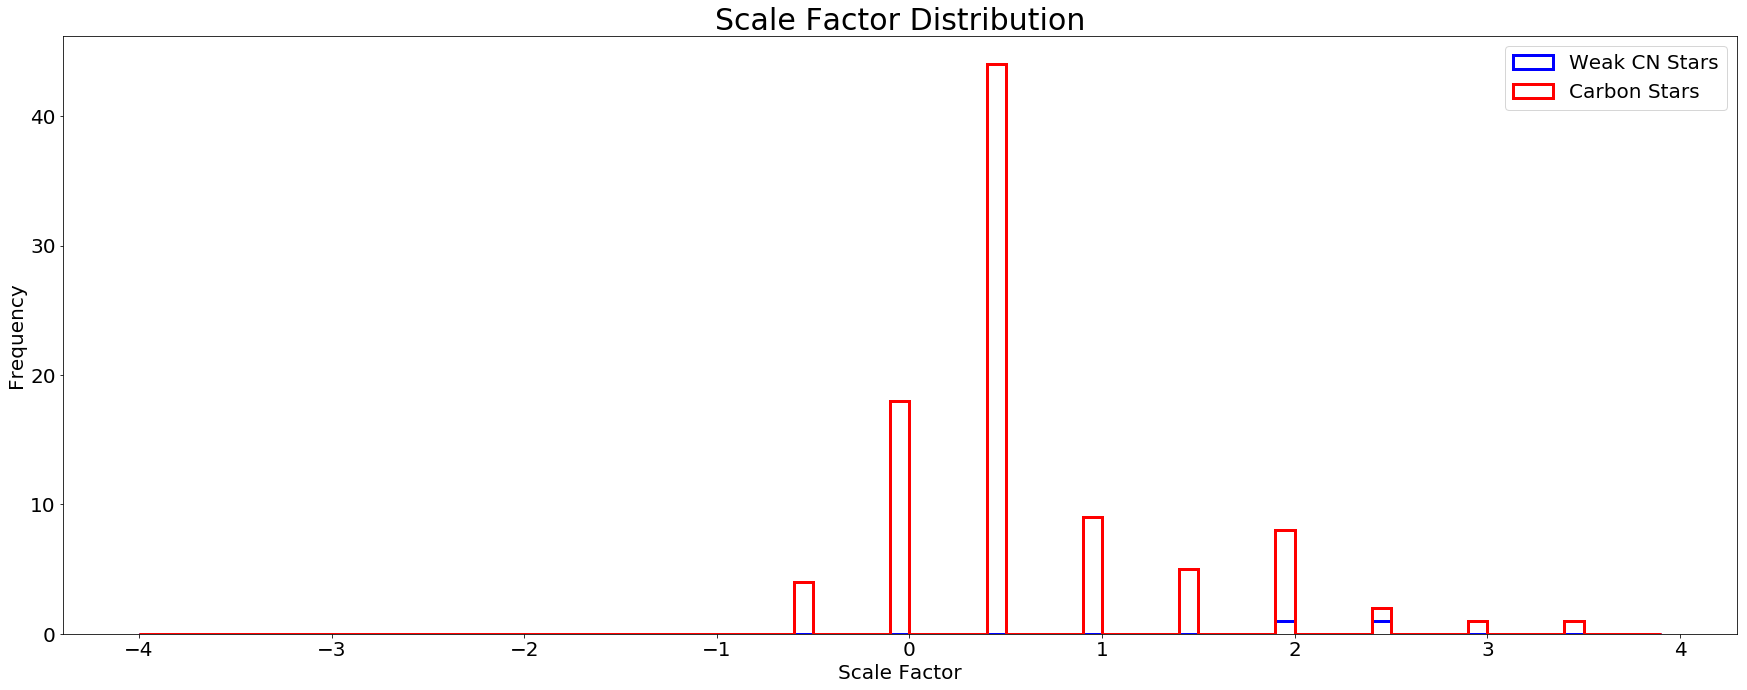

In [278]:
#creating a histogram that displays the c-values for weak CN, carbon, and identified, ivar-trimmed other stars
binList = np.arange(-4, 4, 0.1)
plt.hist(wNm_c_dict.values(), bins = binList, color = "b", histtype = 'step', linewidth = 3, label = "Weak CN Stars")
plt.hist(carbon_c_dict.values(), bins = binList, color = "r", histtype = 'step', linewidth = 3, label = "Carbon Stars")
# plt.hist(kphTrO1_c_dict.values(), bins = binList, color = "g", histtype = 'step', linewidth = 3, label = "Others1 Stars")
# plt.hist(kphTrO2_c_dict.values(), bins = binList, color = "orange", histtype = 'step', linewidth = 3, label = "Others2 Stars")

#formatting the graph so that it is easy to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Scale Factor Distribution", size = 30) 
plt.ylabel("Frequency", size = 20)
plt.xlabel("Scale Factor", size = 20)
plt.legend(fontsize = 20)
plt.show()

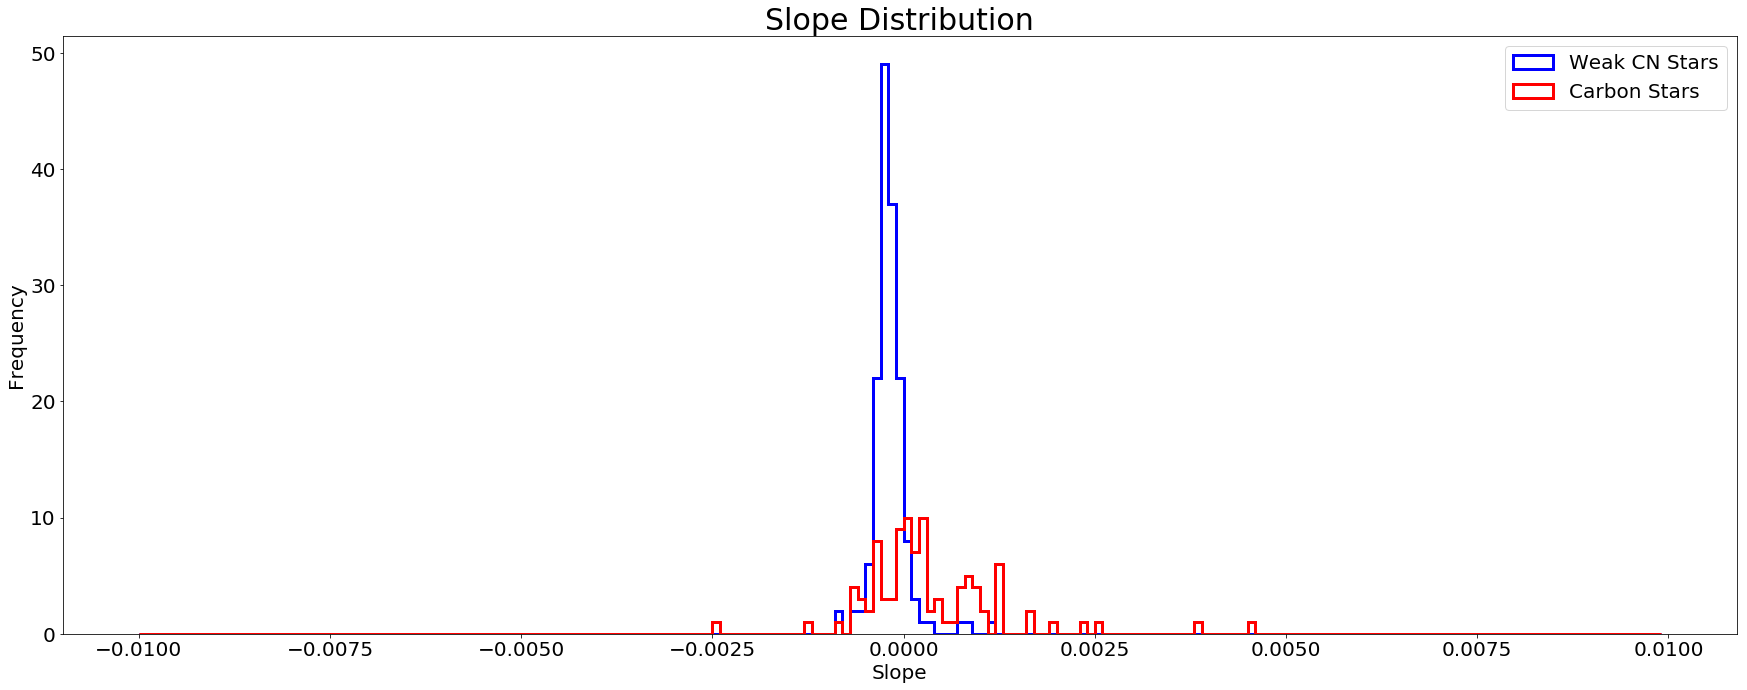

In [279]:
#creating a histogram that displays the s-values for weak CN, carbon, and identified, ivar-trimmed other stars
binList = np.arange(-0.01, 0.01, 0.0001)
plt.hist(wNm_s_dict.values(), bins = binList, color = "b", histtype = 'step', linewidth = 3, label = "Weak CN Stars")
plt.hist(carbon_s_dict.values(), bins = binList, color = "r", histtype = 'step', linewidth = 3, label = "Carbon Stars")
# plt.hist(kphTrO1_s_dict.values(), bins = binList, color = "g", histtype = 'step', linewidth = 3, label = "Others1 Stars")
# plt.hist(kphTrO2_s_dict.values(), bins = binList, color = "orange", histtype = 'step', linewidth = 3, label = "Others2 Stars")

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slope Distribution", size = 30) 
plt.ylabel("Frequency", size = 20)
plt.xlabel("Slope", size = 20)
plt.legend(fontsize = 20)
plt.show()

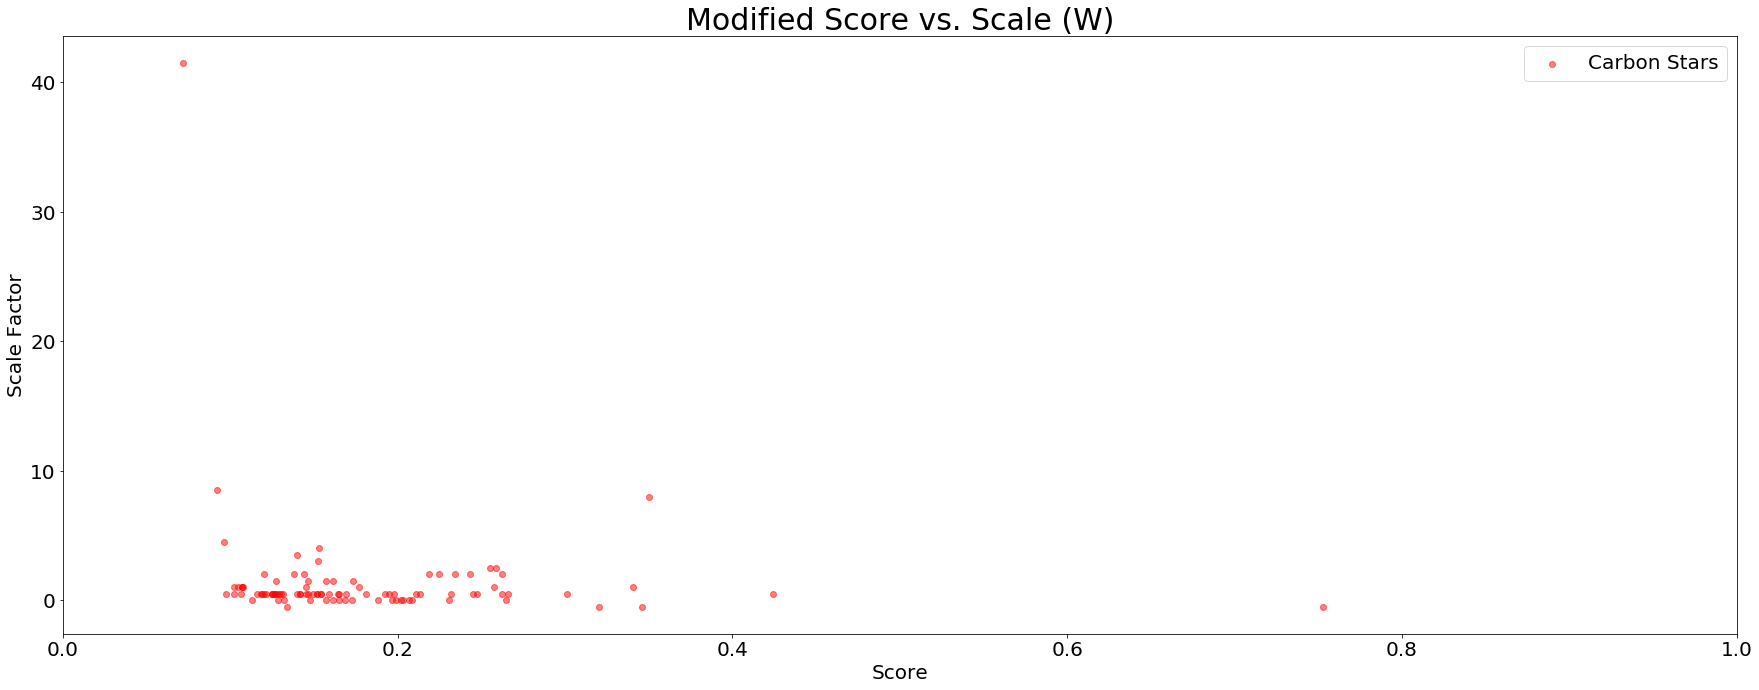

In [280]:
#creates a scatter plot of score vs. scale for weak CN, carbon, and identified, ivar-trimmed other stars
#plt.scatter(wNm_score2_dict.values(), wNm_c_dict.values(), alpha = 0.5, color = 'b', label = 'Weak CN Stars')
#plt.scatter(weak_score2_dict.values(), weak_c_dict.values(), alpha = 0.5, s = 100, color = 'b', label = 'Weak CN Stars')
#plt.scatter(marginal_score2_dict.values(), marginal_c_dict.values(), alpha = 0.5, s = 10, color = 'b', label = 'Marginal Weak CN Stars')
plt.scatter(carbon_score2_dict.values(), carbon_c_dict.values(), alpha = 0.5, color = 'r', label = 'Carbon Stars')
# plt.scatter(kphTrO1_score2_dict.values(), kphTrO1_c_dict.values(), alpha = 0.5, color = 'g', label = 'Others1 Stars')
# plt.scatter(kphTrO2_score2_dict.values(), kphTrO2_c_dict.values(), alpha = 0.5, color = 'orange', label = 'Others2 Stars')

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Modified Score vs. Scale (W)", size = 30) 
plt.ylabel("Scale Factor", size = 20)
plt.xlabel("Score", size = 20)
plt.legend(fontsize = 20)
plt.xlim(0, 1)
plt.show()

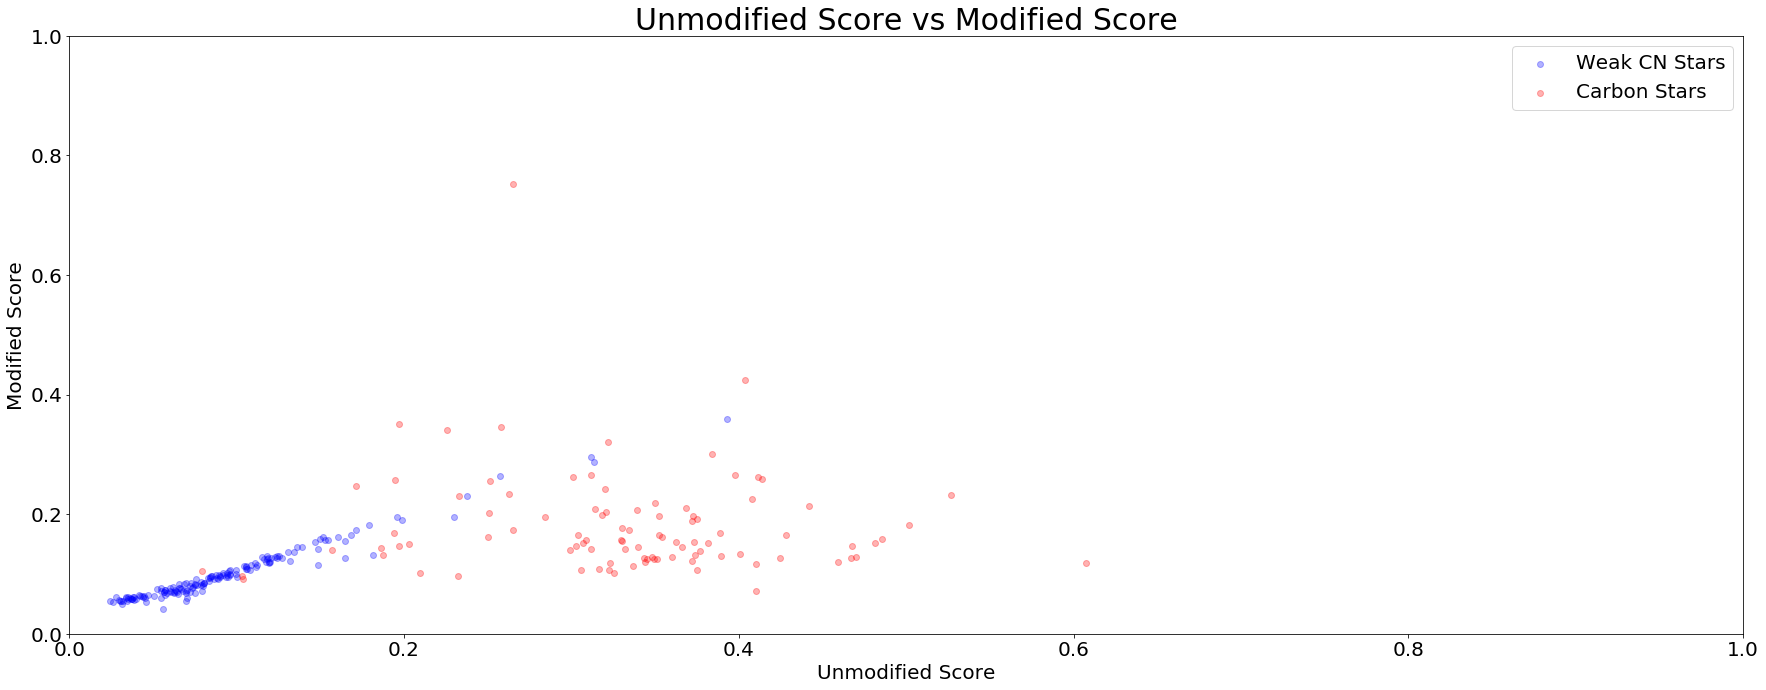

In [281]:
#creates a scatter plot of score1 vs. score2 for weak CN, carbon, and identified, ivar-trimmed other stars
plt.scatter(wNm_score_dict.values(), wNm_score2_dict.values(), color = 'b', alpha = 0.3, label = 'Weak CN Stars')
plt.scatter(carbon_score_dict.values(), carbon_score2_dict.values(), color = 'r', alpha = 0.3, label = 'Carbon Stars')
# plt.scatter(kphTrO1_score_dict.values(), kphTrO1_score2_dict.values(), alpha = 0.3, color = 'g', label = 'Others1 Stars')
# plt.scatter(kphTrO2_score_dict.values(), kphTrO2_score2_dict.values(), alpha = 0.3, color = 'orange', label = 'Others2 Stars')

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Unmodified Score vs Modified Score", size = 30) 
plt.ylabel("Modified Score", size = 20)
plt.xlabel("Unmodified Score", size = 20)
plt.legend(fontsize = 20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

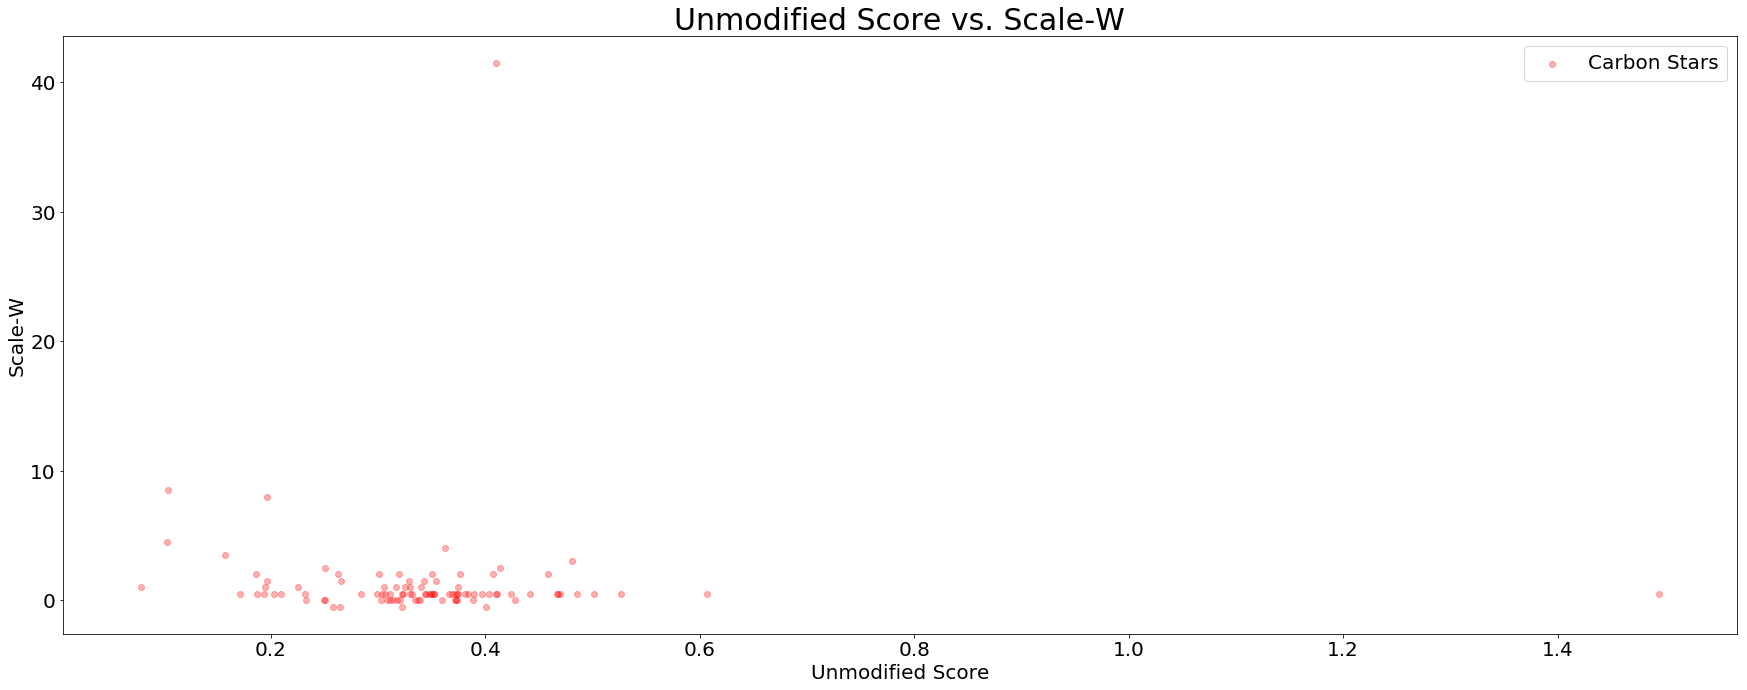

In [282]:
#creates a scatter plot of score1 vs. scale for weak CN, carbon, and identified, ivar-trimmed other stars
#plt.scatter(wNm_score_dict.values(), wNm_c_dict.values(), color = 'b', alpha = 0.3, label = 'Weak CN Stars')
#plt.scatter(weak_score_dict.values(), weak_c_dict.values(), color = 'b', alpha = 0.3, s = 100, label = 'Weak CN Stars')
#plt.scatter(marginal_score_dict.values(), marginal_c_dict.values(), color = 'b', alpha = 0.3, s = 10, label = 'Marginal CN Stars')
plt.scatter(carbon_score_dict.values(), carbon_c_dict.values(), color = 'r', alpha = 0.3, label = 'Carbon Stars')
# plt.scatter(kphTrO1_score_dict.values(), kphTrO1_c_dict.values(), alpha = 0.3, color = 'g', label = 'Others1 Stars')
# plt.scatter(kphTrO2_score_dict.values(), kphTrO2_c_dict.values(), alpha = 0.3, color = 'orange', label = 'Others2 Stars')

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Unmodified Score vs. Scale-W", size = 30) 
plt.ylabel("Scale-W", size = 20)
plt.xlabel("Unmodified Score", size = 20)
plt.legend(fontsize = 20)
plt.show()

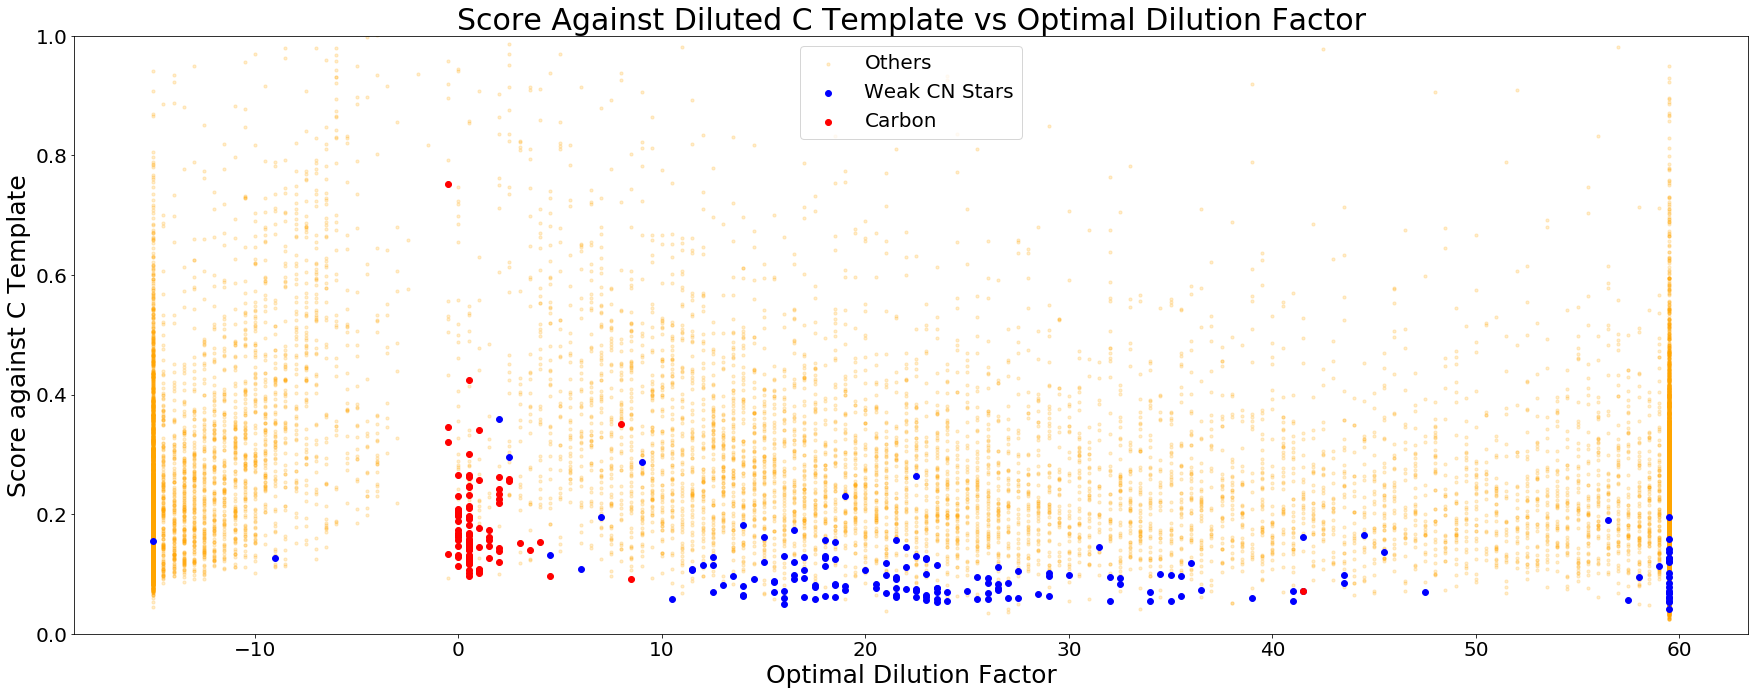

In [283]:
plt.scatter(others_c_dict.values(),others_score2_dict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_c_dict.values(),wNm_score2_dict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_c_dict.values(),carbon_score2_dict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11
#plt.xlim([-.05,.06])
plt.ylim([0,1])
plt.xlabel("Optimal Dilution Factor", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Diluted C Template vs Optimal Dilution Factor", size = 30)
plt.legend(fontsize = 20)
plt.show()

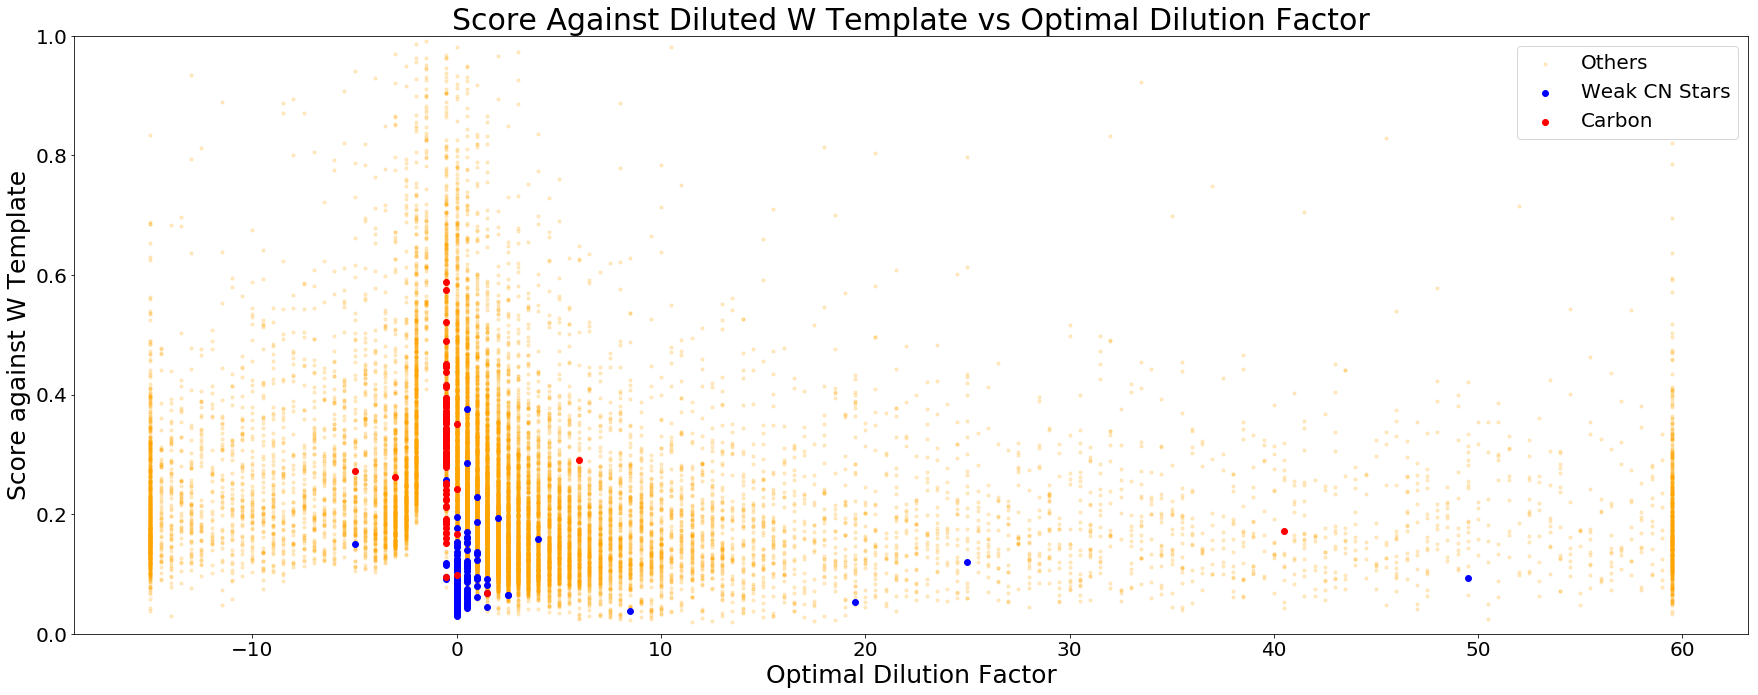

In [284]:
plt.scatter(others_c_wdict.values(),others_score2_wdict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_c_wdict.values(),wNm_score2_wdict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_c_wdict.values(),carbon_score2_wdict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11
#plt.xlim([-10,10])
plt.ylim([0,1])
plt.xlabel("Optimal Dilution Factor", size = 25)
plt.ylabel("Score against W Template", size = 25)
plt.title("Score Against Diluted W Template vs Optimal Dilution Factor", size = 30)
plt.legend(fontsize = 20)
plt.show()

# Method 3 - Undiluted Weak CN template 

Score calculations with slope adjustment with no dilution factor (c=0)

## 3.1 Undiluted W Template

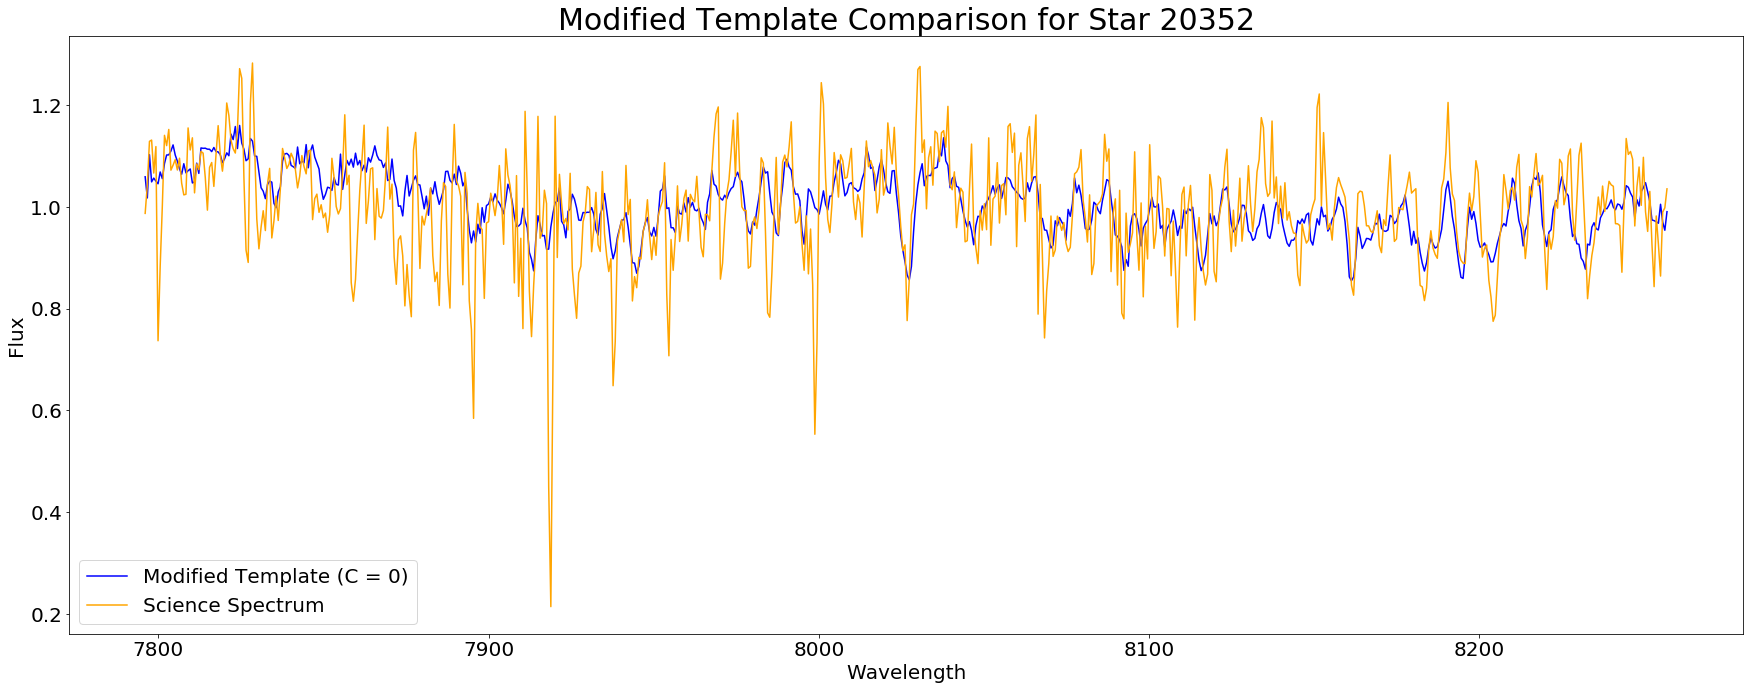

In [285]:
#Rachel- renamed seeModTemplate2 to seeModWtemplate2

#Antara - rewrote this section for spectra that are only tilted and not scaled
#made c=0 everywhere so that spectrum+c/1+c makes no change in spectrum scaling
#also entirely rewrote getRanger, and made some other less extreme changes to the other functions


#defines an important variable that will be used for finding the slopes of spectra
#the slope will not be calculated based on random points, but on the median point in a small "window" at either end of the spectrum
slopeWindow = 25

#defines a function that calculates the slope of a spectrum's wavelength vs flux graph on a certain interval
def getSlope2(spectrum, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a list containing the sliced, normalized flux values of the spectrum to be analyzed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    
    lower and upper will default to the previously defined lowerThresh and upperThresh values, respectively
    
    Returns slope, a numerical value representing the slope of the spectrum on the wavelength range lower to upper
    '''
    lowerInt, upperInt, = spectrum[:slopeWindow], spectrum[-slopeWindow:]
    lowerMedian = np.nanmedian(lowerInt)
    upperMedian = np.nanmedian(upperInt)
    diff = (data['LBIN'][0][upper] - data['LBIN'][0][lower])
    slope = (upperMedian - lowerMedian)/diff
    return slope

#defines a function that modifies the slope of a spectrum by distorting the graph
def getTiltedSpec2(spectrum, slope, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be modified
    slope: a numerical value (most often a float) containing the slope to be applied to the spectrum
    lower: the index of the lower boundary of spectrum in data["LBIN"]
    upper: the index of the upper boundary of spectrum in data["LBIN"]
    
    Note that lower and upper will default to the predefined lowerThresh and upperThresh, respectively
    
    Returns titled, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    deltaLam = data['LBIN'][0][lower:upper] - data['LBIN'][0][lower] #note that the used of data["LBIN"][0] is arbitrary because all spectra have the same LBIN data values
    tilted = slope*deltaLam + spectrum #creating a copy of the spectrum with the new slope
    tilted = tilted/np.nanmedian(tilted) #normalizes the spectrum again
    return tilted

#defines a function that scales a spectrum by either enhancing or reducing spectral features
def getScaledSpec2(spectrum, c):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be scaled
    c: a numerical value representing the scale factor by which the spectrum will be modified
    
    Returns scaledFlux, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    if c == -1: #accounts for potential divide by zero errors in scaling function
        raise ZeroDivisionError("c cannot be -1 due to the structure of the scaling formula.")
    scaledFlux = (spectrum + c)/(1+c)
    return scaledFlux


#defines a helper function for findOptimalC that produces a list of all the c-values to be tested
def getRanger2(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    '''
    start: a numerical value representing the lowest value of c you want to test
    stop: a numerical value representing the highest value of c you want to test
    step: a numerical value representing the increment at which you want to create new values of c between start and stop
    zoomStart: a numerical value representing the lowest value of c you want to test with a finer step size
    zoomStop: a numerical value representing the highest value of c you want to test with a finer step size
    zoomStep: a numerical value representing the finer step size to be applied between zoomStop and zoomStart
    
    Note that zoomStart, zoomStop, and zoomStep will all default to None.
    
    Returns rangeList, a list of the scale-factor (c) values to be iterated over for a star that is undergoing the template-matching process
    '''
    rangeList = []
    c = 0
    rangeList.append(c)
    return rangeList
    
    #Previous code from 2.6
    ''' 
    if zoomStart == None:
        zoomStart = start 
        zoomStop = stop
        zoomStep = step
    while i < stop:
        rangeList.append(i)
        if i >= zoomStart and i <= zoomStop: #'zooms in' on a part of the c-range to get smaller c increments just on that range
            i += zoomStep 
        else:
            i += step
    return rangeList
    '''

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findWOptimalC2(star, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModWTemplate2(star, c=0, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    scaledFlux = getScaledSpec2(clipTemplate, c)
    s = slope - getSlope2(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

#seeModTemplate2(20352, 0) #inputting manually to make sure this works
#seeModTemplate2(20352, c) - doesn't work now (because I've declared c=0 default?)
seeModWTemplate2(20352) #star 20352 is a weak CN star from wNm

#Set scale factor to 0 and adjusted slope to make modified template for Weak CN stars vs science spectrum of wNms

### Creating Dictionaries - Undiluted W Template

In [286]:
#labeled as uwdict for undiluted w template scores
#creates dictionaries of c, s, and score for each star population based on Method 2
wNm_c_uwdict, wNm_s_uwdict, wNm_score2_uwdict = {}, {}, {}
#weak_c_uwdict, weak_s_uwdict, weak_score2_uwdict = {}, {}, {}
#marginal_c_uwdict, marginal_s_uwdict, marginal_score2_uwdict = {}, {}, {}
carbon_c_uwdict, carbon_s_uwdict, carbon_score2_uwdict = {}, {}, {}
#kphTrO1_c_uwdict, kphTrO1_s_uwdict, kphTrO1_score2_uwdict = {}, {}, {}
#kphTrO2_c_uwdict, kphTrO2_s_uwdict, kphTrO2_score2_uwdict = {}, {}, {}
#kphOthers_c_uwdict, kphOthers_s_uwdict, kphOthers_score2_uwdict = {}, {}, {}
others_c_uwdict, others_s_uwdict, others_score2_uwdict = {}, {}, {}
#flaggedStars_c_uwdict, flaggedStars_s_uwdict, flaggedStars_score2_uwdict = {}, {}, {}

#generates the sample of stars to be used in the dictionaries (excludes outsiders)
useStars_uw = []
useStars_uw.extend(wNm); useStars_uw.extend(allcarbon); useStars_uw.extend(others)
#useStars.extend(kphTrimmedOthers1); useStars.extend(kphTrimmedOthers2)


#generates the dictionaries and keeps track of progress with a counter
ctr = 0
for star in useStars_uw:
    if not splashSuccess_dict[star]:
        ctr += 1
        if ctr % 100 == 0:
            print(ctr)
        continue
    c, s, sc = findWOptimalC2(star)
    ctr += 1
   # if star in flaggedStars_list:
    #    flaggedStars_c_uwdict[star], flaggedStars_s_uwdict[star], flaggedStars_score2_uwdict[star] = c, s, sc
    if star in wNm:
        wNm_c_uwdict[star], wNm_s_uwdict[star], wNm_score2_uwdict[star] = c, s, sc
       # if star in weaks:
       #     weak_c_uwdict[star], weak_s_uwdict[star], weak_score2_uwdict[star] = c, s, sc
       # if star in marginals:
       #     marginal_c_uwdict[star], marginal_s_uwdict[star], marginal_score2_uwdict[star] = c, s, sc
    if star in allcarbon:
        carbon_c_uwdict[star], carbon_s_uwdict[star], carbon_score2_uwdict[star] = c, s, sc

    if star in others:
        others_c_uwdict[star], others_s_uwdict[star], others_score2_uwdict[star] = c, s, sc
       
    '''
    if star in keckPhotoOthers:
       kphOthers_c_uwdict[star], kphOthers_s_uwdict[star], kphOthers_score2_uwdict[star] = c, s, sc 
        
            
    if star in kphTrimmedOthers1:
        kphTrO1_c_uwdict[star], kphTrO1_s_uwdict[star], kphTrO1_score2_uwdict[star] = c, s, sc
    if star in kphTrimmedOthers2: #cannot use 'else' because kphTrimmedOthers1 and kphTrimmedOthers2 overlap
        kphTrO2_c_uwdict[star], kphTrO2_s_uwdict[star], kphTrO2_score2_uwdict[star] = c, s, sc
        '''
    if ctr % 100 == 0:
        print(ctr)
        
#runs 21400

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

## 3.2 Undiluted C Template 

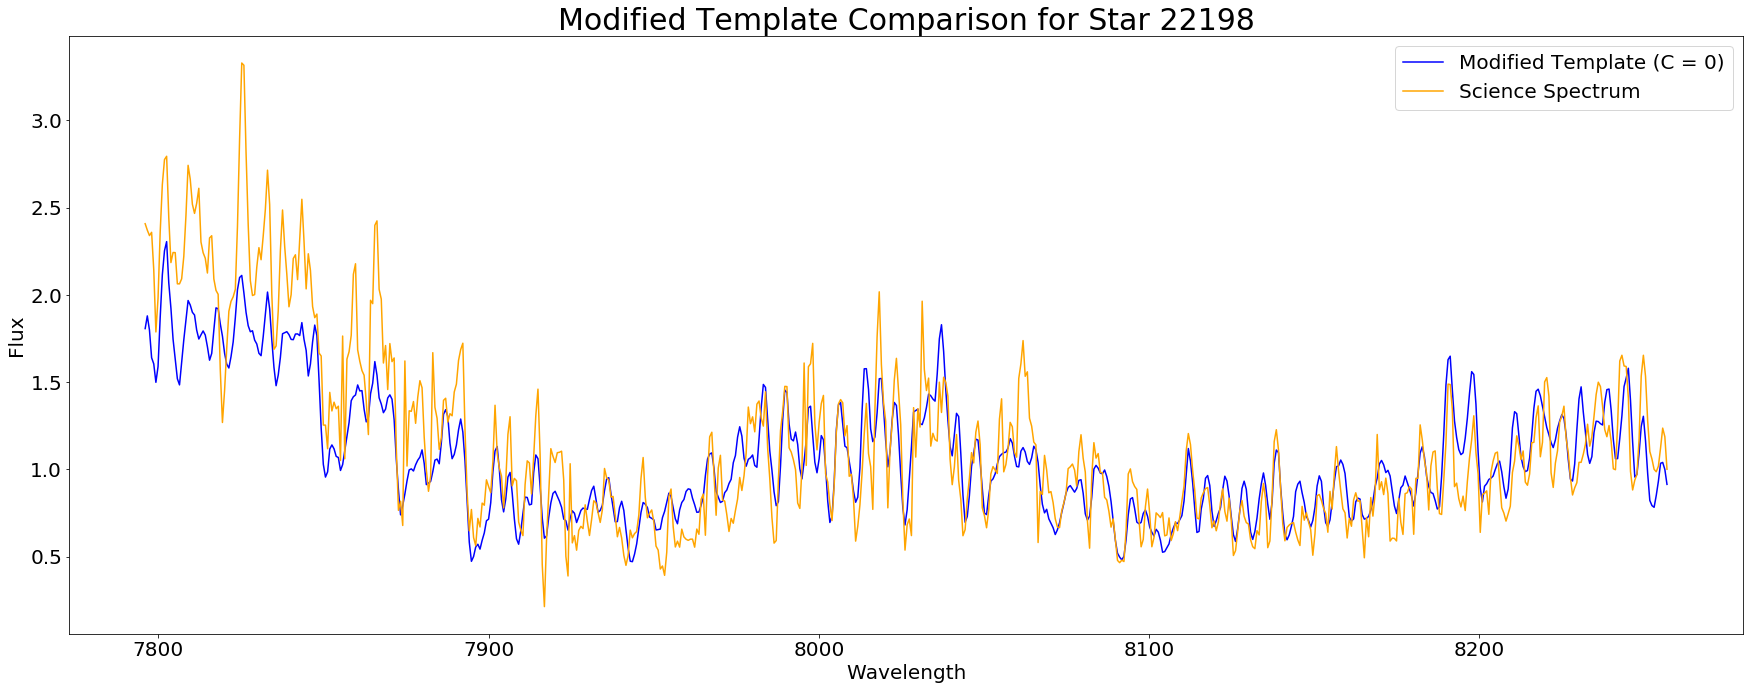

In [287]:
#Rachel- copied  findOptimalC2, seeModWtemplate2 and renamed it findCOptimalC2 and seeModCtemplate
        #and rewrote for template = C_template_full

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findCOptimalC2(star, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModCTemplate2(star, c=0, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    scaledFlux = getScaledSpec2(clipTemplate, c)
    s = slope - getSlope2(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()


seeModCTemplate2(22198) #22198 is a carbon star from allcarbon

#Set scale factor to 0 and adjusted slope to make modified template for Weak CN stars vs science spectrum of wNms

### Creating Dictionaries - Undiluted C Template

In [288]:
#labeled as ucdict for undiluted C template scores
#creates dictionaries of c, s, and score for each star population based on Method 2
wNm_c_ucdict, wNm_s_ucdict, wNm_score2_ucdict = {}, {}, {}
#weak_c_ucdict, weak_s_ucdict, weak_score2_ucdict = {}, {}, {}
#marginal_c_ucdict, marginal_s_ucdict, marginal_score2_ucdict = {}, {}, {}
carbon_c_ucdict, carbon_s_ucdict, carbon_score2_ucdict = {}, {}, {}
#kphTrO1_c_ucdict, kphTrO1_s_ucdict, kphTrO1_score2_ucdict = {}, {}, {}
#kphTrO2_c_ucdict, kphTrO2_s_ucdict, kphTrO2_score2_ucdict = {}, {}, {}
#kphOthers_c_ucdict, kphOthers_s_ucdict, kphOthers_score2_ucdict = {}, {}, {}
others_c_ucdict, others_s_ucdict, others_score2_ucdict = {}, {}, {}
#flaggedStars_c_ucdict, flaggedStars_s_ucdict, flaggedStars_score2_ucdict = {}, {}, {}

#generates the sample of stars to be used in the dictionaries (excludes outsiders)
useStars_uc = []
useStars_uc.extend(wNm); useStars_uc.extend(allcarbon); useStars_uc.extend(others)
#useStars.extend(kphTrimmedOthers1); useStars.extend(kphTrimmedOthers2)


#generates the dictionaries and keeps track of progress with a counter
ctr = 0
for star in useStars_uc:
    if not splashSuccess_dict[star]:
        ctr += 1
        if ctr % 100 == 0:
            print(ctr)
        continue
    c, s, sc = findCOptimalC2(star)
    ctr += 1
   # if star in flaggedStars_list:
    #    flaggedStars_c_ucdict[star], flaggedStars_s_ucdict[star], flaggedStars_score2_ucdict[star] = c, s, sc
    if star in wNm:
        wNm_c_ucdict[star], wNm_s_ucdict[star], wNm_score2_ucdict[star] = c, s, sc
       # if star in weaks:
       #     weak_c_ucdict[star], weak_s_ucdict[star], weak_score2_ucdict[star] = c, s, sc
       # if star in marginals:
       #     marginal_c_ucdict[star], marginal_s_ucdict[star], marginal_score2_ucdict[star] = c, s, sc
    if star in allcarbon:
        carbon_c_ucdict[star], carbon_s_ucdict[star], carbon_score2_ucdict[star] = c, s, sc

    if star in others:
        others_c_ucdict[star], others_s_ucdict[star], others_score2_ucdict[star] = c, s, sc
       
    '''
    if star in keckPhotoOthers:
       kphOthers_c_ucdict[star], kphOthers_s_ucdict[star], kphOthers_score2_ucdict[star] = c, s, sc 
        
            
    if star in kphTrimmedOthers1:
        kphTrO1_c_ucdict[star], kphTrO1_s_ucdict[star], kphTrO1_score2_ucdict[star] = c, s, sc
    if star in kphTrimmedOthers2: #cannot use 'else' because kphTrimmedOthers1 and kphTrimmedOthers2 overlap
        kphTrO2_c_ucdict[star], kphTrO2_s_ucdict[star], kphTrO2_score2_ucdict[star] = c, s, sc
        '''
    if ctr % 100 == 0:
        print(ctr)
        
#runs 21400

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

# Data Analysis of Method 2 & 3

## Undiluted W Template vs. C Template scores

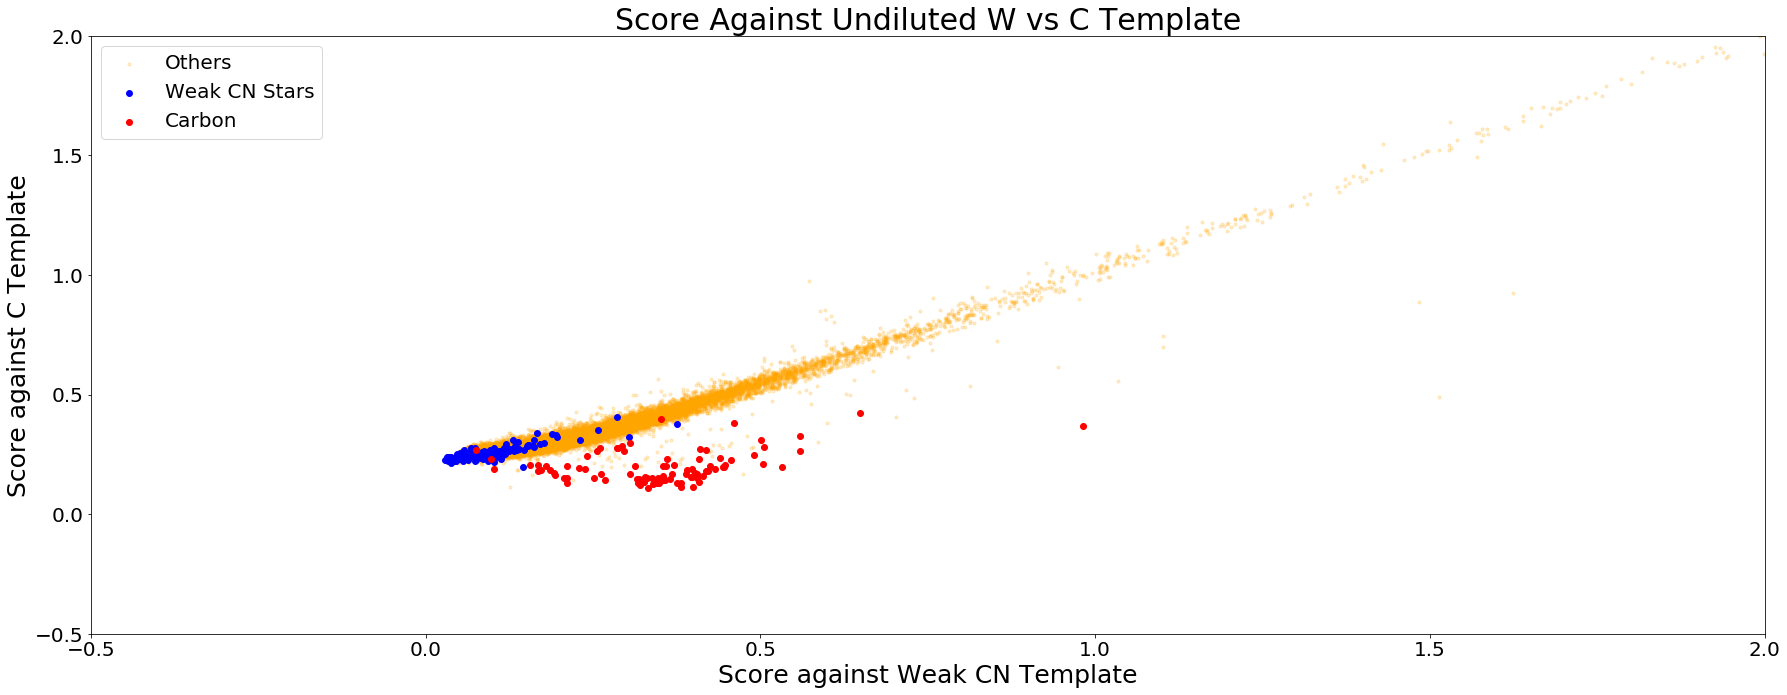

In [289]:
plt.scatter(others_score2_uwdict.values(),others_score2_ucdict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_score2_uwdict.values(),wNm_score2_ucdict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_score2_uwdict.values(),carbon_score2_ucdict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.xlim([-0.5,2])
plt.ylim([-0.5,2])
plt.xlabel("Score against Weak CN Template", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Undiluted W vs C Template", size = 30) 
plt.legend(fontsize = 20)
plt.show()

Percent of 'other' stars closer to carbon than Weak CN: % 1.3071227980597395


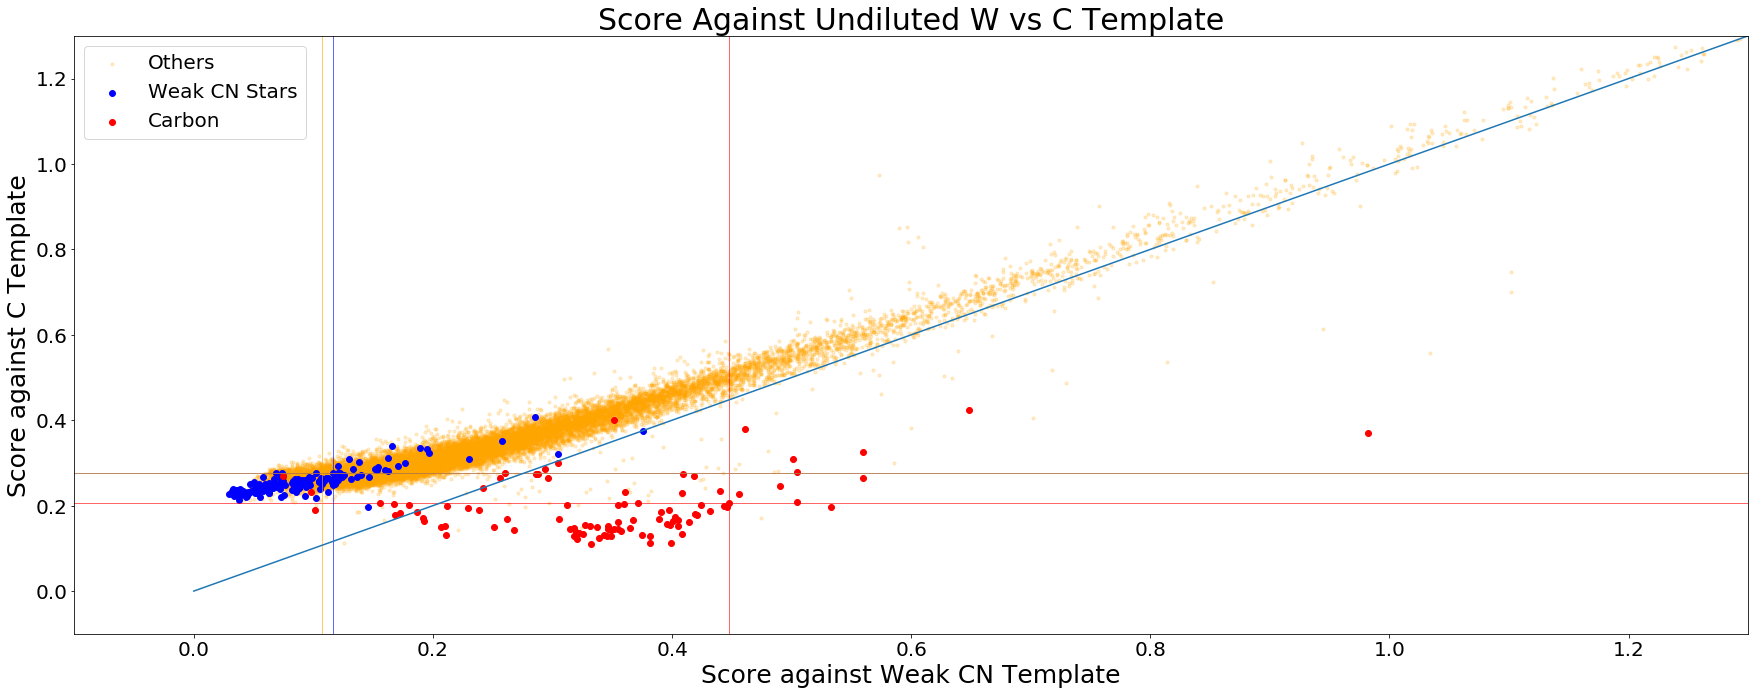

In [290]:
plt.scatter(others_score2_uwdict.values(),others_score2_ucdict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_score2_uwdict.values(),wNm_score2_ucdict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_score2_uwdict.values(),carbon_score2_ucdict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.xlim([-0.1,1.3])
plt.ylim([-0.1,1.3])
#plot lines for star to correspond to axes
#plt.plot([carbon_score2_uwdict[20867],0,carbon_score2_uwdict[20867],carbon_score2_ucdict[20867]])

#Carbon Stars identificaion by vertical and horizontal line 
plt.axhline(y = carbon_score2_ucdict[21469], color='red', linewidth = 0.6)
plt.axvline(x = carbon_score2_uwdict[21469], color='red', linewidth = 0.6)
# print(carbon_score2_ucdict[21469])
# print(carbon_score2_uwdict[21469])

#Weak CN Stars identificaion by vertical and horizontal line 
plt.axhline(y = wNm_score2_ucdict[19971], color='blue', linewidth = 0.6)
plt.axvline(x = wNm_score2_uwdict[19971], color='blue', linewidth = 0.6)
# print(wNm_score2_uwdict[19971])
# print(wNm_score2_ucdict[19971])

#Other Stars identificaion by vertical and horizontal line
plt.axhline(y = others_score2_ucdict[3445],color='orange', linewidth = 0.6)
plt.axvline(x = others_score2_uwdict[3445],color='orange', linewidth = 0.6)
# print("Score Against C Template for Other Star: ",others_score2_ucdict[3445])
# print("Score Against Weak CN Template for Other Star: ",others_score2_uwdict[3445])


#Ploy y=x for comparison
plt.plot(np.linspace(0,2,1000),np.linspace(0,2,1000))

# Computes what percent of other stars are closer to carbon than Weak CN
closerToCarbonCount = 0
for starID in others_score2_uwdict:
  if others_score2_uwdict[starID]>others_score2_ucdict[starID]:
      closerToCarbonCount+=1

print("Percent of 'other' stars closer to carbon than Weak CN: %",100*closerToCarbonCount/len(others_score2_uwdict))

plt.xlabel("Score against Weak CN Template", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Undiluted W vs C Template", size = 30) 
plt.legend(fontsize = 20)
plt.show()

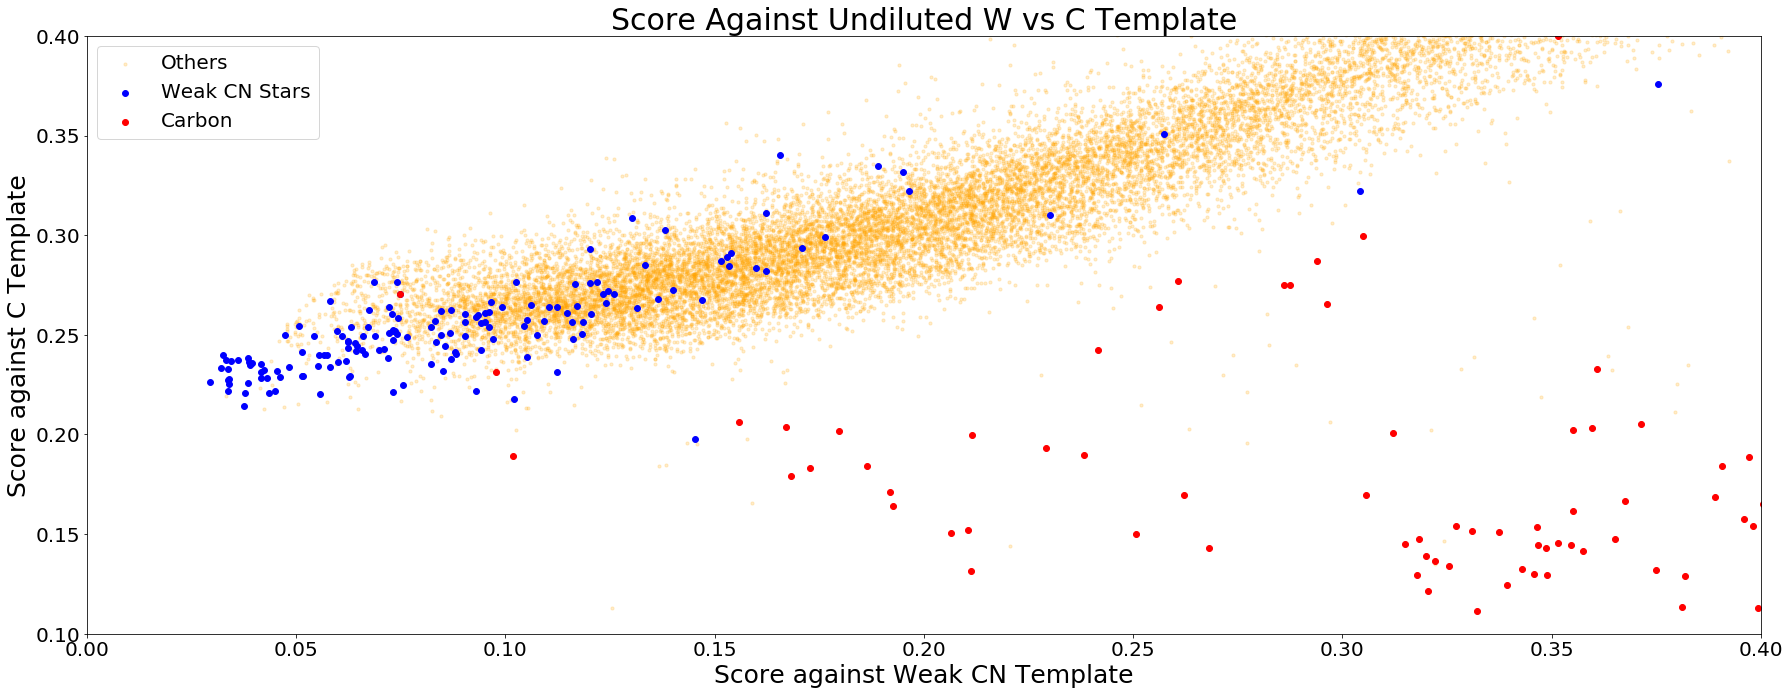

In [291]:
plt.scatter(others_score2_uwdict.values(),others_score2_ucdict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_score2_uwdict.values(),wNm_score2_ucdict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_score2_uwdict.values(),carbon_score2_ucdict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.xlim([0,0.4])
plt.ylim([0.1,0.4])
plt.xlabel("Score against Weak CN Template", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Undiluted W vs C Template", size = 30) 
plt.legend(fontsize = 20)
        
plt.show()

## Diluted C Template Scores vs. Optimal Dilution Factor

# Method 4 - Slope

Calculating the four slopes of the W range.

## Finding W slopes for the weak CN template

In [292]:
#defines important variables that will be used to find the slopes of the graph within specific windows
wv_range = data["LBIN"][0][lowerThresh:upperThresh]
windows = [[0, 227], [227, 342], [342, 473], [473, 709]] #these bin limits correspond to values 7796, 7943.5, 8018.5, 8103.5, and 8257.5 in data["LBIN"]
windows2 = [[0, 227], [0, 115], [0, 131], [0, 236]]

In [300]:
#defines a helper function for the getWSlopes function that determines what the slope of the line of best fit is for a certain graph
def findOptimalM(spectrum, lower, upper, lowM = -0.1, highM = 0.1, step = 0.001, zoomStart = -0.05, zoomStop = 0.05, zoomStep = 0.0001):
    '''
    spectrum: a Numpy array representing the flux values of a normalized, clipped (to the 'W' range) spectrum whose slopes are to be found
    lower: the lower boundary of the range that the slope is to be calculated over (represented by an index of the CLIPPED spectrum; 0 will be lowerThresh and so on)
    upper: the upper boundary of the range that the slope is to be calculated over (represented by an index of the CLIPPED spectrum; 0 will be lowerThresh and so on)
    lowM: the lower boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    highM: the upper boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    step: the increment value to use when creating new values of m to test between lowM and highM
    zoomStart: the lower boundary of the range of m-values that you want to test with a finer step size
    zoomStop: the upper boundary of the range of m-values that you want to test with a finer step size
    zoomStep: the finer increment value to be applied between zoomStart and zoomStop
    
    Note that lowM, highM, step, zoomStart, zoomStop, and zoomStep will default to -0.1, 0.1, 0.05, -0.05, 0.05, and 0.001, respectively
    
    Returns bestM, a numerical value representing the slope of the line of best fit for the spectrum on the range lower:upper
    Also returns bestB, the y-intercept value that corresponds to the bestM, to be used for graphing the chosen lines of best fit
    '''
    bestDiff, bestM, bestB = 1000000000000, None, None
    lbin = data["LBIN"][0][lowerThresh:upperThresh][lower:upper]
    mRanger = getRanger(lowM, highM, step, zoomStart, zoomStop, zoomStep) #note that this is the same function earlier defined in score calculation method 2
    for m in mRanger:
        b = ((np.nansum(spectrum)) - (m*(np.nansum(lbin))))/(len(lbin))
        testDiff = np.nansum(np.power((spectrum - m*lbin - b), 2))
        if testDiff < bestDiff:
            bestDiff = testDiff
            bestM, bestB = m, b
    return bestM, bestB

In [301]:
#defines a function that will check to see if the range covered by non-NaN values in a spectrum slice is greater than/equal to 75% of the length of the spectrum
#if the above condition is not met, the slope of the slice cannot be calculated
def isValidWindow(spectrum, windowLower, windowUpper):
    '''
    spectrum: a Numpy array containing the flux values of a normalized, trimmed (clipped to the 'W' range) spectrum whose slope is to be calculated
    windowLower: the lower boundary of the window of spectrum whose validity is to be tested
    windowUpper: the upper boundary of the window of spectrum whose validity is to be tested
    
    Returns False if the window specified has too many NaN values to be used for slope calculation, True otherwise
    '''
    testSpec = spectrum[windowLower:windowUpper]
    count1, count2 = windowLower, windowUpper
    for index in range(len(testSpec)): #finding the index of the first non-NaN value
        if np.isnan(testSpec[index]):
            count1 = index
        else:
            break
    for index in range(len(testSpec), 0, -1): #finding the index of the last non-NaN value
        if np.isnan(testSpec[index - 1]):
            count2 = index
        else:
            break
    if len(testSpec[count1:count2]) < 0.75*len(testSpec): #the range covered by the two indices found above must be greater than or equal to the length of the spectrum to be usable
        return False
    else:
        return True

In [302]:
#defines a function that calculates four slopes of a spectral graph
def getWSlopes(spectrum, lowM = -0.1, highM = 0.1, step = 0.001, zoomStart = -0.05, zoomStop = 0.05, zoomStep = 0.0001, getB = False):
    '''
    spectrum: a Numpy array or list containing the flux values for a spectrum whose slopes will be calculated; must already be normalized/clipped to the lowerThresh:upperThresh wavelength range
    lowM: the lower boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    highM: the upper boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    step: the increment value to use when creating new values of m to test between lowM and highM
    zoomStart: the lower boundary of the range of m-values that you want to test with a finer step size
    zoomStop: the upper boundary of the range of m-values that you want to test with a finer step size
    zoomStep: the finer increment value to be applied between zoomStart and zoomStop
    getB: a Boolean value that, if set to True, will cause the function to return both slope and y-intercept values for the lines of best fit created (if False, only slopes will be returned)
    
    Note that lowM, highM, step, zoomStart, zoomStop, zoomStep, and getB will default to -0.1, 0.1, 0.05, -0.05, 0.05, 0.001, and False, respectively
    
    Returns slope1, slope2, slope3, and slope4, the slopes of the spectral graph over the window ranges described above; these slopes are intended to represent the four slopes of the 'W' feature in carbon/weak CN spectra
    If getB is set to True, also returns the y-intercept values for the lines of best fit corresponding to slope1, slope2, slope3, and slope4
    '''
    #first, a preliminary check to see if the entire spectrum is NaN; if True, all returned slopes are NaN as well
    if all(np.isnan(spectrum)):
        print("SlopeError: This spectrum is all NaNs. No slopes can be found.")
        return np.nan, np.nan, np.nan, np.nan
    
    #if the above test is passed, the spectrum is divided into four windows
    window1, window2 = spectrum[windows[0][0]:windows[0][1]], spectrum[windows[1][0]:windows[1][1]]
    window3, window4 = spectrum[windows[2][0]:windows[2][1]], spectrum[windows[3][0]:windows[3][1]]
    calc1, calc2, calc3, calc4 = True, True, True, True
    
    #tests are done on each window to make sure that the presence of NaNs will not ruin the slope calculation
    #if the calculation cannot be performed, the calcX variables are set to False (meaning those slopes will not be calculated later) and the slopes to be returned are set to NaN
    if all(np.isnan(window1)) or not isValidWindow(spectrum, windows2[0][0], windows2[0][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 1. Slope1 could not be found.")
        slope1, calc1 = np.nan, False
    if all(np.isnan(window2)) or not isValidWindow(spectrum, windows2[1][0], windows2[1][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 2. Slope2 could not be found.")
        slope2, calc2 = np.nan, False
    if all(np.isnan(window3)) or not isValidWindow(spectrum, windows2[2][0], windows2[2][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 3. Slope3 could not be found.")
        slope3, calc3 = np.nan, False
    if all(np.isnan(window4)) or not isValidWindow(spectrum, windows2[3][0], windows2[3][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 4. Slope4 could not be found.")
        slope4, calc4 = np.nan, False
    
    #finally, slopes are calculated in each of the valid windows that were not previously weeded out above
    if calc1:
        slope1, b1 = findOptimalM(window1, windows[0][0], windows[0][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc2:
        slope2, b2 = findOptimalM(window2, windows[1][0], windows[1][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc3:
        slope3, b3 = findOptimalM(window3, windows[2][0], windows[2][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc4:
        slope4, b4 = findOptimalM(window4, windows[3][0], windows[3][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
        
    #the valid slopes and the NaN slopes (if any) are returned together in a tuple, along with the b-values (if specified)
    if getB:
        return slope1, slope2, slope3, slope4, b1, b2, b3, b4
    if not getB:
        return slope1, slope2, slope3, slope4

In [303]:
#test executions of the above function
print(getWSlopes(Ctemplate))
print(getWSlopes(Wtemplate))
print(getWSlopes(normSpec(star = others[2])[1]))

(-0.010099999999999554, 0.007300000000000447, -0.007899999999999567, 0.0034000000000004387)
(-0.0010999999999995599, 0.0012000000000004407, -0.0008999999999995598, 4.4037581740929976e-16)
(-0.0018999999999995602, -0.0029999999999995586, -9.999999999955963e-05, -0.0006999999999995597)


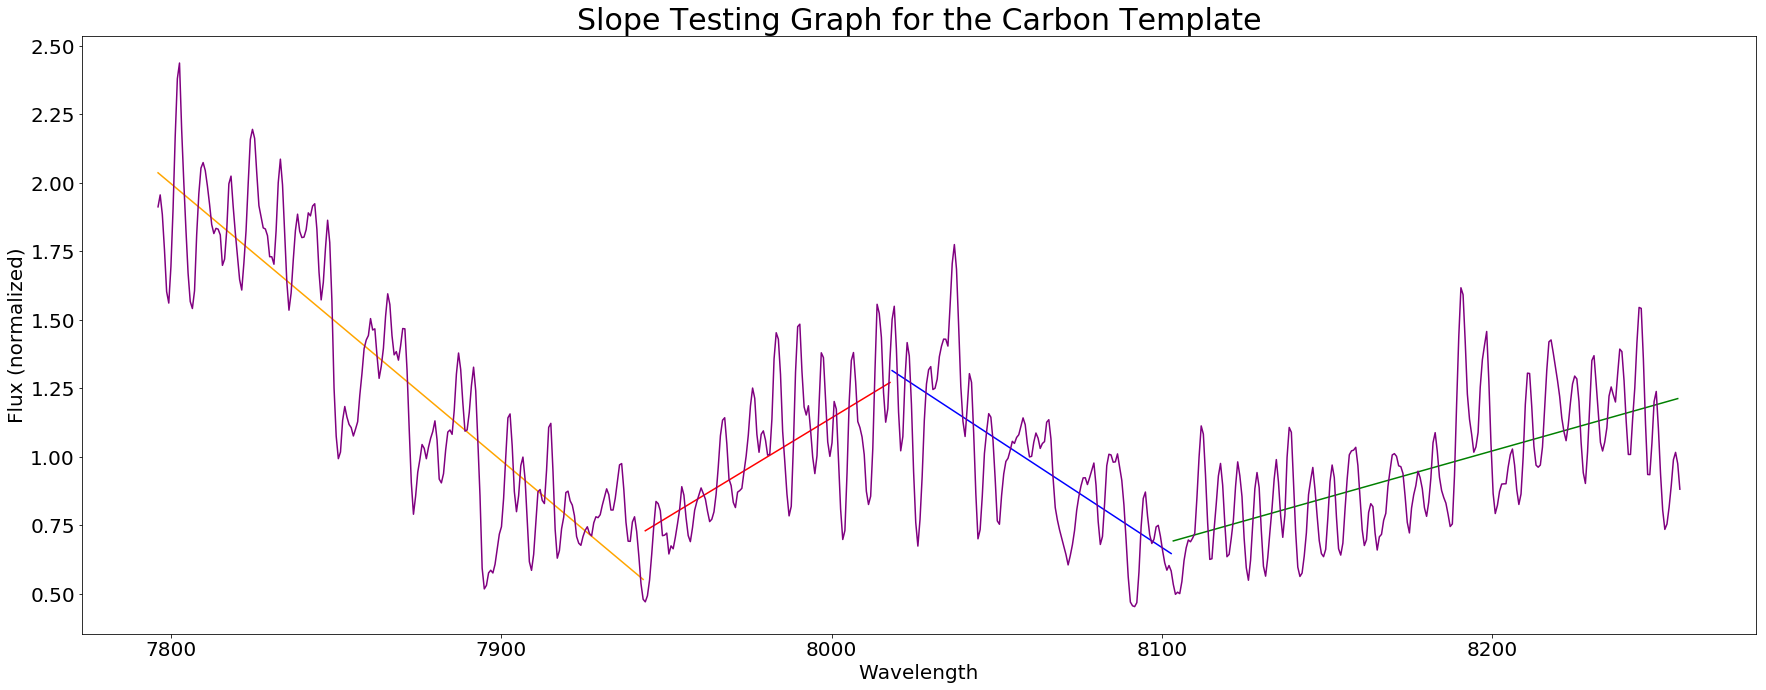

In [304]:
#creating a test graph of the carbon coadd to see if the lines of best fit match the data well
s1, s2, s3, s4, b1, b2, b3, b4 = getWSlopes(Ctemplate, getB = True)
lbin = data["LBIN"][0][lowerThresh:upperThresh]
plt.plot(lbin[windows[0][0]:windows[0][1]], lbin[windows[0][0]:windows[0][1]]*s1 + b1, color = 'orange')
plt.plot(lbin[windows[1][0]:windows[1][1]], lbin[windows[1][0]:windows[1][1]]*s2 + b2, color = 'r')
plt.plot(lbin[windows[2][0]:windows[2][1]], lbin[windows[2][0]:windows[2][1]]*s3 + b3, color = 'b')
plt.plot(lbin[windows[3][0]:windows[3][1]], lbin[windows[3][0]:windows[3][1]]*s4 + b4, color = 'g')
plt.plot(Ctemplate_wv, Ctemplate, color = 'purple')
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slope Testing Graph for the Carbon Template", size = 30) 
plt.ylabel("Flux (normalized)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

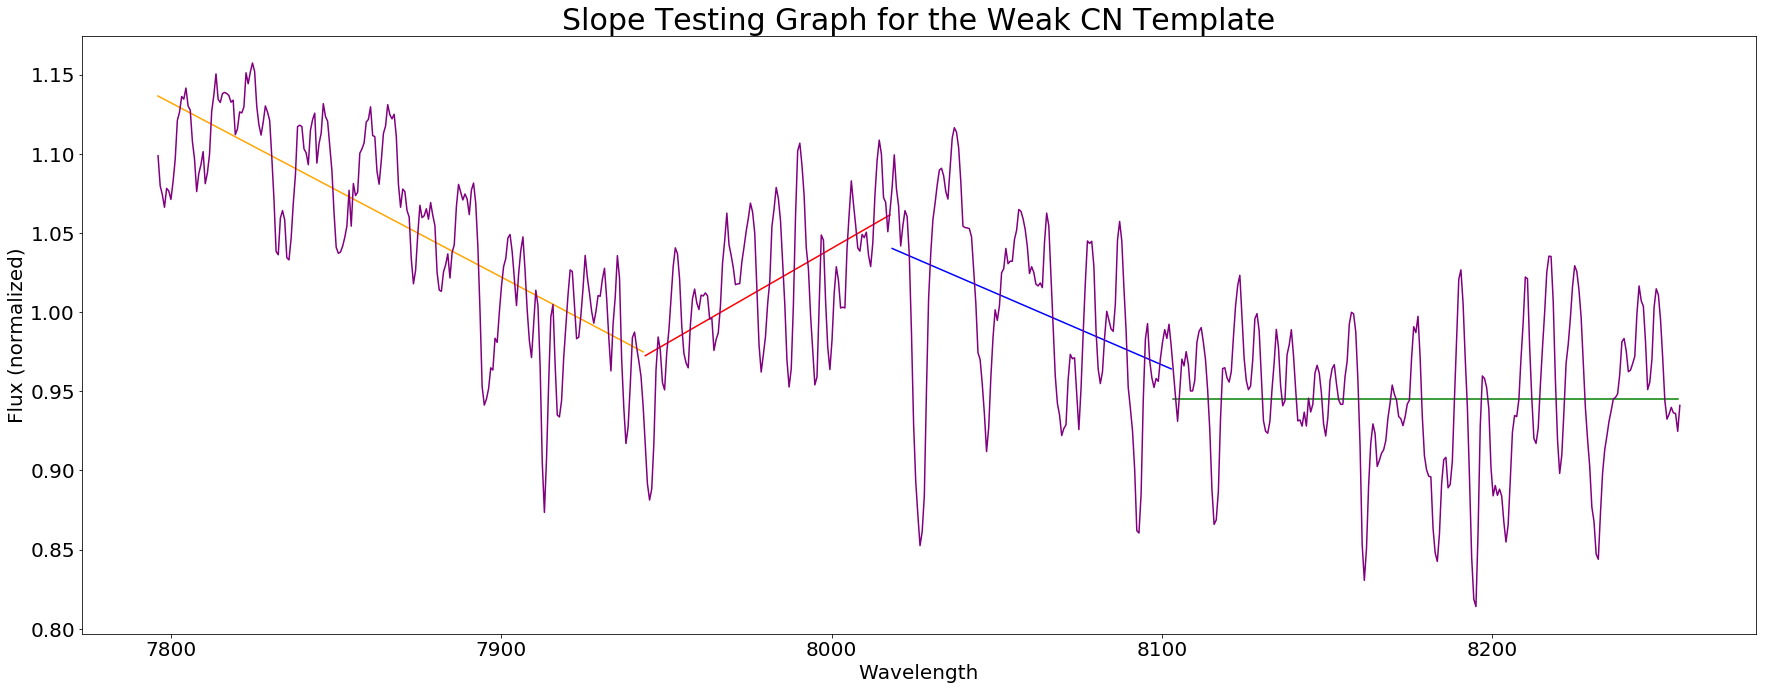

In [307]:
#Antara - creating a test graph of the Weak CN coadd to see if the lines of best fit match the data well
s1, s2, s3, s4, b1, b2, b3, b4 = getWSlopes(Wtemplate, getB = True)
lbin = data["LBIN"][0][lowerThresh:upperThresh]
plt.plot(lbin[windows[0][0]:windows[0][1]], lbin[windows[0][0]:windows[0][1]]*s1 + b1, color = 'orange')
plt.plot(lbin[windows[1][0]:windows[1][1]], lbin[windows[1][0]:windows[1][1]]*s2 + b2, color = 'r')
plt.plot(lbin[windows[2][0]:windows[2][1]], lbin[windows[2][0]:windows[2][1]]*s3 + b3, color = 'b')
plt.plot(lbin[windows[3][0]:windows[3][1]], lbin[windows[3][0]:windows[3][1]]*s4 + b4, color = 'g')
plt.plot(Wtemplate_wv, Wtemplate, color = 'purple')
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slope Testing Graph for the Weak CN Template", size = 30) 
plt.ylabel("Flux (normalized)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

## Creating dictionaries of slopes for all stars

In [308]:
#creates dictionaries of all four slopes for every star, as found in method 3
#Antara - commented out all unnecessary stuff
wNm_s1_dict, wNm_s2_dict, wNm_s3_dict, wNm_s4_dict = {}, {}, {}, {}
weak_s1_dict, weak_s2_dict, weak_s3_dict, weak_s4_dict = {}, {}, {}, {}
marginal_s1_dict, marginal_s2_dict, marginal_s3_dict, marginal_s4_dict = {}, {}, {}, {}
carbon_s1_dict, carbon_s2_dict, carbon_s3_dict, carbon_s4_dict = {}, {}, {}, {}
kphTrO1_s1_dict, kphTrO1_s2_dict, kphTrO1_s3_dict, kphTrO1_s4_dict = {}, {}, {}, {}
kphTrO2_s1_dict, kphTrO2_s2_dict, kphTrO2_s3_dict, kphTrO2_s4_dict = {}, {}, {}, {}
kphOthers_s1_dict, kphOthers_s2_dict, kphOthers_s3_dict, kphOthers_s4_dict = {}, {}, {}, {}
others_s1_dict, others_s2_dict, others_s3_dict, others_s4_dict = {}, {}, {}, {}
flaggedStars_s1_dict, flaggedStars_s2_dict, flaggedStars_s3_dict, flaggedStars_s4_dict = {}, {}, {}, {}
allstars_s1_dict, allstars_s2_dict, allstars_s3_dict, allstars_s4_dict = {}, {}, {}, {}
wNmNc_s1_dict, wNmNc_s2_dict, wNmNc_s3_dict, wNmNc_s4_dict = {}, {}, {}, {}

#creates lists that star indices will be appended to so that stars with NaN slopes can be picked out
validSlopeStars = []
invalidW1, invalidW2, invalidW3, invalidW4 = [], [], [], []

#creates a list of star classifications (corresponding to useStars) that is used exclusively for the below pandas plot
starTypes, wNmNcTypes = [], []



#generates the sample of stars to be used in the dictionaries (excludes outsiders)
useStars = []
useStars.extend(wNm); useStars.extend(allcarbon); useStars.extend(others)

#generates the dictionaries and keeps track of progress with a counter
ctr = 0
for star in useStars:
    if not splashSuccess_dict[star]:
        ctr += 1
        if ctr % 100 == 0:
            print(ctr)
        continue
    starSpectrum = normSpec(star = star)[1]
    s1, s2, s3, s4 = getWSlopes(starSpectrum)
    allstars_s1_dict[star], allstars_s2_dict[star], allstars_s3_dict[star], allstars_s4_dict[star] = s1, s2, s3, s4
    ctr += 1
    if np.isnan(s1):
        invalidW1.append(star)
    if np.isnan(s2):
        invalidW2.append(star)
    if np.isnan(s3):
        invalidW3.append(star)
    if np.isnan(s4):
        invalidW4.append(star)
    if not any(np.isnan([s1, s2, s3, s4])):
        validSlopeStars.append(star)
    if star in flaggedStars_list:
        flaggedStars_s1_dict[star], flaggedStars_s2_dict[star], flaggedStars_s3_dict[star], flaggedStars_s4_dict[star] = s1, s2, s3, s4
    if star in wNm:
        starTypes.append("Weak CN")
        wNm_s1_dict[star], wNm_s2_dict[star], wNm_s3_dict[star], wNm_s4_dict[star] = s1, s2, s3, s4
        wNmNc_s1_dict[star], wNmNc_s2_dict[star], wNmNc_s3_dict[star], wNmNc_s4_dict[star] = s1, s2, s3, s4
        wNmNcTypes.append("Weak CN")
        if star in weaks:
            weak_s1_dict[star], weak_s2_dict[star], weak_s3_dict[star], weak_s4_dict[star] = s1, s2, s3, s4
        if star in marginals:
            marginal_s1_dict[star], marginal_s2_dict[star], marginal_s3_dict[star], marginal_s4_dict[star] = s1, s2, s3, s4
    if star in allcarbon:
        starTypes.append("Carbon"); wNmNcTypes.append("Carbon")
        carbon_s1_dict[star], carbon_s2_dict[star], carbon_s3_dict[star], carbon_s4_dict[star] = s1, s2, s3, s4
        wNmNc_s1_dict[star], wNmNc_s2_dict[star], wNmNc_s3_dict[star], wNmNc_s4_dict[star] = s1, s2, s3, s4
    if star in others:
        starTypes.append("Other")
        others_s1_dict[star], others_s2_dict[star], others_s3_dict[star], others_s4_dict[star] = s1, s2, s3, s4
    if star in keckPhotoOthers:
        kphOthers_s1_dict[star], kphOthers_s2_dict[star], kphOthers_s3_dict[star], kphOthers_s4_dict[star] = s1, s2, s3, s4
    if star in kphTrimmedOthers1:
        kphTrO1_s1_dict[star], kphTrO1_s2_dict[star], kphTrO1_s3_dict[star], kphTrO1_s4_dict[star] = s1, s2, s3, s4
    if star in kphTrimmedOthers2: #cannot use 'else' because kphTrimmedOthers1 and kphTrimmedOthers2 overlap
        kphTrO2_s1_dict[star], kphTrO2_s2_dict[star], kphTrO2_s3_dict[star], kphTrO2_s4_dict[star] = s1, s2, s3, s4
        
    if ctr % 100 == 0:
        print(ctr)

#runs around 19800 

100
200
300
400
SlopeError: This spectrum is dominated by NaNs in window 1. Slope1 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 2. Slope2 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 3. Slope3 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 4. Slope4 could not be found.
500
600
700
800
900
SlopeError: This spectrum is dominated by NaNs in window 1. Slope1 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 2. Slope2 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 3. Slope3 could not be found.
SlopeError: This spectrum is dominated by NaNs in window 4. Slope4 could not be found.
1000
1100
1200
1300
1400
1500
1600
1700
1800
SlopeError: This spectrum is dominated by NaNs in window 3. Slope3 could not be found.
1900
2000
2100
2200
2300
SlopeError: This spectrum is dominated by NaNs in window 1. Slope1 could not be found.
SlopeError: This spectru

KeyboardInterrupt: 

In [ ]:
#metadata: seeing how many stars would be invalidated if the requirement "no NaN slopes" was imposed
print(str(len(useStars)) + " valid stars in SPLASH (w/o outsiders) become " + str(len(validSlopeStars)) + " stars if all NaN slopes are ignored.")

In [ ]:
#creating the pandas data frame that will be used below in making the parallel coordinates graph
#slopes_dict = {"s1":list(wNmNc_s1_dict.values()), "s2":list(wNmNc_s2_dict.values()), "s3":list(wNmNc_s3_dict.values()), "s4":list(wNmNc_s4_dict.values()), "type":wNmNcTypes}
#slopes = pd.DataFrame(slopes_dict)

#slicing the 254-256 stars

sliced1=  {k: v for k, v in wNmNc_s1_dict.items() if s1 != None }
sliced2=  {k: v for k, v in wNmNc_s2_dict.items() if s1 != None }
sliced3=  {k: v for k, v in wNmNc_s3_dict.items() if s1 != None }
sliced4=  {k: v for k, v in wNmNc_s4_dict.items() if s1 != None }

#creating the pandas data frame that will be used below in making the parallel coordinates graph
#Antara - edited so that this runs 
slopes_dict = {"s1": list(sliced1.values()), "s2": list(sliced2.values()), "s3": list(sliced3.values()), "s4": list(sliced4.values()), "type":wNmNcTypes}

slopes = pd.DataFrame.from_dict(slopes_dict, orient='index')
slopes.transpose()

#used slopes.transpose to get an output and see where the problem is
#comment it out for data analysis because it flips rows and columns 
#there are some carbon stars that have None for all slopes but are somehow still in this list


How do I remove the None values? I've tried a couple of times but it isn't working. -Antara
(tried to define a function too but it didn't work)

slopes_dict = {"s1": list(wNmNc_s1_dict.values()), "s2": list(wNmNc_s2_dict.values()), "s3": list(wNmNc_s3_dict.values()), "s4": list(wNmNc_s4_dict.values()), "type":wNmNcTypes}

#checking that all lengths are the same

print(len(wNmNc_s1_dict.values()))  
print(len(wNmNc_s2_dict.values())) 
print(len(wNmNc_s3_dict.values()))  
print(len(wNmNc_s4_dict.values()))     


slopes = pd.DataFrame(slopes_dict)




#creating a parallel coordinates graph in an attempt to do four-dimensional data analysis of the slopes
pd.plotting.parallel_coordinates(slopes, 'type', color = ("r", "g", "b"))
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slopes of Stars", size = 30)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
#creates a scatter plot of slope1 vs. slope2 for weak CN, carbon, and identified, ivar-trimmed other stars
plt.scatter(carbon_s1_dict.values(), carbon_s2_dict.values(), color = 'r', alpha = 0.5, label = 'Carbon Stars')
plt.scatter(kphTrO1_s1_dict.values(), kphTrO1_s2_dict.values(), alpha = 0.5, color = 'g', label = 'Others1 Stars')
plt.scatter(kphTrO2_s1_dict.values(), kphTrO2_s2_dict.values(), alpha = 0.5, color = 'orange', label = 'Others2 Stars')
plt.scatter(weak_s1_dict.values(), weak_s2_dict.values(), color = 'b', alpha = 0.5, s = 100, label = 'Weak CN Stars')
plt.scatter(marginal_s1_dict.values(), marginal_s2_dict.values(), color = 'b', alpha = 0.5, s = 10, label = 'Marginal CN Stars')
#plt.scatter(wNm_s1_dict.values(), wNm_s2_dict.values(), color = 'b', alpha = 0.5, label = 'Weak CN Stars')

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slope1 vs. Slope2", size = 30) 
plt.ylabel("Slope2", size = 20)
plt.xlabel("Slope1", size = 20)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
#creates a scatter plot of slope1 vs. slope2 for weak CN, carbon, and identified, ivar-trimmed other stars
plt.scatter(carbon_s3_dict.values(), carbon_s4_dict.values(), color = 'r', alpha = 0.5, label = 'Carbon Stars')
plt.scatter(kphTrO1_s3_dict.values(), kphTrO1_s4_dict.values(), alpha = 0.5, color = 'g', label = 'Others1 Stars')
plt.scatter(kphTrO2_s3_dict.values(), kphTrO2_s4_dict.values(), alpha = 0.5, color = 'orange', label = 'Others2 Stars')
plt.scatter(weak_s3_dict.values(), weak_s4_dict.values(), color = 'b', alpha = 0.5, s = 100, label = 'Weak CN Stars')
plt.scatter(marginal_s3_dict.values(), marginal_s4_dict.values(), color = 'b', alpha = 0.5, s = 10, label = 'Marginal CN Stars')
#plt.scatter(wNm_s3_dict.values(), wNm_s4_dict.values(), color = 'b', alpha = 0.5, label = 'Weak CN Stars')

#formatting the graph so that it is easier to read
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Slope3 vs. Slope4", size = 30) 
plt.ylabel("Slope4", size = 20)
plt.xlabel("Slope3", size = 20)
plt.legend(fontsize = 20)
plt.show()

## Plot s4-s3 vs s2-s1

In [ ]:
#create slope arrays from dictionary values for weak CN
s4_wNm = np.array(list(wNm_s4_dict.values()))
s3_wNm = np.array(list(wNm_s3_dict.values()))
s2_wNm = np.array(list(wNm_s2_dict.values()))
s1_wNm = np.array(list(wNm_s1_dict.values()))

#create slope arrays from dictionary values for Carbon
s4_C = np.array(list(carbon_s4_dict.values()))
s3_C = np.array(list(carbon_s3_dict.values()))
s2_C = np.array(list(carbon_s2_dict.values()))
s1_C = np.array(list(carbon_s1_dict.values()))

#create slope arrays from dictionary values for Others
s4_O = np.array(list(others_s4_dict.values()))
s3_O = np.array(list(others_s3_dict.values()))
s2_O = np.array(list(others_s2_dict.values()))
s1_O = np.array(list(others_s1_dict.values()))

#Perform s4-s3 and s2-s1 operation for each group
s4_s3_wNm = s4_wNm - s3_wNm
s2_s1_wNm = s2_wNm - s1_wNm

s4_s3_C = s4_C - s3_C
s2_s1_C = s2_C - s1_C

s4_s3_O = s4_O - s3_O
s2_s1_O = s2_O - s1_O

#Normalize s4-s3 and s2-s1 to template


In [ ]:
plt.scatter(s4_s3_O, s2_s1_O, color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(s4_s3_wNm, s2_s1_wNm, color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(s4_s3_C, s2_s1_C, color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.title("S4-S3 vs S2-S1", size = 30) 
plt.ylabel("Slope 2 - Slope 1", size = 25)
plt.xlim([-.01,.01])
plt.ylim([-.025,.03])
plt.xlabel("Slope 4 - Slope 3", size = 25)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
#finding s4 - s3 and s2 - s1 for the templates of carbon
s1c_template,s2c_template,s3c_template,s4c_template = getWSlopes(Ctemplate)
s4_s3_c_template = s4c_template-s3c_template
s2_s1_c_template = s2c_template-s1c_template

#plotting standardized histogram for s2 - s1 for carbon vs. wNm
plt.hist(s2_s1_C - s2_s1_c_template, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s2_s1_wNm - s2_s1_c_template, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.hist(s2_s1_O - s2_s1_c_template, color='orange',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.02,.02])
plt.title("S2-S1 standardized to carbon template", size = 30) 

plt.legend(fontsize = 20)

plt.show()

#plotting standardized histogram for s4 - s3 for carbon vs. wNm
plt.hist(s4_s3_C - s4_s3_c_template, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s4_s3_wNm - s4_s3_c_template, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.hist(s4_s3_O - s4_s3_c_template, color='orange',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.02,.02])
plt.title("S4-S3 standardized to carbon template", size = 30) 

plt.legend(fontsize = 20)

plt.show()

In [ ]:
#finding s4 - s3 and s2 - s1 for the templates of carbon and weak CN
s1c_template,s2c_template,s3c_template,s4c_template = getWSlopes(Ctemplate)
s4_s3_c_template = s4c_template-s3c_template
s2_s1_c_template = s2c_template-s1c_template

s1w_template,s2w_template,s3w_template,s4w_template = getWSlopes(Wtemplate)
s4_s3_w_template = s4w_template-s3w_template
s2_s1_w_template = s2w_template-s1w_template

#plotting standardized histogram for s2 - s1 for carbon vs. wNm
plt.hist(s2_s1_C - s2_s1_c_template, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s2_s1_wNm - s2_s1_w_template, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.02,.02])
plt.title("S2-S1 standardized to respective template", size = 30) 

plt.legend(fontsize = 20)

plt.show()

#plotting standardized histogram for s4 - s3 for carbon vs. wNm
plt.hist(s4_s3_C - s4_s3_c_template, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s4_s3_wNm - s4_s3_w_template, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.02,.02])
plt.title("S4-S3 standardized to respective template", size = 30) 

plt.legend(fontsize = 20)

plt.show()

In [ ]:
#finding s4 - s3 and s2 - s1 for the templates of carbon and weak CN
s1c_template,s2c_template,s3c_template,s4c_template = getWSlopes(Ctemplate)
s4_s3_c_template = s4c_template-s3c_template
s2_s1_c_template = s2c_template-s1c_template

s1w_template,s2w_template,s3w_template,s4w_template = getWSlopes(Wtemplate)
s4_s3_w_template = s4w_template-s3w_template
s2_s1_w_template = s2w_template-s1w_template

#plotting standardized histogram for s2 - s1 for carbon vs. wNm
plt.hist(s2_s1_C, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s2_s1_wNm, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.01,.04])
plt.title("S2-S1", size = 30) 

plt.legend(fontsize = 20)

plt.show()

#plotting standardized histogram for s4 - s3 for carbon vs. wNm
plt.hist(s4_s3_C, color='red',histtype=u'step', linewidth = 2.0, label = 'Carbon')
plt.hist(s4_s3_wNm, color='blue',histtype=u'step', linewidth = 2.0, label = 'Weak CN')
plt.ylabel('count', size = 25)
plt.xlabel('standardized slope difference', size = 25)
plt.xlim([-.01,.04])
plt.title("S4-S3", size = 30) 

plt.legend(fontsize = 20)

plt.show()

# Creating CMDs

Includes functions for creating CMDs based on the F814W and F160W filter data from the PHAT survey. In these CMDs, the x-axis is F814W - F160W and the y-axis is F160W (this can be changed by editing the graphCMD function). Also includes functions that draw bins on the CMD for grouping stars, and functions that determine whether or not certain stars lie within those bins. These processes are used to create new datasets for coadditions, as well as analyze the placement of unidentified stars relative to identified carbon and weak CN stars.

In [ ]:
#defines a function that plots any set of star indices on a CMD
#note that the CMD is defined as followed: the x-axis is visible - infrared and the y-axis is infrared
def graphCMD(data, indices, markersize = 20, color = 'b', marker = 'o', label = None, facecolor = True, alpha = None):
    '''
    data: a Numpy array that consists of the dataset your color-magnitude information is contained in
    indices: a Numpy array or list of the star indices to be graphed on the CMD
    markersize: an integer representing the size of the dots to be plotted on the CMD
    color: a string representing the color of the dots to be plotted on the CMD
    marker: a string representing the shape of the dots to be plotted on the CMD
    label: a string representing the label that will be assigned in the legend of the CMD to the dots plotted here
    facecolor: a Boolean value that, if True, will fill in the dots plotted on the CMD and, if False, will plot open circles
    alpha: a numerical value representing the opacity of the markers to be graphed
    
    markersize, color, marker, label, facecolor, and alpha will default to 20, 'b' (blue), 'o', None, True, and None respectively
    
    Note that there is no return value, as well as no plt.show() statement. The plt.show() statement must be included in your code where this function is called
    '''
    if facecolor:
        plt.scatter((data.F814W[indices] - data.F160W[indices]), data.F160W[indices], s = markersize, color = color, marker = marker, label = label, alpha = alpha)
    else:
        plt.scatter((data.F814W[indices] - data.F160W[indices]), data.F160W[indices], s = markersize, color = color, marker = marker, label = label, facecolors = 'none', alpha = alpha)

In [ ]:
#defines variables that will be used for graphing Rosenfield's line
m = (19 - -52.965)/(2.03045-10)
xRos = np.arange(1, 3, .01)
yRos = m*xRos - 2.0345*m + 19

In [ ]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11

graphCMD(data, others, 1, 'black', label = 'Other', alpha = .6, facecolor = False)
graphCMD(data, wNm, 13, 'blue', label = 'Visually Classified Weak CN')
graphCMD(data, allcarbon, 13, 'red', label = 'Visually Classified Carbon')
#graphCMD(data, possTruewNm, 13, 'purple', label = 'Machine-Classified Weak CN')
#graphCMD(data, possTruewNm_multiD, 13, 'green', label = 'Multi-D Classified Weak CN')
#graphCMD(data, possTruewNm_multiD2, 13, 'green', label = 'Multi-D Classified Weak CN')
#graphCMD(data, possTruewNm_multiD3, 13, 'green', label = 'Multi-D Classified Weak CN')

# polygon(Cbin1_points, 'blue', 'Carbon 1 (C1)')
# polygon(Cbin2_points, 'violet', 'Carbon 2 (C2)')
# polygon(Wbin1_points, 'orange', 'Weak CN 1 (W1)')
# polygon(Wbin2_points, 'indigo', 'Weak CN 2 (W2)')

plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram", size = 20) 
plt.ylabel("F160W", size = 20)
plt.xlabel("F814W - F160W", size = 20)
plt.xlim(-1, 5)
plt.ylim(25, 14)
# plt.xlim(1,4)
# plt.ylim(21,16)
plt.legend(loc = "right", bbox_to_anchor = (1.3,.5))
plt.show()

# Probability Testing

## Unmodified Templates - Full Range

In [ ]:
#classify as either carbon or wNm using scores to carbon template
#returns probability it is a WeakCN Star

def probWCN_CTemp(star):
    #retrieve star's score
    starCscore=getScore(Ctemplate, splashSpecs_dict[star], splashIvars_dict[star])
    #count the number of carbon above and weakCN below
    numberCarbonAbove = 0
    numberWeakCNBelow = 0
    for value in carbon_Cscore_dict.values():
        if(starCscore<value):
            numberCarbonAbove+=1
    for value in wNm_Cscore_dict.values():
        if(starCscore>value):
            numberWeakCNBelow+=1;
    
    #Calculates probability by taking propotion of stars on left and right
    probCarbon = numberCarbonAbove/(numberCarbonAbove+numberWeakCNBelow)
    probWeakCN = numberWeakCNBelow/(numberCarbonAbove+numberWeakCNBelow)

#     print('Score of star versus C template: ',starCscore)
#     print('Probability star is carbon: ', probCarbon)
#     print('Probability Star is WeakCN: ', probWeakCN)
    return probWeakCN
    
#probWCN_CTemp(19971)

In [ ]:
#classify as either carbon or wNm using scores to WeakCN template
#returns probability it is a WeakCN Star

def probWCN_WTemp(star):
    #retrieve star's score
    starWscore=getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
    #count the number of carbon below and weakCN above
    numberCarbonBelow = 0
    numberWeakCNAbove = 0
    for value in carbon_score_dict.values():
        if(starWscore>value):
            numberCarbonBelow+=1
    for value in wNm_score_dict.values():
        if(starWscore<value):
            numberWeakCNAbove+=1;
    
    #Calculates probability by taking propotion of stars on left and right
    probCarbon = numberCarbonBelow/(numberCarbonBelow+numberWeakCNAbove)
    probWeakCN = numberWeakCNAbove/(numberCarbonBelow+numberWeakCNAbove)

#     print('Score of star versus W template: ',starWscore)
#     print('Probability star is carbon: ', probCarbon)
#     print('Probability Star is WeakCN: ', probWeakCN)
    return probWeakCN

#probWCN_WTemp(19971)

In [ ]:
probThresh = 0.5

In [ ]:
#def carbonClassificationByTemplateScore(probThresh = 0.5):
    #Test accuracy of using the C and W template on carbon stars
countCorrectByC = 0
countCorrectByW = 0
countCorrectByProduct = 0
probByC_C = []
probByW_C = []
probByProduct_C = []
total = 0

    #Iterate over all stars
for star in allcarbon:
        #Skip over if not valid
    if(not(splashSuccess_dict[star])):
        continue
        #If the probability is less than 0.5, less likely to be Weak CN
    if (probWCN_CTemp(star)<probThresh):
        countCorrectByC+=1
        probByC_C.append(probWCN_CTemp(star))
    if (probWCN_WTemp(star)<probThresh):
        countCorrectByW+=1 
        probByW_C.append(probWCN_WTemp(star))
    if (probWCN_CTemp(star)*probWCN_CTemp(star)<probThresh):
        countCorrectByProduct+=1
        probByProduct_C.append(probWCN_CTemp(star)*probWCN_CTemp(star))
    total+=1

    #Prints porprtion of stars for which a correct analysis was given
print('Percent of carbon correctly identified by C template: ',countCorrectByC/total)
print('Percent of carbon correctly identified by W template: ',countCorrectByW/total)
print('Percent of carbon correctly identified by product: ',countCorrectByProduct/total)


In [ ]:
#def weakCNClassificationByTemplateScore(probThresh = 0.5):
    #Test accuracy of using the C and W template on WeakCN stars
countCorrectByC = 0
countCorrectByW = 0
countCorrectByProduct = 0
probByC_W = []
probByW_W = []
probByProduct_W = []
total = 0
    #Iterate over all stars
for star in wNm:
        #Skip over if not valid
    if(not(splashSuccess_dict[star])):
        continue
        #If the probability is less than 0.5, less likely to be Weak CN
    if (probWCN_CTemp(star)>probThresh):
        countCorrectByC+=1
        probByC_W.append(probWCN_CTemp(star))
    if (probWCN_WTemp(star)>probThresh):
        countCorrectByW+=1  
        probByW_W.append(probWCN_CTemp(star))
    if (probWCN_CTemp(star)*probWCN_CTemp(star)>probThresh):
        countCorrectByProduct+=1
        probByProduct_W.append(probWCN_CTemp(star))
    total+=1


    #Prints porprtion of stars for which a correct analysis was given
print(' ')
print('Percent of wNm correctly identified by C template: ',countCorrectByC/total)
print('Percent of wNm correctly identified by W template: ',countCorrectByW/total)
print('Percent of wNm correctly identified by product: ',countCorrectByProduct/total)

In [ ]:
for probThresh in [0.65]:
    print(probThresh)
    carbonClassificationByTemplateScore(probThresh)
    weakCNClassificationByTemplateScore(probThresh)

In [ ]:
plt.hist(probByC_C, color ='red',histtype=u'step', linewidth = 2.0,label='Carbon')
plt.hist(probByC_W, color = 'blue',histtype=u'step', linewidth = 2.0,label='Weak CN')

plt.axvline(x = probThresh)
plt.xlabel('Chance of being Weak CN')
plt.ylabel('Count')
plt.title('Distribution of Probabilities of Star being Weak CN')
plt.legend()

In [ ]:
plt.hist(probByW_C, color ='red',histtype=u'step', linewidth = 4.0,label='Carbon')
plt.hist(probByW_W, color = 'blue',histtype=u'step', linewidth = 4.0,label='Weak CN')

plt.axvline(x = probThresh)
plt.xlabel('Chance of being Weak CN')
plt.ylabel('Count')
plt.title('Distribution of Probabilities of Star being Weak CN')
plt.legend()

## Unmodified Templates - First 'U' Range

#creates a function that calculates the score (a measure of the difference between two spectra) for a certain star's spectrum compared to a certain template spectrum
#note that the input spectra and ivars must be already sliced and normalized
def getScoreFirstU(templateSpec, scienceSpec, ivars, lowerThreshBound = 5840, upperThreshBound = 6550):
    '''
    templateSpec: a Numpy array containing the flux values of the coadded template spectrum
    scienceSpec: a Numpy array containing the flux values at each wavelength of the normalized spectrum for a specific star
    ivars: a Numpy array containing the normalized ivar values at each wavelength of the spectrum for a specific star
    
    Returns finalScore, a float representing the similarity between the two spectra. A lower score indicates greater similarity and a higher score indicates lower similarity
    Note that spectra that cannot be normalized will not have a score associated with them. The function returns a NaN as the score for these spectra
    '''
    templateSpec_list = templateSpec.tolist()
    scienceSpec_list = scienceSpec[~np.isnan(scienceSpec)].tolist()
    if scienceSpec_list == []:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan
    else:
        summedScore = 0
        for wv in range(len(templateSpec_list)):
            score = ((scienceSpec[wv] - templateSpec[wv])**2) * ivars[wv]
            if not np.isnan(score):
                summedScore += score
        summedIvars = 0
        for ivar in ivars:
            if not np.isnan(ivar):
                summedIvars += ivar
        finalScore = (summedScore/summedIvars)**0.5
        return finalScore

#test execution of function
specStar, ivarStar = splashSpecs_dict[19534],splashIvars_dict[19534]
print("Score: " + str(getScore(Wtemplate, specStar, ivarStar)))

In [ ]:
carbon_Cscore_dict_1U = {}
carbon_score_dict_1U = {}
wNm_Cscore_dict_1U = {}
wNm_score_dict_1U = {}
others_Cscore_dict_1U = {}
others_score_dict_1U = {}

for star in allcarbon:
    if(splashSuccess_dict[star]):
        carbon_Cscore_dict_1U[star] = getScore(Ctemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
        carbon_score_dict_1U[star] = getScore(Wtemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
    
for star in wNm:
    if(splashSuccess_dict[star]):
        wNm_Cscore_dict_1U[star] = getScore(Ctemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
        wNm_score_dict_1U[star] = getScore(Wtemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
count = 0
for star in others:
    if(splashSuccess_dict[star]):
        others_Cscore_dict_1U[star] = getScore(Ctemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
        others_score_dict_1U[star] = getScore(Wtemplate[:355], 
                                               splashSpecs_dict[star][:355], 
                                               splashIvars_dict[star][:355])
        if(count%100==0):
            print(count)
        count+=1
        

In [ ]:
plt.scatter(others_score_dict_1U.values(), others_Cscore_dict_1U.values(),color ='orange',s=10)
plt.scatter(carbon_score_dict_1U.values(), carbon_Cscore_dict_1U.values(), color ='red')
plt.scatter(wNm_score_dict_1U.values(), wNm_Cscore_dict_1U.values(),color ='blue',s=35)
plt.xlim(0,2)
plt.ylim(0.1,0.7)
#print(wNm_Cscore_dict_1U)

In [ ]:
#classify as either carbon or wNm using scores to carbon template
#returns probability it is a WeakCN Star

def probWCN_CTemp_1U(star):
    #retrieve star's score
    starCscore=getScore(Ctemplate[lowerThresh:middleThresh], splashSpecs_dict[star][:355], splashIvars_dict[star][:355])
    #count the number of carbon above and weakCN below
    numberCarbonAbove = 0
    numberWeakCNBelow = 0
    for value in carbon_Cscore_dict_1U.values():
        if(starCscore<value):
            numberCarbonAbove+=1
    for value in wNm_Cscore_dict_1U.values():
        if(starCscore>value):
            numberWeakCNBelow+=1;
    try:
        #Calculates probability by taking propotion of stars on left and right
        probCarbon = numberCarbonAbove/(numberCarbonAbove+numberWeakCNBelow)
        probWeakCN = numberWeakCNBelow/(numberCarbonAbove+numberWeakCNBelow)

    #     print('Score of star versus C template: ',starCscore)
    #     print('Probability star is carbon: ', probCarbon)
    #     print('Probability Star is WeakCN: ', probWeakCN)
        return probWeakCN
    except:
        return 1
    
#probWeakCNByCTemplate(19971)

In [ ]:
#classify as either carbon or wNm using scores to WeakCN template
#returns probability it is a WeakCN Star

def probWCN_WTemp_1U(star):
    #retrieve star's score
    starWscore=getScore(Wtemplate[5840:6184], splashSpecs_dict[star][:355], splashIvars_dict[star][:355])
    #count the number of carbon below and weakCN above
    numberCarbonBelow = 0
    numberWeakCNAbove = 0
    for value in carbon_score_dict_1U.values():
        if(starWscore>value):
            numberCarbonBelow+=1
    for value in wNm_score_dict_1U.values():
        if(starWscore<value):
            numberWeakCNAbove+=1;
    try:
        #Calculates probability by taking propotion of stars on left and right
        probCarbon = numberCarbonBelow/(numberCarbonBelow+numberWeakCNAbove)
        probWeakCN = numberWeakCNAbove/(numberCarbonBelow+numberWeakCNAbove)

    #     print('Score of star versus W template: ',starWscore)
    #     print('Probability star is carbon: ', probCarbon)
    #     print('Probability Star is WeakCN: ', probWeakCN)
        return probWeakCN
    except:
        return 1

#probWeakCNByWTemplate(19971)

In [ ]:
probByC_C_1U = []
probByW_C_1U = []
probByProduct_C_1U = []
#Carbon Classification By Template Score First U
def CClassifier_1U(probThresh = 0.5):
    #Test accuracy of using the C and W template on carbon stars
    countCorrectByC = 0
    countCorrectByW = 0
    countCorrectByProduct = 0
    
    total = 0

    #Iterate over all stars
    for star in allcarbon:
        #Skip over if not valid
        if(not(splashSuccess_dict[star])):
            continue
        #If the probability is less than 0.5, less likely to be Weak CN
        if (probWCN_CTemp_1U(star)<probThresh):
            countCorrectByC+=1
            probByC_C.append(probWCN_CTemp_1U(star))
        if (probWCN_WTemp_1U(star)<probThresh):
            countCorrectByW+=1 
            probByW_C.append(probWCN_WTemp_1U(star))
        if (probWCN_CTemp_1U(star)*probWCN_CTemp_1U(star)<probThresh):
            countCorrectByProduct+=1
            probByProduct_C.append(probWCN_CTemp_1U(star)*probWCN_CTemp_1U(star))
        total+=1

    #Prints porprtion of stars for which a correct analysis was given
    print('Percent of carbon correctly identified by C template: ',countCorrectByC/total)
    print('Percent of carbon correctly identified by W template: ',countCorrectByW/total)
    print('Percent of carbon correctly identified by product: ',countCorrectByProduct/total)


In [ ]:
probByC_W_1U = []
probByW_W_1U = []
probByProduct_W_1U = []
#WCNClassifier_1U
def WCNClassifier_1U(probThresh = 0.5):
    #Test accuracy of using the C and W template on WeakCN stars
    countCorrectByC = 0
    countCorrectByW = 0
    countCorrectByProduct = 0
    total = 0
    #Iterate over all stars
    for star in wNm:
        #Skip over if not valid
        if(not(splashSuccess_dict[star])):
            continue
        #If the probability is less than 0.5, less likely to be Weak CN
        if (probWCN_CTemp_1U(star)>probThresh):
            countCorrectByC+=1
            probByC_W.append(probWCN_CTemp_1U(star))
        if (probWCN_WTemp_1U(star)>probThresh):
            countCorrectByW+=1  
            probByW_W.append(probWCN_CTemp_1U(star))
        if (probWCN_CTemp_1U(star)*probWCN_CTemp_1U(star)>probThresh):
            countCorrectByProduct+=1
            probByProduct_W.append(probWCN_CTemp_1U(star))
        total+=1


    #Prints porprtion of stars for which a correct analysis was given
    print(total)
    print('Percent of wNm correctly identified by C template: ',countCorrectByC/total)
    print('Percent of wNm correctly identified by W template: ',countCorrectByW/total)
    print('Percent of wNm correctly identified by product: ',countCorrectByProduct/total)

In [ ]:
for probThresh in [0.65]:
    print(probThresh)
    CClassifier_1U(probThresh)
    WCNClassifier_1U(probThresh)

In [ ]:
plt.hist(probByC_C_1U, color ='red',histtype=u'step', linewidth = 2.0)
plt.hist(probByC_W_1U, color = 'blue',histtype=u'step', linewidth = 2.0)

plt.axvline(x = probThresh)

In [ ]:
plt.hist(probByW_C_1U, color ='red',histtype=u'step', linewidth = 4.0)
plt.hist(probByW_W_1U, color = 'blue',histtype=u'step', linewidth = 4.0)

plt.axvline(x = probThresh)

# STUPID Classification

Star Type Using Polygon IDentification

In [ ]:
# Score Against Undiluted W vs C Template with 
# STUPID classification by Rectangle and Ellipse

fig, ax = plt.subplots()
plt.scatter(others_score2_uwdict.values(),others_score2_ucdict.values(), color ='orange', alpha =0.2, s= 18, label = 'Others')
plt.scatter(wNm_score2_uwdict.values(),wNm_score2_ucdict.values(), color='blue',s=35, label = 'Weak CN')
plt.scatter(carbon_score2_uwdict.values(),carbon_score2_ucdict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.xlim(0,1)
plt.ylim(0,1)
 # plt.xlim([0,0.25])
 # plt.ylim([0.2,0.4])
# plt.xlim([.08,0.12])
# plt.ylim([0.15,0.2])
# plt.xlim([0.25,0.35])
# plt.ylim([0.28,0.36])
plt.xlabel("Score against Weak CN Template", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Undiluted W vs C Template", size = 30) 
plt.legend(fontsize = 20)
# Creating the COW Line
divLineX= np.linspace(0,5,1000)
divLineY = 0.649*divLineX+0.124
plt.plot(divLineX,divLineY)

# paramaters for ellipse and rectangle
meanE = [0.095 ,  0.2568]
widthE = 0.15
heightE = 0.085
angleE = 29
xR = 0.12
yR = 0.22
widthR = 0.15
heightR = 0.07
angleR = 29
meanRAdj = [xR-widthR/2,yR-heightR/2]
ell = mpl.patches.Ellipse(xy=meanE, width=width, height=height, 
                          angle = 180+angle, lw=4, facecolor='None',edgecolor='b')
rect = mpl.patches.Rectangle(meanRAdj,width=widthR,height=heightR,linewidth=4,
                         angle = angleR, edgecolor='r',facecolor='none')


ax.add_patch(ell)
ax.add_patch(rect)
        
plt.show()

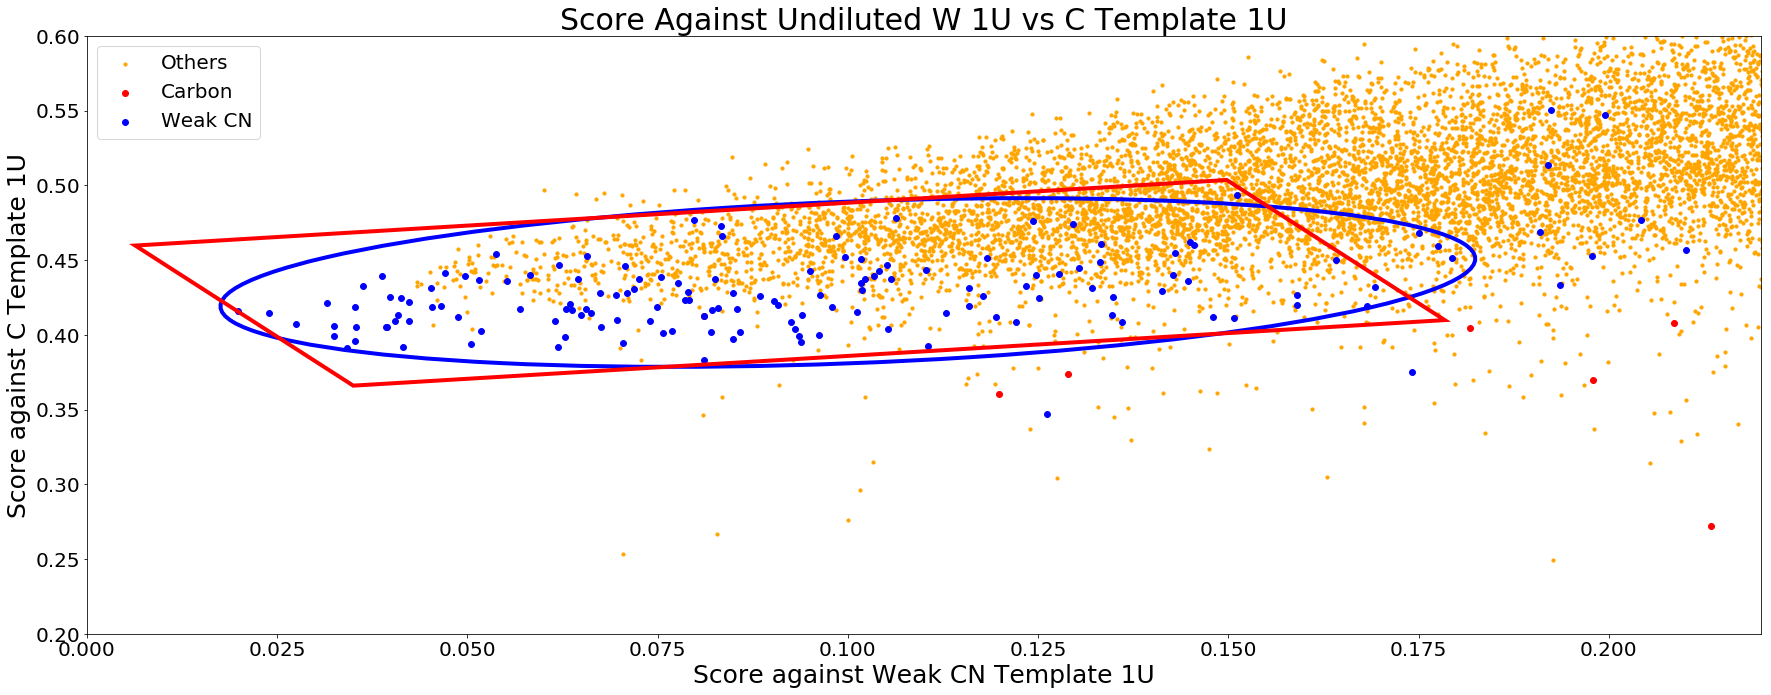

In [311]:
# Score Against Undiluted W vs C Template for only first U with 
# STUPID classification by Rectangle and Ellipse

fig, ax = plt.subplots()
plt.scatter(others_score_dict_1U.values(), others_Cscore_dict_1U.values(),color ='orange',s=10,label='Others')
plt.scatter(carbon_score_dict_1U.values(), carbon_Cscore_dict_1U.values(), color ='red',label='Carbon')
plt.scatter(wNm_score_dict_1U.values(), wNm_Cscore_dict_1U.values(),color ='blue',s=35,label='Weak CN')
plt.xlim(0,0.22)
plt.ylim(0.2,0.6)
plt.xlabel("Score against Weak CN Template 1U", size = 25)
plt.ylabel("Score against C Template 1U", size = 25)
plt.title("Score Against Undiluted W 1U vs C Template 1U", size = 30) 
plt.legend(fontsize = 20)

# paramaters for ellipse and rectangle
meanE = [ 0.1 ,  0.435]
widthE = 0.17
heightE = 0.105
angleE = 18
xR = 0.11
yR = 0.415
widthR = 0.15
heightR = 0.098
angleR = 17
meanRAdj = [xR-widthR/2,yR-heightR/2]
ell = mpl.patches.Ellipse(xy=meanE, width=widthE, height=heightE, 
                          angle = 180+angleE, lw=4, facecolor='None',edgecolor='b')
rect = mpl.patches.Rectangle(meanRAdj,width=widthR,height=heightR,linewidth=4,
                         angle = angleR, edgecolor='r',facecolor='none')


ax.add_patch(ell)
ax.add_patch(rect)
plt.show()

#print(wNm_Cscore_dict_1U)

In [ ]:
#Check if point is inside rectangle given parameters and location


In [ ]:
fig, ax = plt.subplots()
plt.scatter(s4_s3_O, s2_s1_O, color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(s4_s3_wNm, s2_s1_wNm, color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(s4_s3_C, s2_s1_C, color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11 
plt.title("S4-S3 vs S2-S1", size = 30) 
plt.ylabel("Slope 2 - Slope 1", size = 25)
plt.xlim([-.002,.0035])
plt.ylim([-.001,.015])
plt.xlabel("Slope 4 - Slope 3", size = 25)
plt.legend(fontsize = 20)

mean = [ 0.0010 ,  0.0022]
width = 0.0030
height = 0.0054
angle = 0
ell = mpl.patches.Ellipse(xy=mean, width=width, height=height, 
                          angle = 180+angle, lw=4, facecolor='None',edgecolor='b')

ax.add_patch(ell)

plt.show()

#Testing to find coordinates of certain points for ellipse boundaries
#for star in s4_s3_wNm:
     #if(s4_s3_wNm[star] < -0.001):
         #print(star,' s4_s3 = ',s4_s3_wNm[star])

for i in range(0,len(s4_s3_wNm)):
    if(s2_s1_wNm[i] > 0.0037):
        print(i,' s4_s3 = ',s4_s3_wNm[i],', s2_s1 = ',s2_s1_wNm[i])

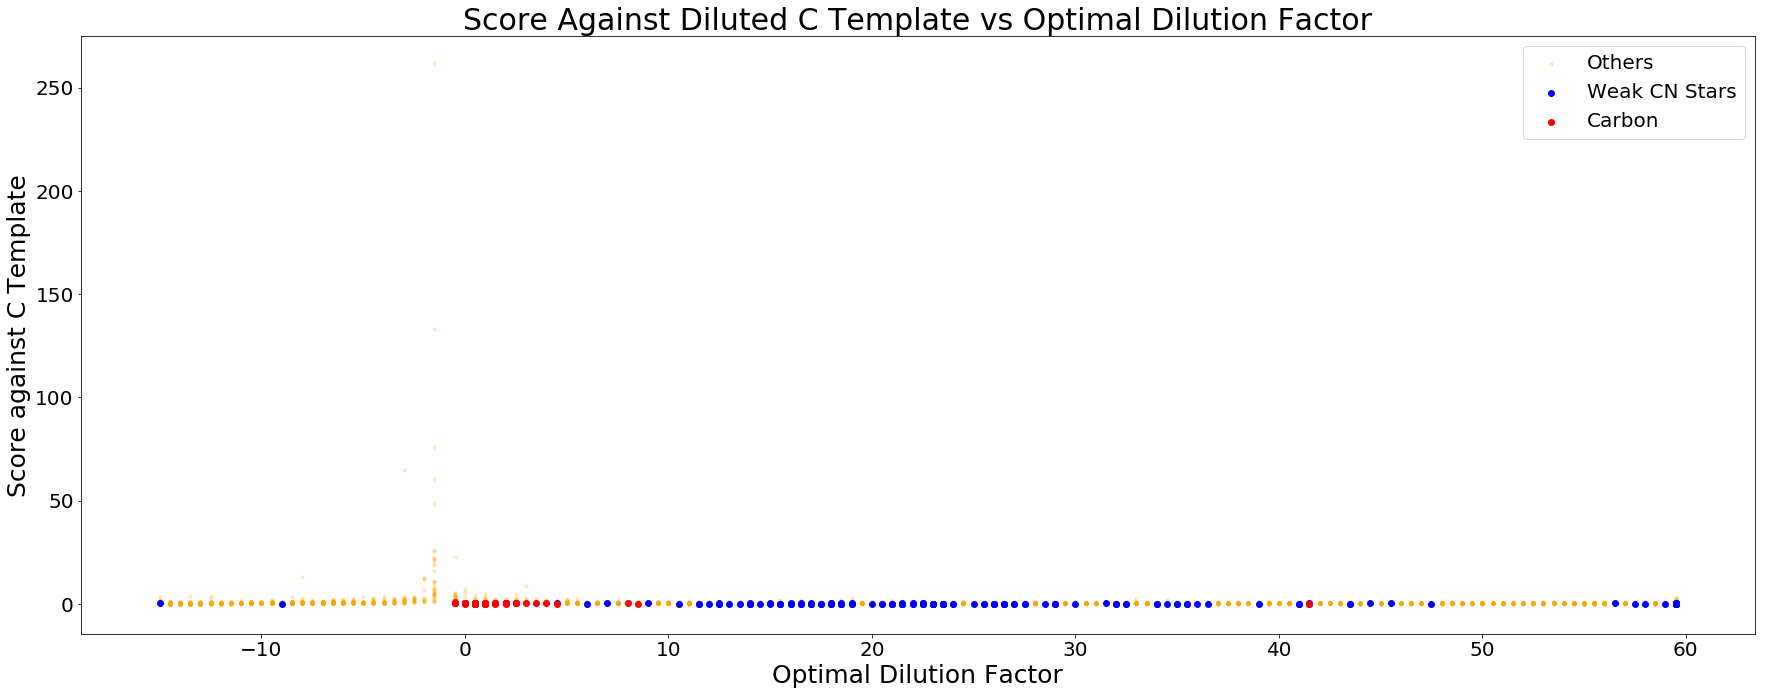

In [312]:
plt.scatter(others_c_dict.values(),others_score2_dict.values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(wNm_c_dict.values(),wNm_score2_dict.values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(carbon_c_dict.values(),carbon_score2_dict.values(), color ='red', label = 'Carbon')
plt.rcParams['figure.figsize'] = 30,11
# plt.xlim([-.05,.06])
# plt.ylim([0,1])
#plt.autoscale()
plt.xlabel("Optimal Dilution Factor", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Diluted C Template vs Optimal Dilution Factor", size = 30)
plt.legend(fontsize = 20)
plt.show()